## STEP 1: 시계열 데이터 준비

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [3]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']
ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

## STEP 2: 각종 전처리 수행

In [4]:
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

원래도 결측치가 없지만, 보간법을 한번 사용해보겠습니다.

In [5]:
ts = ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

Text(0.5, 1.0, 'Closing price of SAMSUNG')

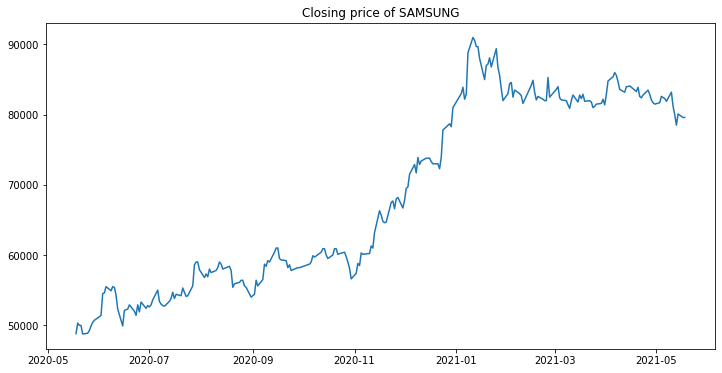

In [6]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(ts)
ax.set_title("Closing price of SAMSUNG")

로그 변환을 진행해보겠습니다.

Text(0.5, 1.0, 'Closing price(Log) of SAMSUNG')

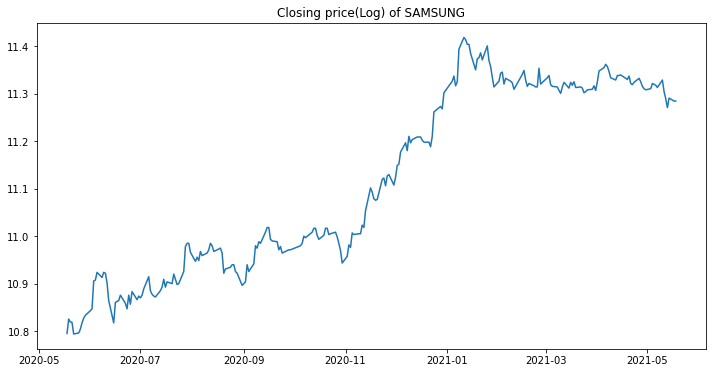

In [7]:
ts_log = np.log(ts)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(ts_log)
ax.set_title("Closing price(Log) of SAMSUNG")

## STEP 3: 시계열 안정성 분석

앞서 STEP 2에서 log 변환을 미리해줬기 때문에 log 변환을 한 `ts_log` 데이터를 대상으로 안정성 분석을 진행해보겠습니다. 안정성 분석의 방법은 

1. `plot_rolling_statistics`를 이용해 시각화를 해서 확인
2. `augmented_dickey_fuller_test`를 이용해 통계적으로 확인

의 두 가지 방법을 이용해 확인해보겠습니다.

In [8]:
def plot_rolling_statistics(timeseries, window=12):
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()
    
    fig, ax = plt.subplots(figsize=(15, 6))
    org = ax.plot(timeseries, color='royalblue', label='Original')
    mean = ax.plot(rolmean, color='tomato', label='Rolling Mean')
    
    ax_std = ax.twinx()
    std = ax_std.plot(rolstd, color='dimgray', label='Rolling Std')
    ax_std.set_ylim(0, 0.1)
    
#     ax.legend(loc='best')
#     ax_std.legend(loc='best')
    
    lns = org+mean+std
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc='best')
    
    ax.set_title("Rolling Mean & Standard deviation")

In [9]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')
    print("Results of Dickey-Fuller Test: ")
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput[f"Critical value {key}"] = value
    
    print(dfoutput)

> moving average를 고려할 때는 rolling mean을 구하기 위한 window 크기를 결정하는 것이 매우 중요하다는 것을 기억해 둡시다.

노드에서 언급했던만큼 다양한 이동평균을 고려해보겠습니다. 주식에서는 이동평균선이라는 지표를 통해 다양한 결정을 하고 있습니다. 흔히 사용하는 이동평균선은 15일, 60일 등이 있습니다. 이를 바탕으로 확인해보겠습니다.

`plot_rolling_statistics`를 기존의 노드와 다르게 수정했습니다.
* 'Rolling std'의 경우 값이 Mean, Original에 비해 작기 때문에 같은 y축을 사용하면 전부 평평하게 나옵니다. 따라서 별도의 y축을 사용하기 위해 `twinx`를 활용해서 수정했습니다.

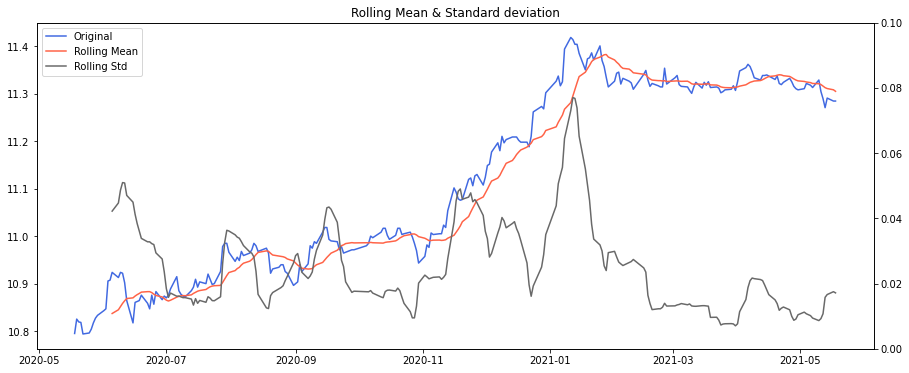

In [10]:
plot_rolling_statistics(ts_log, window=15)

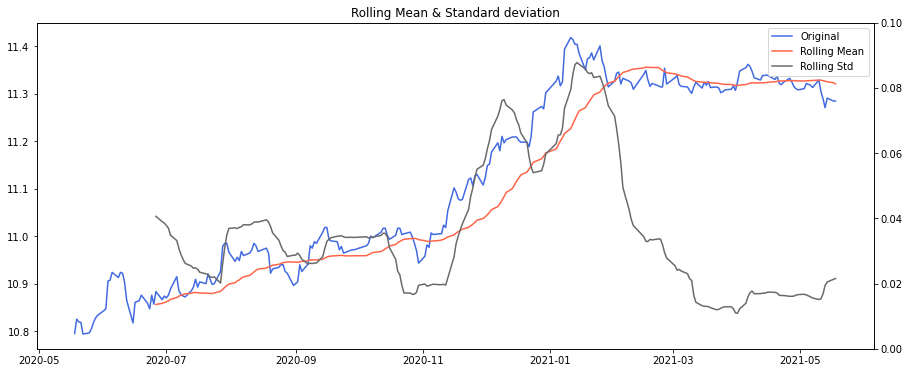

In [11]:
plot_rolling_statistics(ts_log, window=30)

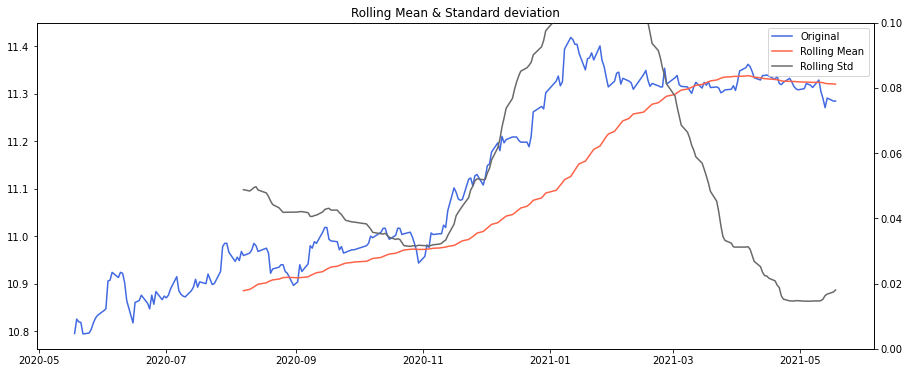

In [12]:
plot_rolling_statistics(ts_log, window=60)

각각 15, 30, 60일로 그림을 그리고 이동평균선, 이동표준편차선을 확인해보면 일정하지 않고 원래 그래프에 따라 상승하는 모습을 보입니다. 통계적으로도 확인해보기 위해  `augmented_dickey_fuller_test` 를 사용하겠습니다.

In [13]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test: 
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical value 1%               -3.456888
Critical value 5%               -2.873219
Critical value 10%              -2.572994
dtype: float64


로그 변환을 하고 나서의 유의수준값은 0.6으로 아직도 매우 높습니다. 따라서 별도의 전처리를 추가적으로 진행해주겠습니다.

### (1) Moving average 제거 - 추세(Trend) 상쇄하기

위에서 확인 15, 30, 60일 이동평균을 삭제하여 추세를 상쇄시킨 시계열 데이터를 각각 구하고 시각화를 해보고 통계적으로도 변화가 있는 지 확인해보겠습니다.

#### (a) 15일 이동평균 삭제

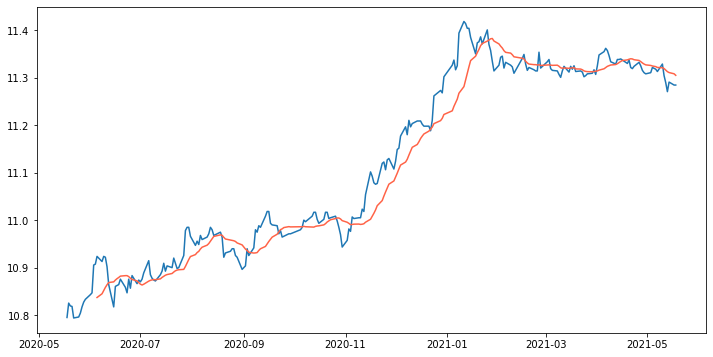

In [14]:
moving_avg_15 = ts_log.rolling(window=15).mean()  # moving average구하기
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(ts_log)
ax.plot(moving_avg_15, color='tomato')

In [15]:
ts_log_moving_avg_15 = ts_log - moving_avg_15 # 변화량 제거
ts_log_moving_avg_15.dropna(inplace=True)
ts_log_moving_avg_15.head(15)

Date
2020-06-05    0.086577
2020-06-08    0.067856
2020-06-09    0.072167
2020-06-10    0.063526
2020-06-11    0.037904
2020-06-12   -0.004310
2020-06-15   -0.052703
2020-06-16   -0.013309
2020-06-17   -0.014396
2020-06-18   -0.014949
2020-06-19   -0.006374
2020-06-22   -0.024567
2020-06-23   -0.036173
2020-06-24   -0.005421
2020-06-25   -0.021125
Name: Close, dtype: float64

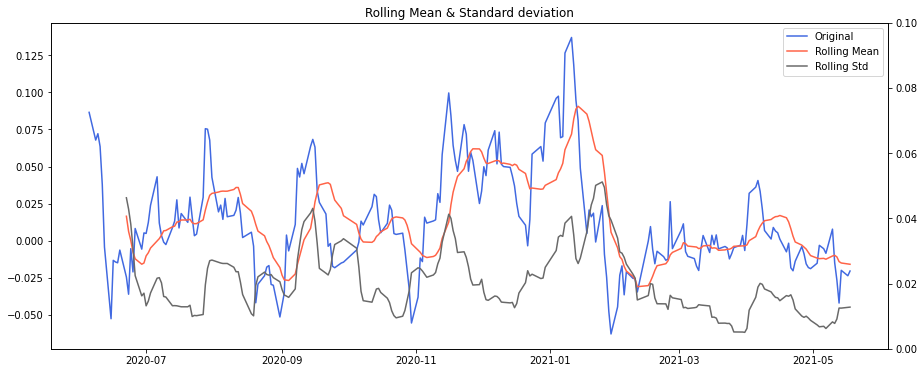

In [16]:
plot_rolling_statistics(ts_log_moving_avg_15)

In [17]:
augmented_dickey_fuller_test(ts_log_moving_avg_15)

Results of Dickey-Fuller Test: 
Test Statistic                  -3.977619
p-value                          0.001532
#Lags Used                       0.000000
Number of Observations Used    235.000000
Critical value 1%               -3.458487
Critical value 5%               -2.873919
Critical value 10%              -2.573367
dtype: float64


p-value가 0에 가까운 아주 작은 값으로 떨어진 것을 확인할 수 있습니다.

#### (b) 30일 이동평균 삭제

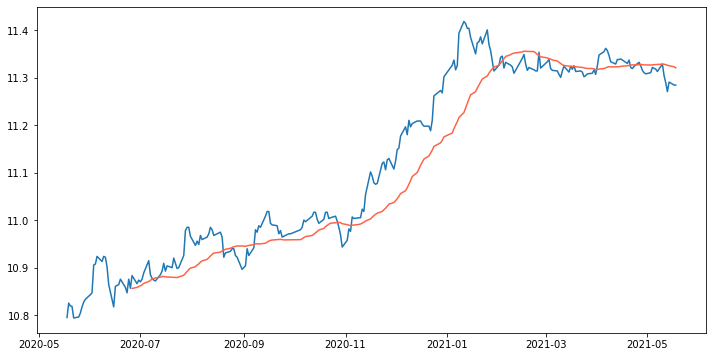

In [18]:
moving_avg_30 = ts_log.rolling(window=30).mean()  # moving average구하기
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(ts_log)
ax.plot(moving_avg_30, color='tomato')

In [19]:
ts_log_moving_avg_30 = ts_log - moving_avg_30 # 변화량 제거
ts_log_moving_avg_30.dropna(inplace=True)
ts_log_moving_avg_30.head(15)

Date
2020-06-26    0.027160
2020-06-29    0.007758
2020-06-30    0.013746
2020-07-01    0.008261
2020-07-02    0.012035
2020-07-03    0.022019
2020-07-06    0.043851
2020-07-07    0.011632
2020-07-08    0.002104
2020-07-09   -0.003227
2020-07-10   -0.006413
2020-07-13    0.005380
2020-07-14    0.011322
2020-07-15    0.027790
2020-07-16    0.011692
Name: Close, dtype: float64

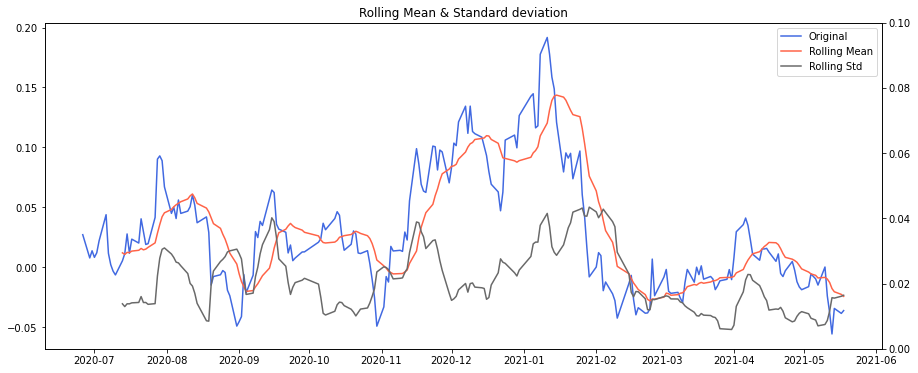

In [20]:
plot_rolling_statistics(ts_log_moving_avg_30)

In [21]:
augmented_dickey_fuller_test(ts_log_moving_avg_30)

Results of Dickey-Fuller Test: 
Test Statistic                  -2.241525
p-value                          0.191521
#Lags Used                       0.000000
Number of Observations Used    220.000000
Critical value 1%               -3.460428
Critical value 5%               -2.874769
Critical value 10%              -2.573821
dtype: float64


p-value가 0.19입니다

#### (c) 60일 이동평균 삭제

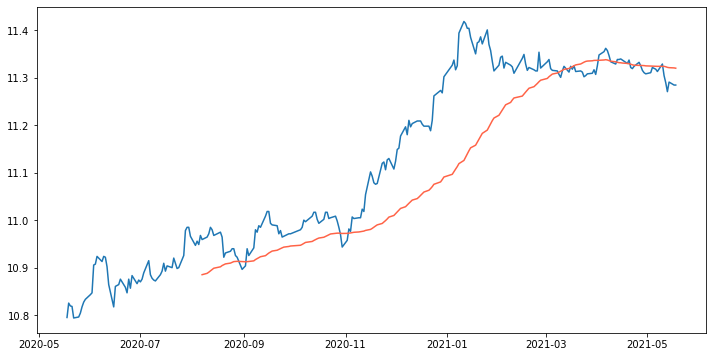

In [22]:
moving_avg_60 = ts_log.rolling(window=60).mean()  # moving average구하기
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(ts_log)
ax.plot(moving_avg_60, color='tomato')

In [23]:
ts_log_moving_avg_60 = ts_log - moving_avg_60 # 변화량 제거
ts_log_moving_avg_60.dropna(inplace=True)
ts_log_moving_avg_60.head(15)

Date
2020-08-07    0.073961
2020-08-10    0.076344
2020-08-11    0.080809
2020-08-12    0.091703
2020-08-13    0.083915
2020-08-14    0.069022
2020-08-18    0.072919
2020-08-19    0.059924
2020-08-20    0.015772
2020-08-21    0.023031
2020-08-24    0.024916
2020-08-25    0.028637
2020-08-26    0.027090
2020-08-27    0.012471
2020-08-28    0.008625
Name: Close, dtype: float64

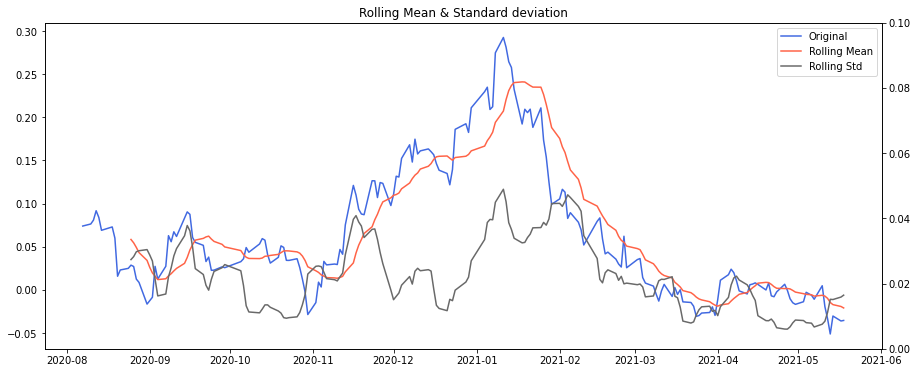

In [24]:
plot_rolling_statistics(ts_log_moving_avg_60)

In [25]:
augmented_dickey_fuller_test(ts_log_moving_avg_60)

Results of Dickey-Fuller Test: 
Test Statistic                  -1.194935
p-value                          0.675771
#Lags Used                       0.000000
Number of Observations Used    190.000000
Critical value 1%               -3.465244
Critical value 5%               -2.876875
Critical value 10%              -2.574945
dtype: float64


p-value가 0.67입니다

p-value가 가장 작은 15일 이동평균을 삭제한 `ts_log_moving_avg_15`를 사용하도록 하겠습니다.

### (2) 차분(Differencing) - 계절성(Seasonality) 상쇄하기
이동평균의 삭제로 잡히지 않는 시계열 데이터의 주기성들을 확인해보기 위해 계절성을 체크해보겠습니다.

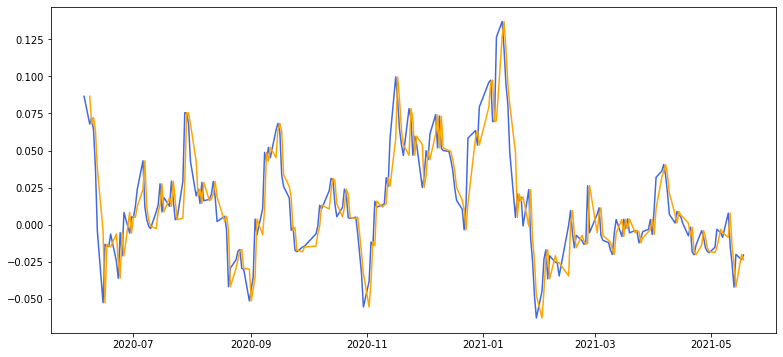

In [29]:
ts_log_moving_avg_shift = ts_log_moving_avg_15.shift()

fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(ts_log_moving_avg_15, color='royalblue')
ax.plot(ts_log_moving_avg_shift, color='orange')

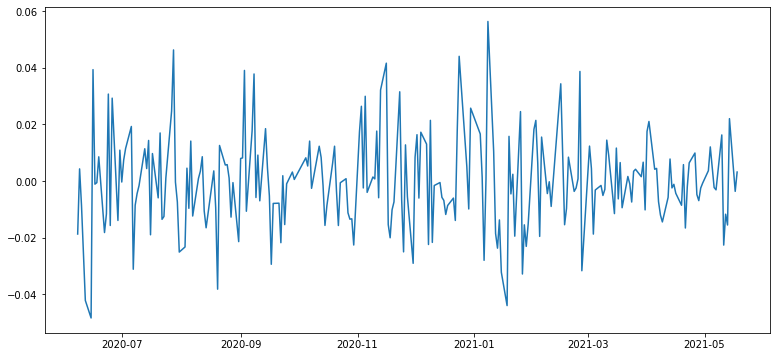

In [30]:
ts_log_moving_avg_diff = ts_log_moving_avg_15 - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)

fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(ts_log_moving_avg_diff)

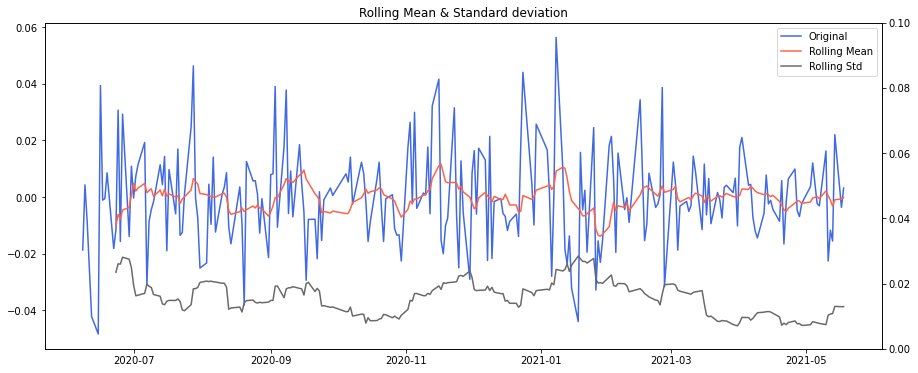

In [31]:
plot_rolling_statistics(ts_log_moving_avg_diff)

In [32]:
augmented_dickey_fuller_test(ts_log_moving_avg_diff)

Results of Dickey-Fuller Test: 
Test Statistic                -1.480242e+01
p-value                        2.089652e-27
#Lags Used                     0.000000e+00
Number of Observations Used    2.340000e+02
Critical value 1%             -3.458608e+00
Critical value 5%             -2.873972e+00
Critical value 10%            -2.573396e+00
dtype: float64


p-value가 사실상 0이라고 볼 수 있을만큼 작은 값이 됐습니다.

### (3) 시계열 분해(Time series decomposition)

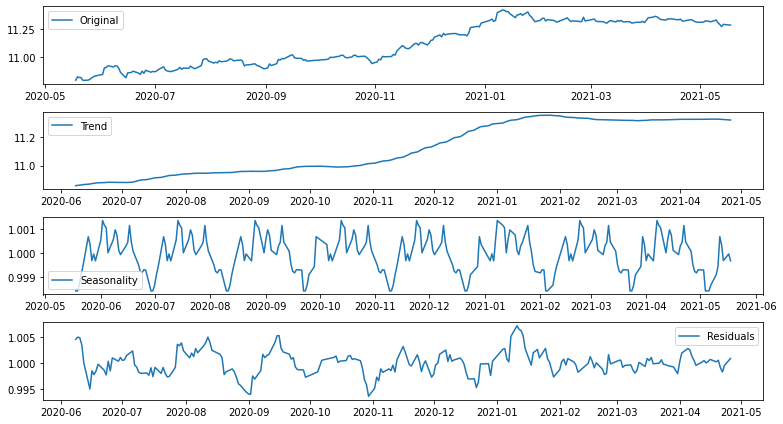

In [36]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates


decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30)

trend = decomposition.trend 
seasonal = decomposition.seasonal
residual = decomposition.resid

fig, axes = plt.subplots(figsize=(11, 6), nrows=4, ncols=1)
axs = axes.ravel()

axs[0].plot(ts_log, label='Original')
axs[0].legend(loc='best')

axs[1].plot(trend, label='Trend')
axs[1].legend(loc='best')

axs[2].plot(seasonal, label='Seasonality')
axs[2].legend(loc='best')
loc = mdates.MonthLocator(interval=1)
axs[2].xaxis.set_major_locator(loc)

axs[3].plot(residual, label='Residuals')
axs[3].legend(loc='best')

fig.tight_layout()

계절성(Seasonality)를 어떻게 해석해야 할 지가 의문입니다. 주기성은 보여주고 있지만 그 간격이 일정하지는 않은 것 같습니다. 조금 더 찾아봐야겠네요.

기존 시계열에서 Trend, Seasonality를 제거한 residual의 안정성을 체크해보겠습니다.

In [37]:
residual.isna().sum()

30

In [38]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test: 
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical value 1%             -3.461879e+00
Critical value 5%             -2.875404e+00
Critical value 10%            -2.574159e+00
dtype: float64


이번에도 아주 낮은 p-value값을 볼 수 있습니다.

## STEP 4: 학습, 테스트 데이터셋 생성

Train data's length: 225
Test data's length: 25


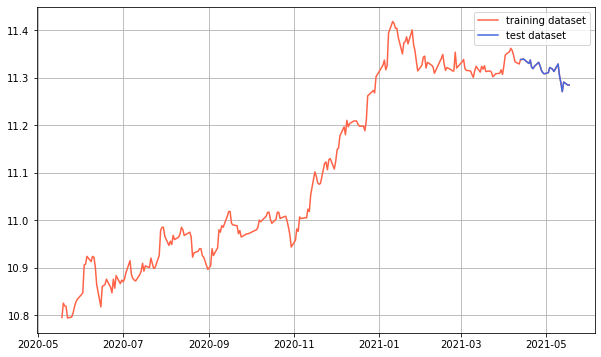

In [39]:
split_idx = int(len(ts_log) * 0.9)
train_data, test_data = ts_log[:split_idx], ts_log[split_idx:]

print(f"Train data's length: {len(train_data)}")
print(f"Test data's length: {len(test_data)}")

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(ts_log, c='tomato', label='training dataset') ## 전체 데이터셋을 이용해 그리면 자연스럽게 가능.
ax.plot(test_data, c='royalblue', label='test dataset')
ax.grid(True)
ax.legend()

## STEP 5: 적정 ARIMA 모수 찾기

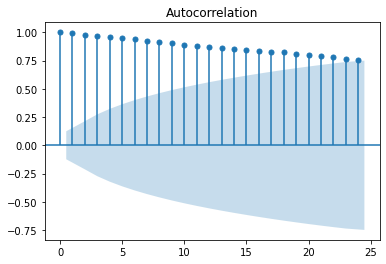

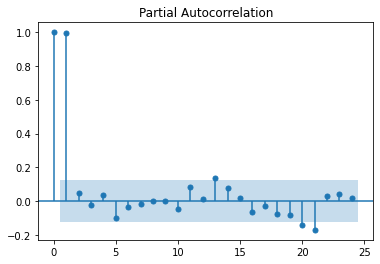

In [40]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)
plot_pacf(ts_log)

plt.show()

ACF는 별도의 절단점을 보이고 있지 않고 점차적으로 감소하고 있습니다. PACF의 경우 1 이후에 절단점을 보여주고 있습니다. **따라서 p=1이 적합함**을 알 수 있습니다. q의 적합한 값은 위 두 그래프로 파악하기는 쉽지 않습니다.

Results of Dickey-Fuller Test: 
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical value 1%             -3.456996e+00
Critical value 5%             -2.873266e+00
Critical value 10%            -2.573019e+00
dtype: float64


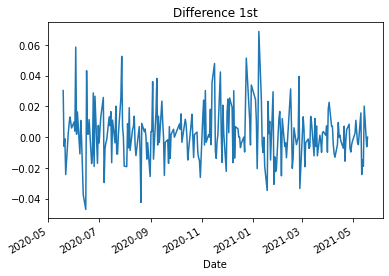

In [41]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test: 
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical value 1%             -3.457894e+00
Critical value 5%             -2.873659e+00
Critical value 10%            -2.573229e+00
dtype: float64


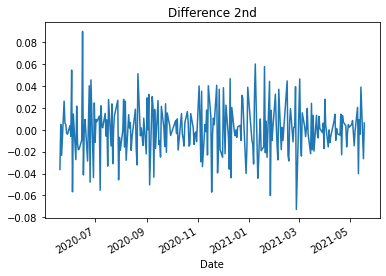

In [42]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

1차, 2차 차분 모두 아주 낮은 p-value를 보여주고 있습니다.

## STEP 6: ARIMA 모델 훈련과 테스트

위에서 p의 적합한 값으로는 1을 선정했습니다. 주가가 MA모델의 특성을 보이지 않는다고 가정하고 
1. (1) order = `(1, 1, 0)`
2. (2) order = `(1, 2, 0)`

에 대해 먼저 실험을 해보겠습니다.

### (1) `order = (1, 1, 0)`

In [43]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(train_data, order=(1, 1, 0)) ## p, d, q
fitted_m = model.fit(disp=-1)

print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  224
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 585.396
Method:                       css-mle   S.D. of innovations              0.018
Date:                Tue, 07 Sep 2021   AIC                          -1164.792
Time:                        08:34:25   BIC                          -1154.557
Sample:                             1   HQIC                         -1160.661
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0024      0.001      1.978      0.048    2.17e-05       0.005
ar.L1.D.Close     0.0168      0.067      0.250      0.803      -0.115       0.148
                                    Root

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

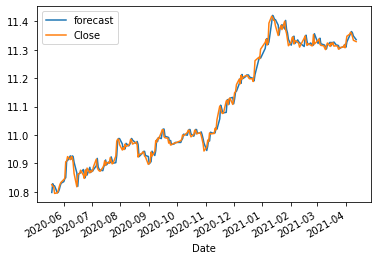

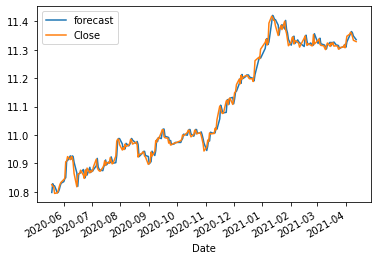

In [44]:
fitted_m.plot_predict()

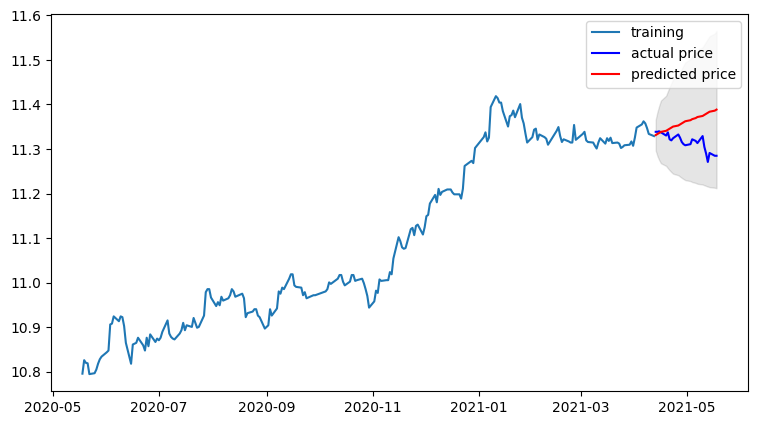

In [45]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
fig, ax = plt.subplots(figsize=(9, 5), dpi=100)
ax.plot(train_data, label='training')
ax.plot(test_data, c='b', label='actual price')
ax.plot(fc_series, c='r',label='predicted price')
ax.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
ax.legend()

In [46]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  22087366.126154922
MAE:  3791.3511527213127
RMSE:  4699.719792301976
MAPE: 4.68%


MAPE: 4.68% 값을 보이고 있습니다.

### (2) `order = (1, 2, 0)`

In [47]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(train_data, order=(1, 2, 0)) ## p, d, q
fitted_m = model.fit(disp=-1)

print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:               D2.Close   No. Observations:                  223
Model:                 ARIMA(1, 2, 0)   Log Likelihood                 535.977
Method:                       css-mle   S.D. of innovations              0.022
Date:                Tue, 07 Sep 2021   AIC                          -1065.954
Time:                        08:35:37   BIC                          -1055.732
Sample:                             2   HQIC                         -1061.827
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0001      0.001     -0.118      0.906      -0.002       0.002
ar.L1.D2.Close    -0.4759      0.059     -8.067      0.000      -0.591      -0.360
                                    

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

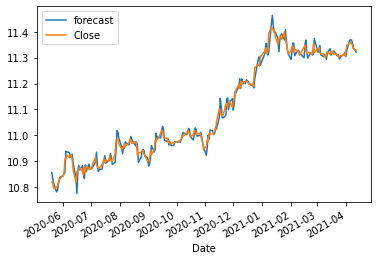

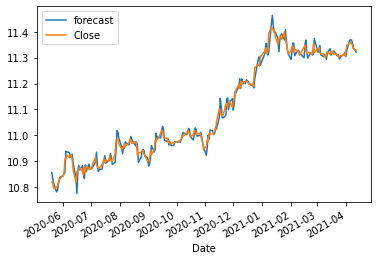

In [48]:
fitted_m.plot_predict()

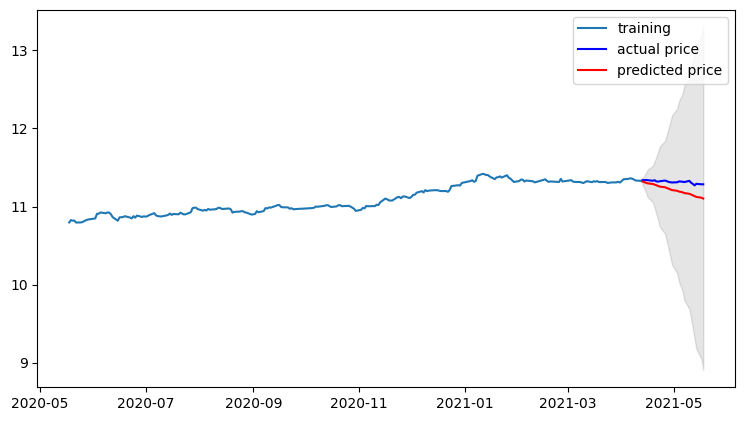

In [49]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
fig, ax = plt.subplots(figsize=(9, 5), dpi=100)
ax.plot(train_data, label='training')
ax.plot(test_data, c='b', label='actual price')
ax.plot(fc_series, c='r',label='predicted price')
ax.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
ax.legend()

In [50]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  70754398.26831636
MAE:  7601.062623954185
RMSE:  8411.563366480475
MAPE: 9.32%


MAPE가 9.32%로 올라간 모습을 보여주고 있습니다.

### (3) `order = (0, 1, 1)`

앞서 노드에서 시계열의 AR, MA 둘다의 특성을 드러내는 경우는 드물다고 하여 모수를 정할 때 $pq=0$ 이라는 조건하에 고르기도 한다고 했습니다.
따라서 이번에는 
1. (3) `order = (0, 1, 1)`
2. (4) `order = (0, 2, 1)`

로 실험을 진행해보겠습니다.

In [51]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(train_data, order = (0, 1, 1)) ## p, d, q
fitted_m = model.fit(disp=-1)

print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  224
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 585.398
Method:                       css-mle   S.D. of innovations              0.018
Date:                Tue, 07 Sep 2021   AIC                          -1164.796
Time:                        08:38:32   BIC                          -1154.561
Sample:                             1   HQIC                         -1160.664
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0024      0.001      1.977      0.048    2.02e-05       0.005
ma.L1.D.Close     0.0177      0.069      0.257      0.797      -0.117       0.153
                                    Root

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

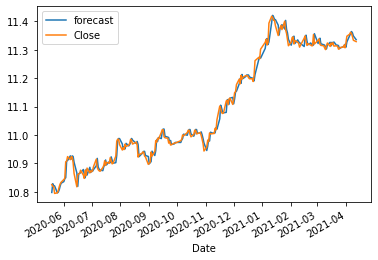

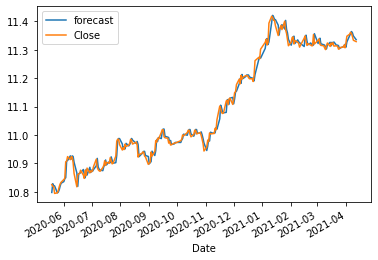

In [52]:
fitted_m.plot_predict()

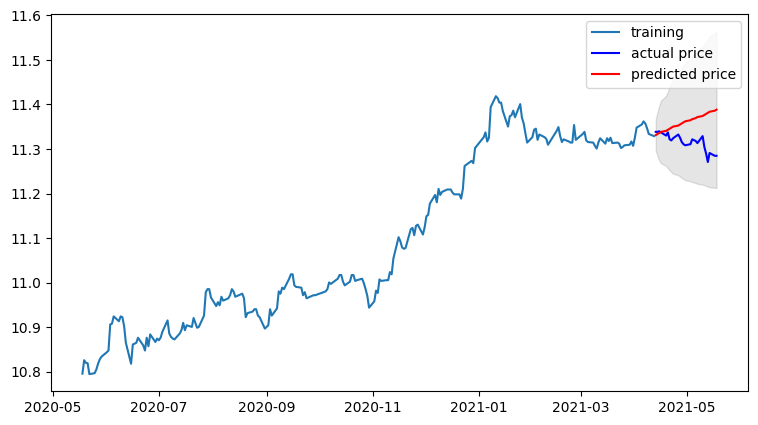

In [53]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
fig, ax = plt.subplots(figsize=(9, 5), dpi=100)
ax.plot(train_data, label='training')
ax.plot(test_data, c='b', label='actual price')
ax.plot(fc_series, c='r',label='predicted price')
ax.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
ax.legend()

In [54]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  22088457.65325718
MAE:  3791.4564135901687
RMSE:  4699.835917695125
MAPE: 4.68%


### (4) `order = (0, 2, 1)`

In [56]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(train_data, order=(0, 2, 1)) ## p, d, q
fitted_m = model.fit(disp=-1)

print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:               D2.Close   No. Observations:                  223
Model:                 ARIMA(0, 2, 1)   Log Likelihood                 579.611
Method:                       css-mle   S.D. of innovations              0.018
Date:                Tue, 07 Sep 2021   AIC                          -1153.222
Time:                        08:39:26   BIC                          -1143.000
Sample:                             2   HQIC                         -1149.095
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -6.569e-06   1.84e-05     -0.358      0.721   -4.26e-05    2.94e-05
ma.L1.D2.Close    -1.0000      0.014    -69.344      0.000      -1.028      -0.972
                                    

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

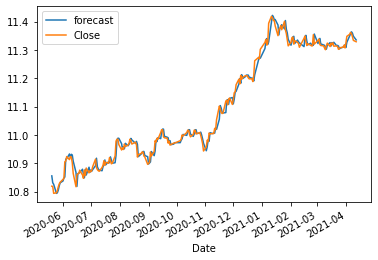

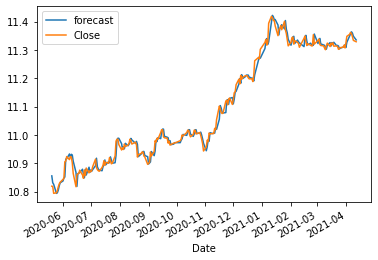

In [57]:
fitted_m.plot_predict()

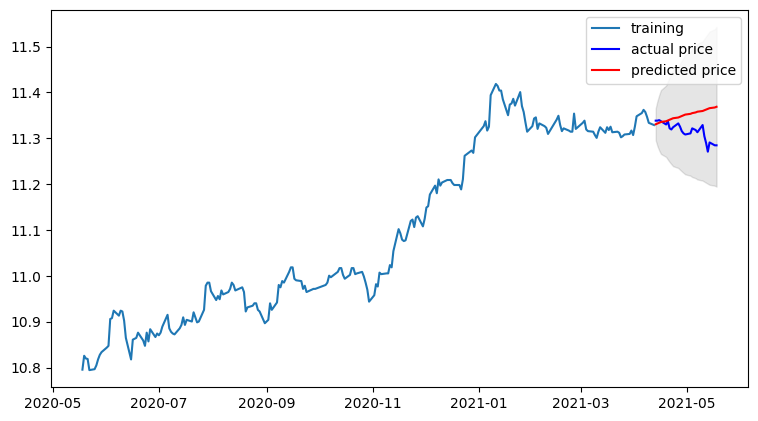

In [58]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
fig, ax = plt.subplots(figsize=(9, 5), dpi=100)
ax.plot(train_data, label='training')
ax.plot(test_data, c='b', label='actual price')
ax.plot(fc_series, c='r',label='predicted price')
ax.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
ax.legend()

In [59]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  13995261.469245058
MAE:  2984.2326059814095
RMSE:  3741.0241203773408
MAPE: 3.69%


3.69%로 가장 낮은 오차율을 보여주고 있습니다. 

q를 올리면 어떤 결과를 보여줄까요?

### (5) `order = (0, 2, 2)`


In [61]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(train_data, order = (0, 2, 2)) ## p, d, q
fitted_m = model.fit(disp=-1)

print(fitted_m.summary())

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

                             ARIMA Model Results                              
Dep. Variable:               D2.Close   No. Observations:                  223
Model:                 ARIMA(0, 2, 2)   Log Likelihood                 579.662
Method:                       css-mle   S.D. of innovations              0.018
Date:                Tue, 07 Sep 2021   AIC                          -1151.325
Time:                        08:41:28   BIC                          -1137.696
Sample:                             2   HQIC                         -1145.823
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -6.663e-06   1.88e-05     -0.355      0.722   -4.34e-05    3.01e-05
ma.L1.D2.Close    -0.9778      0.070    -13.926      0.000      -1.115      -0.840
ma.L2.D2.Close    -0.0221      0.069

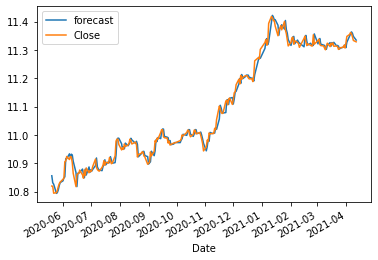

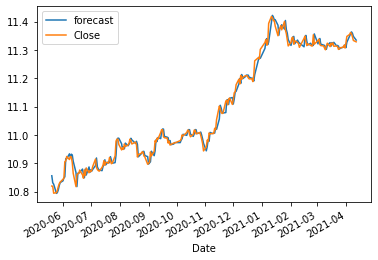

In [62]:
fitted_m.plot_predict()

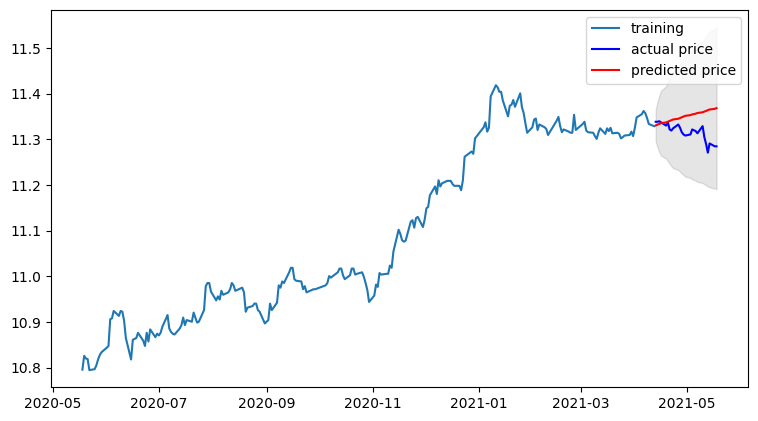

In [63]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
fig, ax = plt.subplots(figsize=(9, 5), dpi=100)
ax.plot(train_data, label='training')
ax.plot(test_data, c='b', label='actual price')
ax.plot(fc_series, c='r', label='predicted price')
ax.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
ax.legend()

In [64]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  13847246.0279913
MAE:  2967.081697863063
RMSE:  3721.1887923070094
MAPE: 3.66%


아주 작은 개선이지만 0.03% 오차율이 줄긴했습니다.

### (7) AUTOARIMA
다양한 모수 p, q, d에 대해 모든 경우의 수를 체크해 최적의 경우를 알아보기 위해 AUTOARIMA를 사용해보겠습니다.
AUTOARIMA는 결과로 AIC값과 BIC값에 대한 결과를 반환합니다. AIC, BIC의 수식은 각각 아래와 같습니다.

$$\text{AIC} = -2 \cdot \text{loglikelihood} + 2p$$

$$\text{BIC} = -2 \cdot \text{loglikelihood} + \log{n} \cdot p$$

두 경우 모두 likelihood를 가장 크게하는 동시에 변수 갯수는 가장 적게 하는 최적의 모델을 찾을 때 사용하는 기준으로, 일반적으로 $\log{n} \geq 2$ 이므로 더 적은 변수를 원한다면 최적의 BIC를 찾는 것이 더 좋습니다.

[reference](https://rk1993.tistory.com/entry/AIC-BIC-Mallows-Cp-%EC%89%BD%EA%B2%8C-%EC%9D%B4%ED%95%B4%ED%95%98%EA%B8%B0)

[reference2](https://kimginam1995.tistory.com/557)

In [68]:
!pip install pmdarima

     |████████████████████████████████| 1.5 MB 6.3 MB/s eta 0:00:01
     |████████████████████████████████| 2.0 MB 63.3 MB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [78]:
from pmdarima.arima import auto_arima

> d : int, optional (default=None)
The order of first-differencing. If None (by default), the value will automatically be selected based on the results of the test (i.e., either the Kwiatkowski–Phillips–Schmidt–Shin, Augmented Dickey-Fuller or the Phillips–Perron test will be conducted to find the most probable value). Must be a positive integer or None. Note that if d is None, the runtime could be significantly longer.

d를 고르지 않으면 위에서 언급한 test를 통해 자동으로 선택된다고 하니 각각 d=1, d=2일 때를 나누어 실험을 진행해보겠습니다. auto_arima를 통해 위에서 찾았던 `order=(0, 2, 2)`의 경우보다 더 좋은 경우가 있는 지 체크하는 것이 목표이기 때문입니다.

#### (a) `d = 1`

In [87]:
model_arima = auto_arima(train_data ,trace=True, error_action='ignore', 
                        start_p=0, start_q=0, d=1, max_p=3, max_q=3,
                        suppress_warnings=True, stepwise=False, seasonal=False)

model_arima.fit(train_data)

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1166.730, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1164.794, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1162.950, Time=0.11 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-1161.615, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1164.792, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1162.816, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1160.940, Time=0.10 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-1159.493, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-1162.974, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1160.969, Time=0.16 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1159.385, Time=0.40 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-1157.597, Time=0.46 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-1161.558, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-1159.560, Time=0.12 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-1157.224, Time=0.21

ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True)

AUTOARIMA는 결과로 (0, 1, 0), 즉 1차 차분만 한 시계열을 가장 좋은 결과로 반환하고 있습니다.

In [80]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(train_data, order = (0, 1, 0)) ## p, d, q
fitted_m = model.fit(disp=-1)

print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  224
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 585.365
Method:                           css   S.D. of innovations              0.018
Date:                Tue, 07 Sep 2021   AIC                          -1166.730
Time:                        10:05:09   BIC                          -1159.906
Sample:                             1   HQIC                         -1163.975
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.001      2.010      0.044    5.92e-05       0.005


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

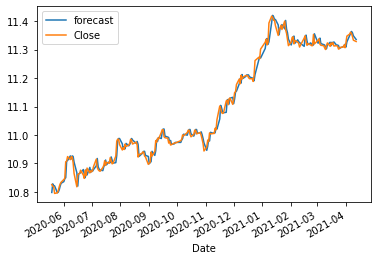

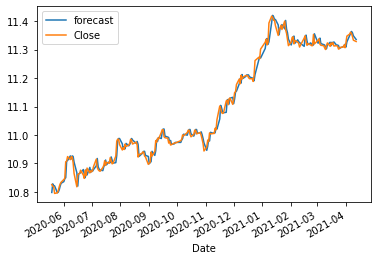

In [81]:
fitted_m.plot_predict()

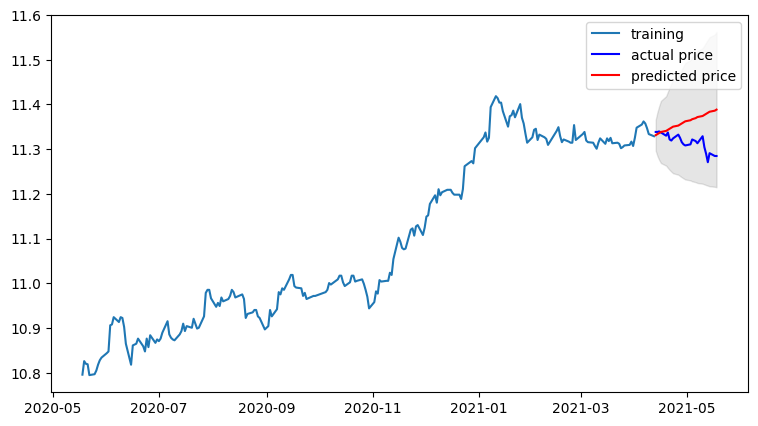

In [82]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
fig, ax = plt.subplots(figsize=(9, 5), dpi=100)
ax.plot(train_data, label='training')
ax.plot(test_data, c='b', label='actual price')
ax.plot(fc_series, c='r', label='predicted price')
ax.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
ax.legend()

In [77]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  22147137.751086995
MAE:  3797.696275515896
RMSE:  4706.074558598386
MAPE: 4.69%


d = 1 인 경우 최적으로 나온 (0, 1, 0)의 경우, (0, 2, 2)보다 좋지 않은 MAPE를 보이고 있습니다.

#### (b) `d = 2`

In [88]:
model_arima = auto_arima(train_data ,trace=True, error_action='ignore', 
                        start_p=0, start_q=0, d=2, max_p=3, max_q=3,
                        suppress_warnings=True, stepwise=False, seasonal=False)

model_arima.fit(train_data)

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-1011.021, Time=0.05 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=-1137.461, Time=0.07 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=-1148.225, Time=0.21 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-1065.952, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=-1141.943, Time=0.35 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=-1086.019, Time=0.04 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=-1139.993, Time=0.22 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=-1143.546, Time=0.43 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=-1101.195, Time=0.05 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=-1141.977, Time=0.43 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=-1143.802, Time=0.53 sec

Best model:  ARIMA

ARIMA(order=(0, 2, 3), scoring_args={}, suppress_warnings=True)

AUTOARIMA는 결과로 (0, 2, 3)을 가장 좋은 결과로 반환하고 있습니다.

In [93]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(train_data, order = (0, 2, 3)) ## p, d, q
fitted_m = model.fit(disp=-1)

print(fitted_m.summary())

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

                             ARIMA Model Results                              
Dep. Variable:               D2.Close   No. Observations:                  223
Model:                 ARIMA(0, 2, 3)   Log Likelihood                 579.713
Method:                       css-mle   S.D. of innovations              0.018
Date:                Tue, 07 Sep 2021   AIC                          -1149.426
Time:                        10:15:00   BIC                          -1132.390
Sample:                             2   HQIC                         -1142.549
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -6.546e-06   1.83e-05     -0.358      0.721   -4.24e-05    2.93e-05
ma.L1.D2.Close    -0.9780      0.069    -14.156      0.000      -1.113      -0.843
ma.L2.D2.Close    -0.0467      0.089

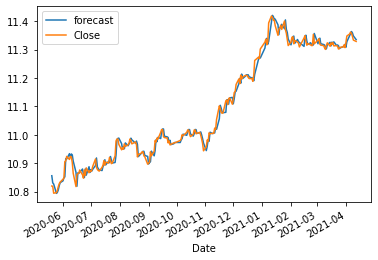

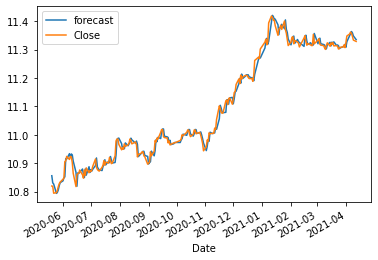

In [94]:
fitted_m.plot_predict()

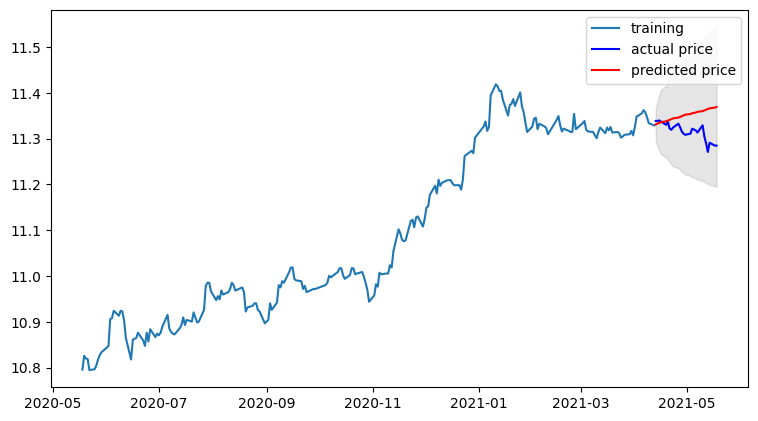

In [95]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
fig, ax = plt.subplots(figsize=(9, 5), dpi=100)
ax.plot(train_data, label='training')
ax.plot(test_data, c='b', label='actual price')
ax.plot(fc_series, c='r', label='predicted price')
ax.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
ax.legend()

In [96]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  14191217.582180506
MAE:  3007.948753266021
RMSE:  3767.123250197756
MAPE: 3.71%


MAPE가 (0, 2, 2)의 경우보다 0.05% 정도 더 안 좋은 결과를 보이고 있긴 하지만 큰 차이는 아닌 것 같습니다.

차분이 2이고 q가 커질 수록 성능이 좋아질 수도 있을 것 같아(AIC가 낮게 나와) 추가적으로 실험을 해보겠습니다.

#### (c) d = 2, q = 2, 3, 4, ...

In [99]:
model_arima = auto_arima(train_data ,trace=True, error_action='ignore', 
                        start_p=0, start_q=0, d=2, max_p=5, max_q=5,
                        suppress_warnings=True, stepwise=False, seasonal=False)

model_arima.fit(train_data)

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-1011.021, Time=0.05 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=-1137.461, Time=0.07 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=-1148.225, Time=0.21 sec
 ARIMA(0,2,4)(0,0,0)[0] intercept   : AIC=-1141.071, Time=0.26 sec
 ARIMA(0,2,5)(0,0,0)[0] intercept   : AIC=-1140.981, Time=0.55 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-1065.952, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=-1141.943, Time=0.33 sec
 ARIMA(1,2,4)(0,0,0)[0] intercept   : AIC=-1142.570, Time=0.48 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=-1086.019, Time=0.04 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=-1139.993, Time=0.25 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=-1143.546, Time=0.48 sec
 ARIMA(3,2,0)(0,0,0

ARIMA(order=(0, 2, 3), scoring_args={}, suppress_warnings=True)

q가 무조건 큰 것 보다는 (0, 2, 3) 일 때가 최적임을 알 수 있었습니다.

# 다른 주식 종목 예측해 보기1 - QQQ

pandas datareader를 이용해 다른 주식 종목의 데이터를 가져와 위의 과정을 반복하며 확인해보겠습니다.

In [100]:
!pip install pandas-datareader

     |████████████████████████████████| 109 kB 6.5 MB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


개별종목보다는 비교적 안정적일 수 있는 나스닥 100 지수를 추종하는 ETF(QQQ)의 주가를 예측 해보겠습니다.

## STEP 1: 시계열 데이터 준비

In [101]:
import pandas_datareader as pdr

df = pdr.DataReader('QQQ', 'yahoo')

In [102]:
df.head()

High         Low        Open       Close      Volume  \
Date                                                                     
2016-09-08  117.599998  116.919998  117.570000  117.230003  20125300.0   
2016-09-09  116.510002  114.260002  116.250000  114.279999  50813300.0   
2016-09-12  116.489998  113.629997  113.639999  116.330002  39646000.0   
2016-09-13  116.089996  114.730003  115.750000  115.290001  45863900.0   
2016-09-14  116.470001  115.379997  115.410004  115.839996  28221800.0   

             Adj Close  
Date                    
2016-09-08  112.717979  
2016-09-09  109.881538  
2016-09-12  111.852638  
2016-09-13  110.852654  
2016-09-14  111.381477

In [103]:
ts = df['Close']
ts.head()

Date
2016-09-08    117.230003
2016-09-09    114.279999
2016-09-12    116.330002
2016-09-13    115.290001
2016-09-14    115.839996
Name: Close, dtype: float64

## STEP 2: 각종 전처리 수행

In [104]:
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

원래도 결측치가 없지만, 보간법을 한번 사용해보겠습니다.

In [105]:
ts = ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

Text(0.5, 1.0, 'Closing price of QQQ')

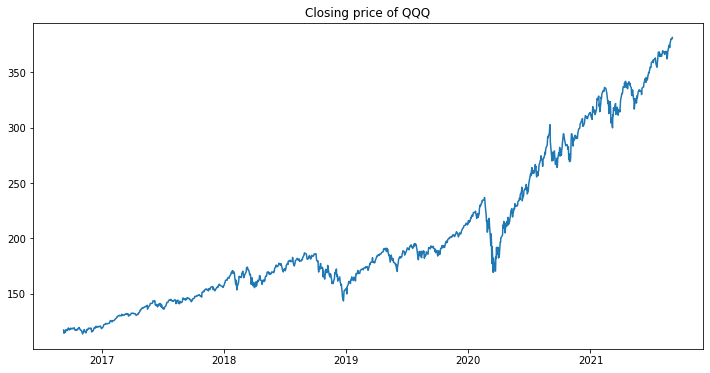

In [106]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(ts)
ax.set_title("Closing price of QQQ")

로그 변환을 진행해보겠습니다.

Text(0.5, 1.0, 'Closing price(Log) of QQQ')

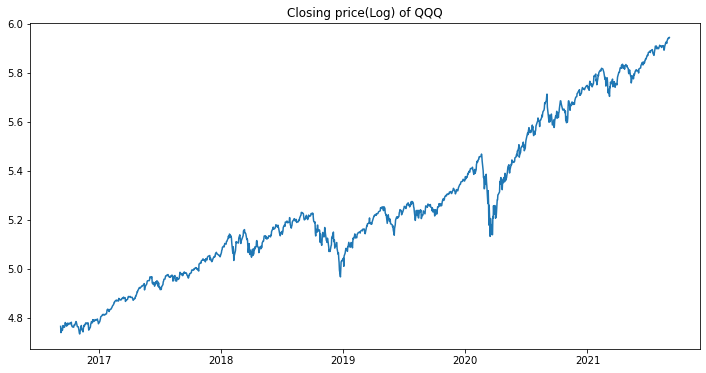

In [107]:
ts_log = np.log(ts)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(ts_log)
ax.set_title("Closing price(Log) of QQQ")

## STEP 3: 시계열 안정성 분석

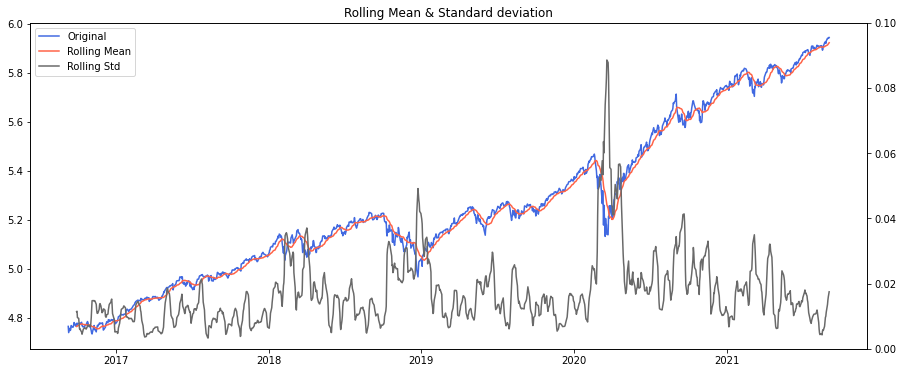

In [114]:
plot_rolling_statistics(ts_log, window=15)

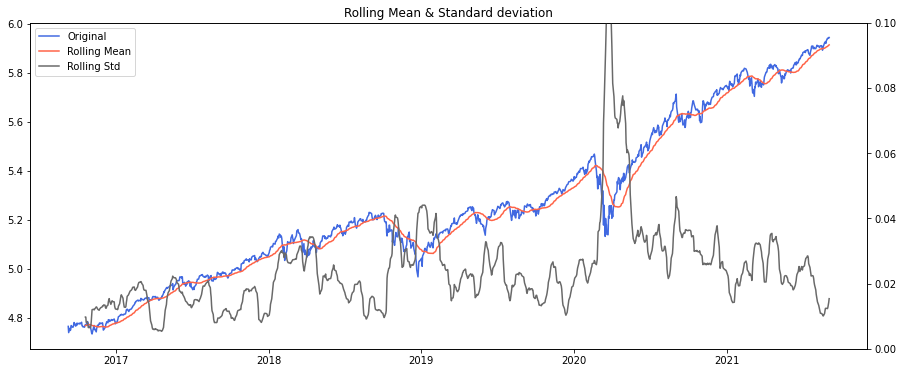

In [115]:
plot_rolling_statistics(ts_log, window=30)

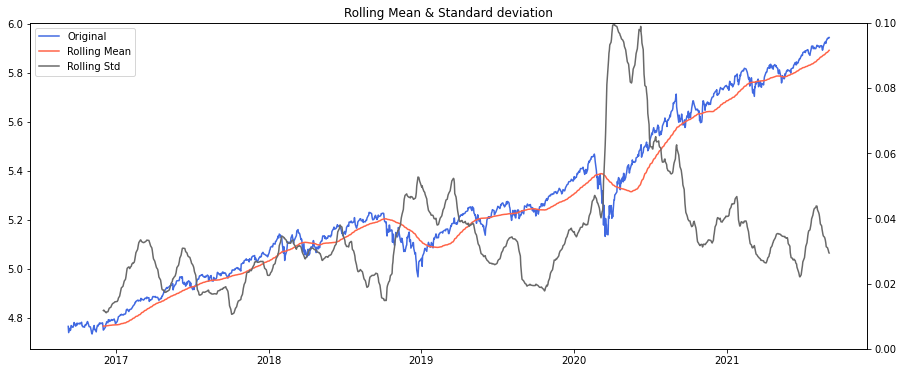

In [116]:
plot_rolling_statistics(ts_log, window=60)

각각 15, 30, 60일로 그림을 그리고 이동평균선, 이동표준편차선을 확인해보면 일정하지 않고 원래 그래프에 따라 상승하는 모습을 보입니다. 통계적으로도 확인해보기 위해  `augmented_dickey_fuller_test` 를 사용하겠습니다.

In [113]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test: 
Test Statistic                    0.156231
p-value                           0.969697
#Lags Used                        9.000000
Number of Observations Used    1247.000000
Critical value 1%                -3.435605
Critical value 5%                -2.863861
Critical value 10%               -2.568005
dtype: float64


유의수준값이 0.9으로 아직도 매우 높습니다. 따라서 별도의 전처리를 추가적으로 진행해주겠습니다.

### (1) Moving average 제거 - 추세(Trend) 상쇄하기

위에서 확인 15, 30, 60일 이동평균을 삭제하여 추세를 상쇄시킨 시계열 데이터를 각각 구하고 시각화를 해보고 통계적으로도 변화가 있는 지 확인해보겠습니다.

#### (a) 15일 이동평균 삭제

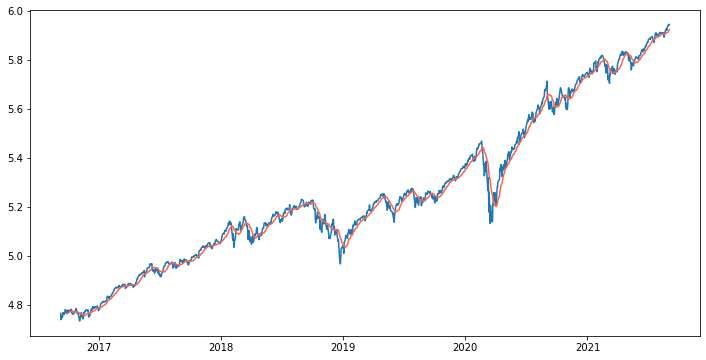

In [117]:
moving_avg_15 = ts_log.rolling(window=15).mean()  # moving average구하기
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(ts_log)
ax.plot(moving_avg_15, color='tomato')

In [118]:
ts_log_moving_avg_15 = ts_log - moving_avg_15 # 변화량 제거
ts_log_moving_avg_15.dropna(inplace=True)
ts_log_moving_avg_15.head(15)

Date
2016-09-28    0.012898
2016-09-29    0.005280
2016-09-30    0.010179
2016-10-03    0.007486
2016-10-04    0.004209
2016-10-05    0.006074
2016-10-06    0.004954
2016-10-07    0.002094
2016-10-10    0.007027
2016-10-11   -0.007631
2016-10-12   -0.008069
2016-10-13   -0.010472
2016-10-14   -0.008602
2016-10-17   -0.011042
2016-10-18   -0.001818
Name: Close, dtype: float64

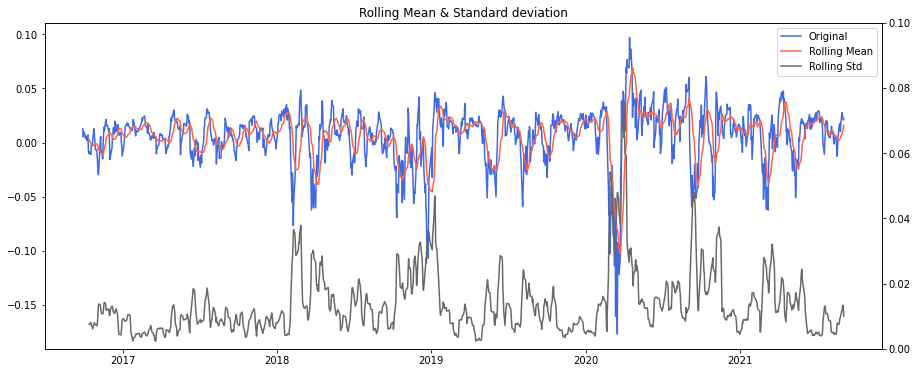

In [119]:
plot_rolling_statistics(ts_log_moving_avg_15)

In [120]:
augmented_dickey_fuller_test(ts_log_moving_avg_15)

Results of Dickey-Fuller Test: 
Test Statistic                -8.131381e+00
p-value                        1.087912e-12
#Lags Used                     1.800000e+01
Number of Observations Used    1.224000e+03
Critical value 1%             -3.435704e+00
Critical value 5%             -2.863904e+00
Critical value 10%            -2.568029e+00
dtype: float64


p-value가 0에 가까운 아주 작은 값으로 떨어진 것을 확인할 수 있습니다.

#### (b) 30일 이동평균 삭제

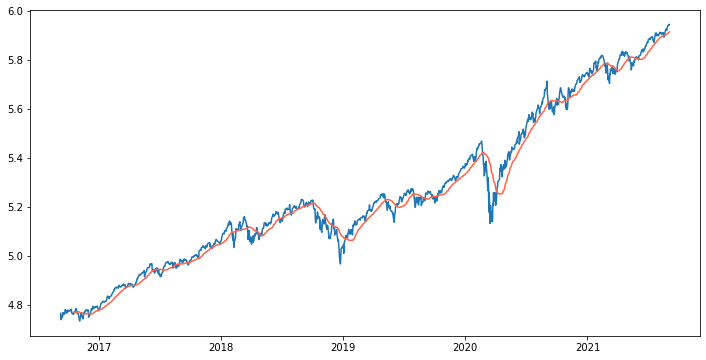

In [121]:
moving_avg_30 = ts_log.rolling(window=30).mean()  # moving average구하기
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(ts_log)
ax.plot(moving_avg_30, color='tomato')

In [122]:
ts_log_moving_avg_30 = ts_log - moving_avg_30 # 변화량 제거
ts_log_moving_avg_30.dropna(inplace=True)
ts_log_moving_avg_30.head(15)

Date
2016-10-19    0.002144
2016-10-20    0.000819
2016-10-21    0.003440
2016-10-24    0.014471
2016-10-25    0.010179
2016-10-26    0.002637
2016-10-27   -0.001992
2016-10-28   -0.008237
2016-10-31   -0.009237
2016-11-01   -0.016533
2016-11-02   -0.023726
2016-11-03   -0.032144
2016-11-04   -0.034312
2016-11-07   -0.010550
2016-11-08   -0.003646
Name: Close, dtype: float64

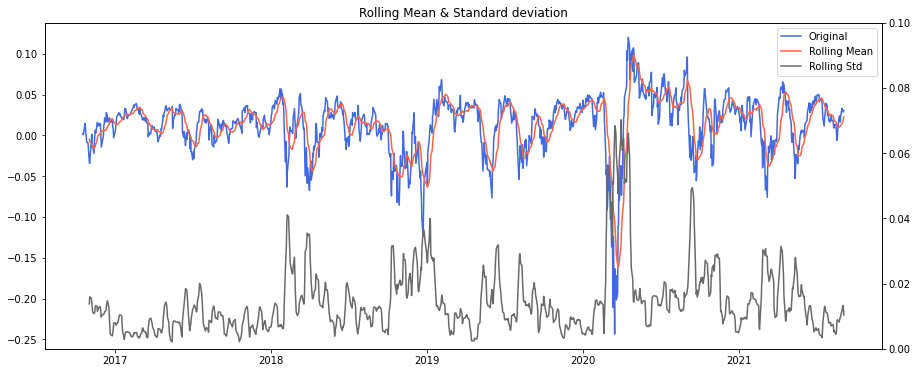

In [123]:
plot_rolling_statistics(ts_log_moving_avg_30)

In [124]:
augmented_dickey_fuller_test(ts_log_moving_avg_30)

Results of Dickey-Fuller Test: 
Test Statistic                -7.081276e+00
p-value                        4.659531e-10
#Lags Used                     9.000000e+00
Number of Observations Used    1.218000e+03
Critical value 1%             -3.435730e+00
Critical value 5%             -2.863916e+00
Critical value 10%            -2.568035e+00
dtype: float64


p-value가 0에 가깝습니다.

#### (c) 60일 이동평균 삭제

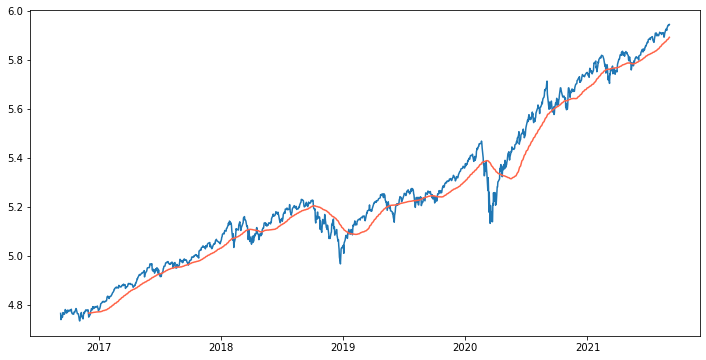

In [125]:
moving_avg_60 = ts_log.rolling(window=60).mean()  # moving average구하기
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(ts_log)
ax.plot(moving_avg_60, color='tomato')

In [126]:
ts_log_moving_avg_60 = ts_log - moving_avg_60 # 변화량 제거
ts_log_moving_avg_60.dropna(inplace=True)
ts_log_moving_avg_60.head(15)

Date
2016-12-01   -0.016311
2016-12-02   -0.014103
2016-12-05   -0.006689
2016-12-06   -0.004369
2016-12-07    0.007776
2016-12-08    0.009160
2016-12-09    0.016712
2016-12-12    0.011947
2016-12-13    0.023961
2016-12-14    0.021432
2016-12-15    0.022697
2016-12-16    0.015959
2016-12-19    0.019801
2016-12-20    0.023175
2016-12-21    0.022155
Name: Close, dtype: float64

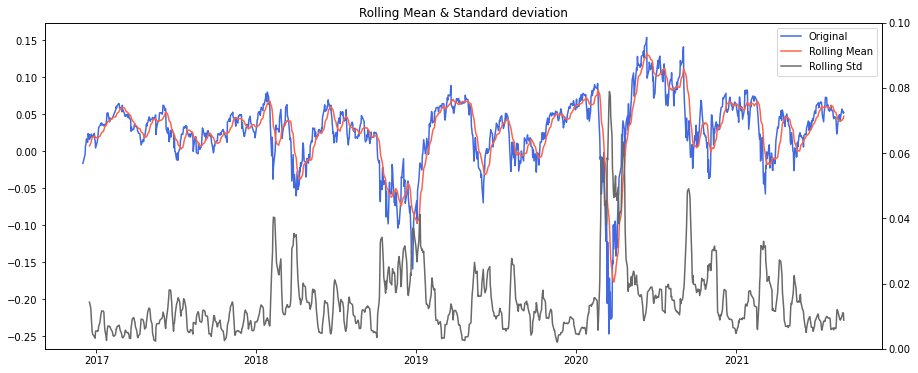

In [127]:
plot_rolling_statistics(ts_log_moving_avg_60)

In [128]:
augmented_dickey_fuller_test(ts_log_moving_avg_60)

Results of Dickey-Fuller Test: 
Test Statistic                   -4.947599
p-value                           0.000028
#Lags Used                        9.000000
Number of Observations Used    1188.000000
Critical value 1%                -3.435866
Critical value 5%                -2.863976
Critical value 10%               -2.568067
dtype: float64


p-value가 0.000028입니다

p-value가 가장 작은 15일 이동평균을 삭제한 `ts_log_moving_avg_15`를 사용하도록 하겠습니다.

### (2) 차분(Differencing) - 계절성(Seasonality) 상쇄하기
이동평균의 삭제로 잡히지 않는 시계열 데이터의 주기성들을 확인해보기 위해 계절성을 체크해보겠습니다.

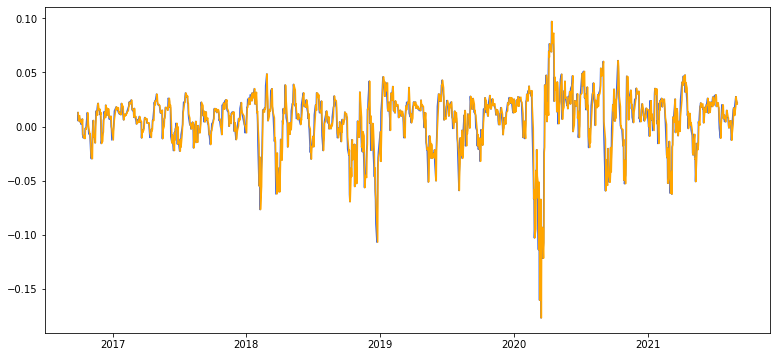

In [129]:
ts_log_moving_avg_shift = ts_log_moving_avg_15.shift()

fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(ts_log_moving_avg_15, color='royalblue')
ax.plot(ts_log_moving_avg_shift, color='orange')

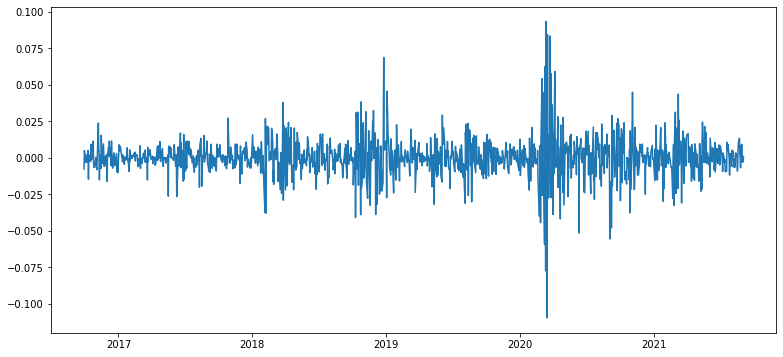

In [130]:
ts_log_moving_avg_diff = ts_log_moving_avg_15 - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)

fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(ts_log_moving_avg_diff)

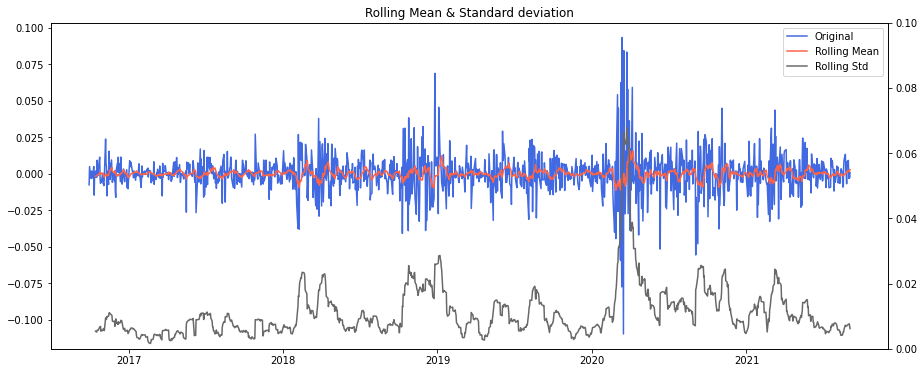

In [131]:
plot_rolling_statistics(ts_log_moving_avg_diff)

In [132]:
augmented_dickey_fuller_test(ts_log_moving_avg_diff)

Results of Dickey-Fuller Test: 
Test Statistic                -1.072979e+01
p-value                        3.000239e-19
#Lags Used                     2.300000e+01
Number of Observations Used    1.218000e+03
Critical value 1%             -3.435730e+00
Critical value 5%             -2.863916e+00
Critical value 10%            -2.568035e+00
dtype: float64


p-value가 사실상 0이라고 볼 수 있을만큼 작은 값이 됐습니다.

### (3) 시계열 분해(Time series decomposition)

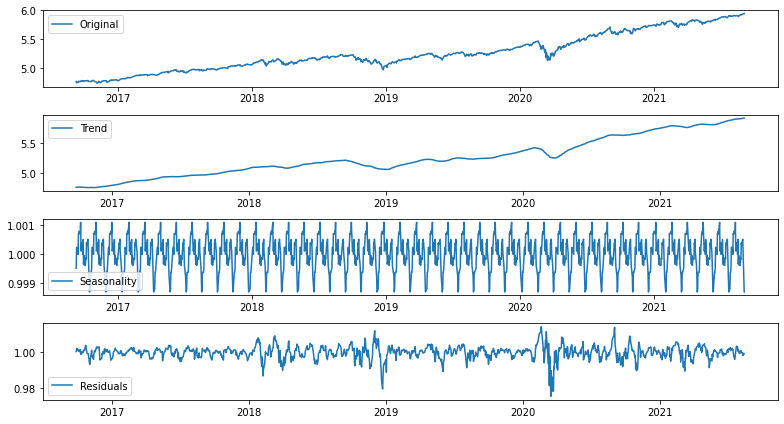

In [151]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates


decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30)

trend = decomposition.trend 
seasonal = decomposition.seasonal
residual = decomposition.resid

fig, axes = plt.subplots(figsize=(11, 6), nrows=4, ncols=1)
axs = axes.ravel()

axs[0].plot(ts_log, label='Original')
axs[0].legend(loc='best')

axs[1].plot(trend, label='Trend')
axs[1].legend(loc='best')

axs[2].plot(seasonal, label='Seasonality')
axs[2].legend(loc='best')

axs[3].plot(residual, label='Residuals')
axs[3].legend(loc='best')

fig.tight_layout()

계절성(Seasonality)를 어떻게 해석해야 할 지가 의문입니다. 주기성은 보여주고 있지만 그 간격이 일정하지는 않은 것 같습니다. 조금 더 찾아봐야겠네요.

기존 시계열에서 Trend, Seasonality를 제거한 residual의 안정성을 체크해보겠습니다.

In [134]:
residual.isna().sum()

30

In [135]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test: 
Test Statistic                -1.068571e+01
p-value                        3.838259e-19
#Lags Used                     2.100000e+01
Number of Observations Used    1.205000e+03
Critical value 1%             -3.435788e+00
Critical value 5%             -2.863942e+00
Critical value 10%            -2.568049e+00
dtype: float64


이번에도 아주 낮은 p-value값을 볼 수 있습니다.

## STEP 4: 학습, 테스트 데이터셋 생성

Train data's length: 1131
Test data's length: 126


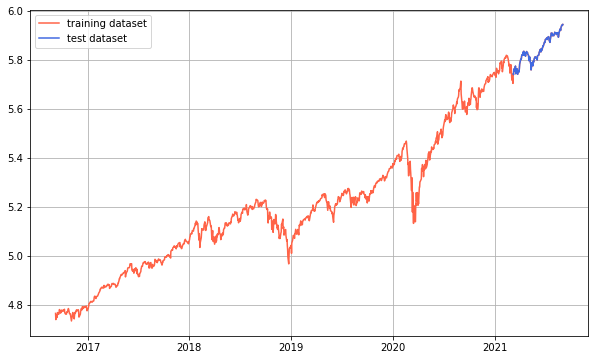

In [136]:
split_idx = int(len(ts_log) * 0.9)
train_data, test_data = ts_log[:split_idx], ts_log[split_idx:]

print(f"Train data's length: {len(train_data)}")
print(f"Test data's length: {len(test_data)}")

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(ts_log, c='tomato', label='training dataset') ## 전체 데이터셋을 이용해 그리면 자연스럽게 가능.
ax.plot(test_data, c='royalblue', label='test dataset')
ax.grid(True)
ax.legend()

## STEP 5: 적정 ARIMA 모수 찾기

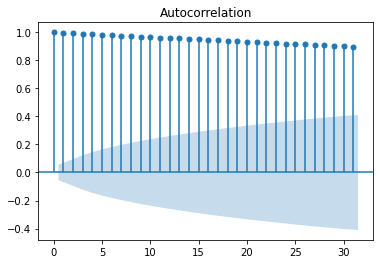

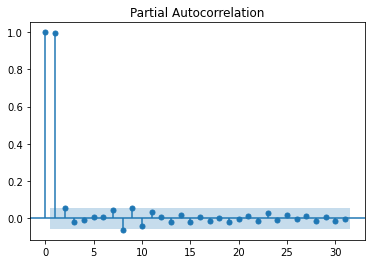

In [137]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)
plot_pacf(ts_log)

plt.show()

이번에도 그래프를 통해 **p=1이 적합함**만을 알 수 있습니다. q의 적합한 값은 위 두 그래프로 파악하기는 쉽지 않습니다.

Results of Dickey-Fuller Test: 
Test Statistic                -1.160580e+01
p-value                        2.583015e-21
#Lags Used                     8.000000e+00
Number of Observations Used    1.247000e+03
Critical value 1%             -3.435605e+00
Critical value 5%             -2.863861e+00
Critical value 10%            -2.568005e+00
dtype: float64


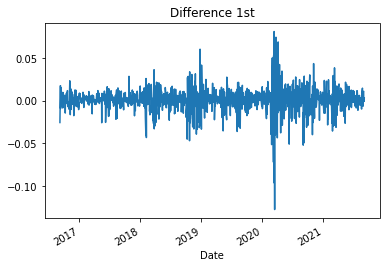

In [138]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test: 
Test Statistic                -1.567745e+01
p-value                        1.486830e-28
#Lags Used                     1.600000e+01
Number of Observations Used    1.238000e+03
Critical value 1%             -3.435643e+00
Critical value 5%             -2.863877e+00
Critical value 10%            -2.568014e+00
dtype: float64


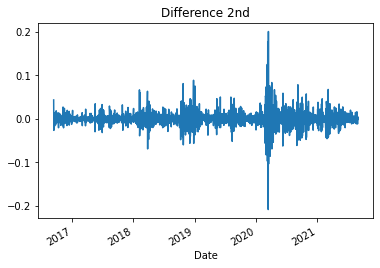

In [139]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

1차, 2차 차분 모두 아주 낮은 p-value를 보여주고 있습니다.

## STEP 6: ARIMA 모델 훈련과 테스트

이번에는 바로 AUTOARIMA를 사용하며 실험을 진행해보겠습니다. 실험 방식은 위와 비슷하게 d=1, d=2인 경우로 나눠 진행해보겠습니다.

### (1) `d = 1`

In [140]:
model_arima = auto_arima(train_data ,trace=True, error_action='ignore', 
                        start_p=0, start_q=0, d=1, max_p=5, max_q=5,
                        suppress_warnings=True, stepwise=False, seasonal=False)

model_arima.fit(train_data)

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6373.700, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6420.553, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-6430.095, Time=0.15 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-6428.214, Time=0.38 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-6427.610, Time=0.88 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=-6425.685, Time=1.87 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6428.183, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-6427.749, Time=0.33 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-6427.312, Time=0.54 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-6426.196, Time=1.26 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-6425.776, Time=1.82 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-6428.489, Time=0.28 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-6422.137, Time=0.30 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-6426.476, Time=0.37 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-6423.855, Time=0.82

ARIMA(order=(0, 1, 2), scoring_args={}, suppress_warnings=True)

AUTOARIMA는 결과로 (0, 1, 2)을 가장 좋은 결과로 반환하고 있습니다.

In [141]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(train_data, order = (0, 1, 2)) ## p, d, q
fitted_m = model.fit(disp=-1)

print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1130
Model:                 ARIMA(0, 1, 2)   Log Likelihood                3219.099
Method:                       css-mle   S.D. of innovations              0.014
Date:                Tue, 07 Sep 2021   AIC                          -6430.197
Time:                        10:40:54   BIC                          -6410.077
Sample:                             1   HQIC                         -6422.596
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0008      0.000      2.256      0.024       0.000       0.002
ma.L1.D.Close    -0.2120      0.030     -7.182      0.000      -0.270      -0.154
ma.L2.D.Close     0.1033      0.031     

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

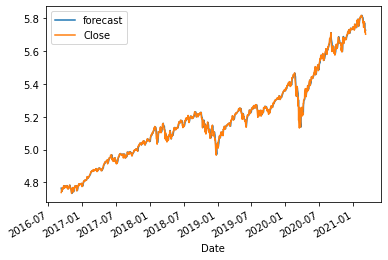

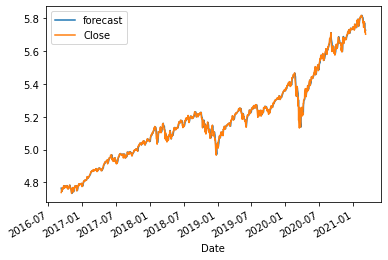

In [142]:
fitted_m.plot_predict()

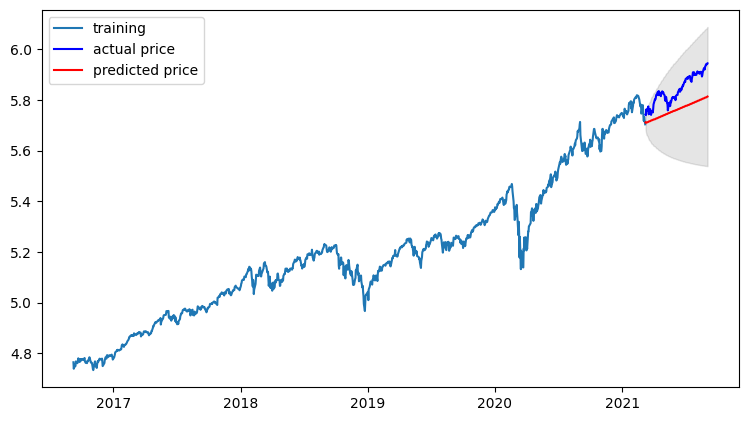

In [143]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
fig, ax = plt.subplots(figsize=(9, 5), dpi=100)
ax.plot(train_data, label='training')
ax.plot(test_data, c='b', label='actual price')
ax.plot(fc_series, c='r', label='predicted price')
ax.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
ax.legend()

In [144]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  845.2773766086569
MAE:  26.889771741341484
RMSE:  29.07365433874209
MAPE: 7.65%


MAPE: 7.65%를 보이고 있습니다.

### (2) `d = 2`

In [145]:
model_arima = auto_arima(train_data ,trace=True, error_action='ignore', 
                        start_p=0, start_q=0, d=2, max_p=5, max_q=5,
                        suppress_warnings=True, stepwise=False, seasonal=False)

model_arima.fit(train_data)

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-5362.939, Time=0.11 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-6324.525, Time=0.22 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=-6286.246, Time=0.24 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=-6366.661, Time=0.71 sec
 ARIMA(0,2,4)(0,0,0)[0] intercept   : AIC=-6355.269, Time=2.12 sec
 ARIMA(0,2,5)(0,0,0)[0] intercept   : AIC=-6378.790, Time=1.34 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-5924.265, Time=0.11 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.53 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=-6356.191, Time=1.45 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.83 sec
 ARIMA(1,2,4)(0,0,0)[0] intercept   : AIC=-6399.727, Time=1.10 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=-6102.512, Time=0.11 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=-6365.956, Time=0.96 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.56 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.40 sec
 ARIMA(3,2,0)(0,0,0

ARIMA(order=(1, 2, 4), scoring_args={}, suppress_warnings=True)

AUTOARIMA는 결과로 (1, 2, 4)을 가장 좋은 결과로 반환하고 있습니다.

In [146]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(train_data, order = (1, 2, 4)) ## p, d, q
fitted_m = model.fit(disp=-1)

print(fitted_m.summary())

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

                             ARIMA Model Results                              
Dep. Variable:               D2.Close   No. Observations:                 1129
Model:                 ARIMA(1, 2, 4)   Log Likelihood                3222.157
Method:                       css-mle   S.D. of innovations              0.014
Date:                Tue, 07 Sep 2021   AIC                          -6430.314
Time:                        10:42:46   BIC                          -6395.111
Sample:                             2   HQIC                         -6417.013
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           8.308e-08   3.86e-06      0.022      0.983   -7.48e-06    7.65e-06
ar.L1.D2.Close    -0.9009      0.028    -32.137      0.000      -0.956      -0.846
ma.L1.D2.Close    -0.2582      0.053

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


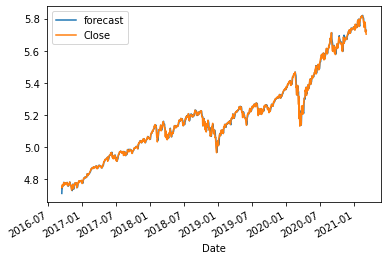

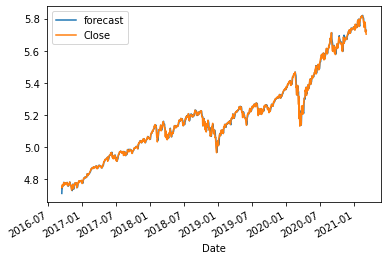

In [147]:
fitted_m.plot_predict()

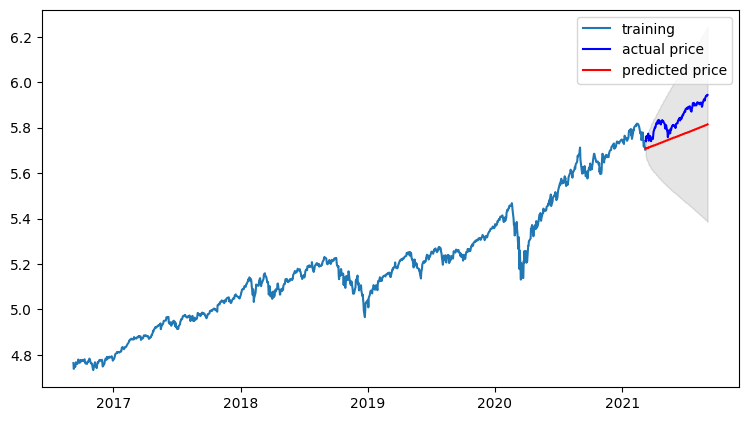

In [148]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
fig, ax = plt.subplots(figsize=(9, 5), dpi=100)
ax.plot(train_data, label='training')
ax.plot(test_data, c='b', label='actual price')
ax.plot(fc_series, c='r', label='predicted price')
ax.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
ax.legend()

In [149]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  834.0274510265019
MAE:  26.763148274513057
RMSE:  28.87953342813041
MAPE: 7.62%


MAPE가 7.62%로 d=1일 때의 최적의 결과와 큰 차이가 없습니다.

# 다른 주식 종목 예측해 보기2 - Bitcoin USD

비교적 주식보다 훨씬 변동성이 큰 비트코인의 가격도 예측할 수 있을까요?

## STEP 1: 시계열 데이터 준비

In [152]:
import pandas_datareader as pdr

df = pdr.DataReader('BTC-USD', 'yahoo')

In [153]:
df.head()

High         Low        Open       Close      Volume  \
Date                                                                     
2016-09-07  628.770020  613.843994  614.635010  626.315979  86713000.0   
2016-09-08  626.830017  620.263000  626.351990  622.861023  64550200.0   
2016-09-09  625.094971  622.395020  622.927002  623.508972  45016800.0   
2016-09-10  628.817993  600.505981  623.424011  606.718994  73610800.0   
2016-09-11  608.458984  605.411011  607.005005  608.242981  72812304.0   

             Adj Close  
Date                    
2016-09-07  626.315979  
2016-09-08  622.861023  
2016-09-09  623.508972  
2016-09-10  606.718994  
2016-09-11  608.242981

In [154]:
ts = df['Close']
ts.head()

Date
2016-09-07    626.315979
2016-09-08    622.861023
2016-09-09    623.508972
2016-09-10    606.718994
2016-09-11    608.242981
Name: Close, dtype: float64

## STEP 2: 각종 전처리 수행

In [155]:
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

원래도 결측치가 없지만, 보간법을 한번 사용해보겠습니다.

In [156]:
ts = ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

Text(0.5, 1.0, 'Closing price of Bitcoin USD')

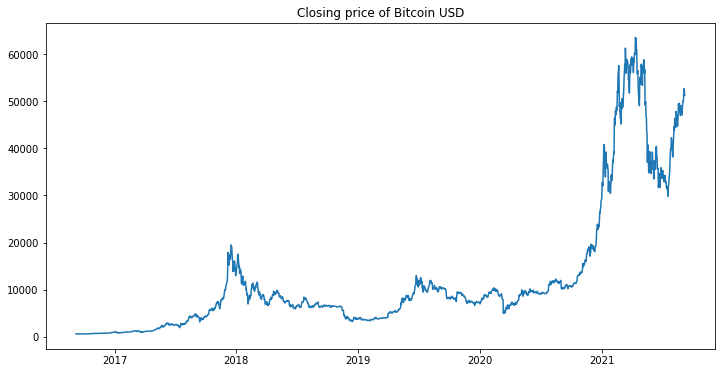

In [158]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(ts)
ax.set_title("Closing price of Bitcoin USD")

로그 변환을 진행해보겠습니다.

Text(0.5, 1.0, 'Closing price(Log) of Bitcoin USD')

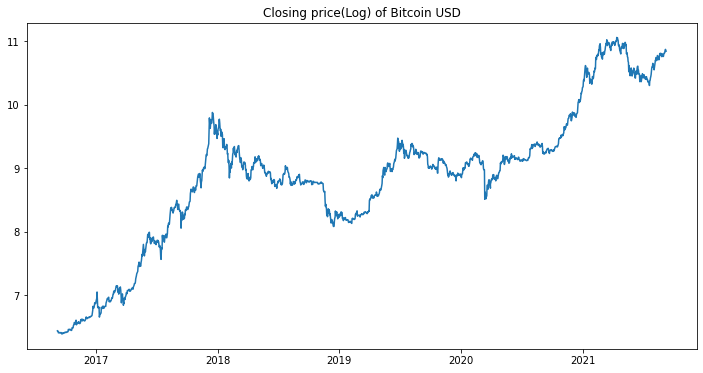

In [159]:
ts_log = np.log(ts)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(ts_log)
ax.set_title("Closing price(Log) of Bitcoin USD")

## STEP 3: 시계열 안정성 분석

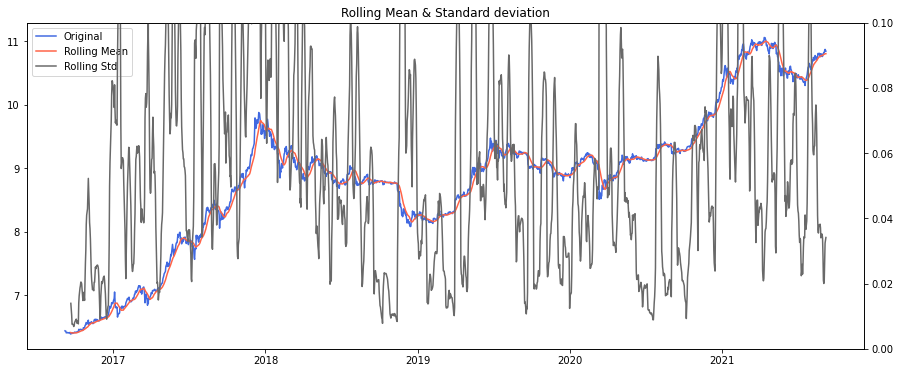

In [162]:
plot_rolling_statistics(ts_log, window=15)

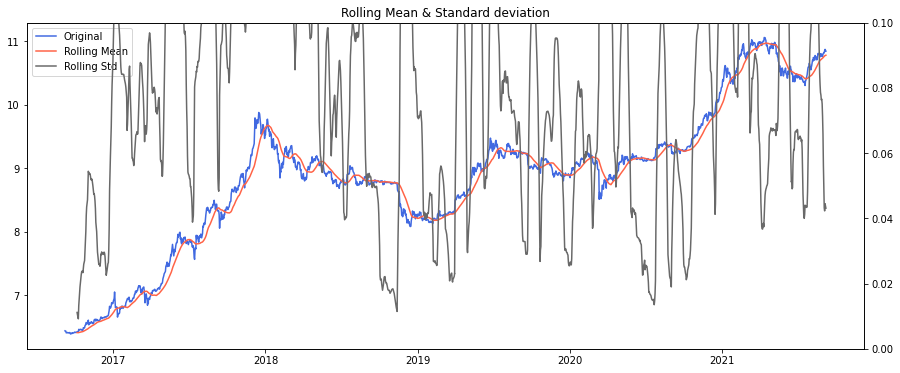

In [163]:
plot_rolling_statistics(ts_log, window=30)

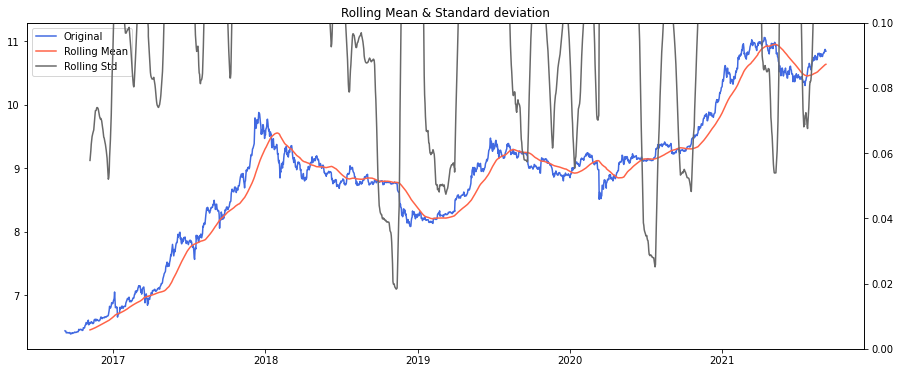

In [164]:
plot_rolling_statistics(ts_log, window=60)

각각 15, 30, 60일로 그림을 그리고 이동평균선, 이동표준편차선을 확인해보면 일정하지 않고 원래 그래프에 따라 상승하는 모습을 보입니다. 통계적으로도 확인해보기 위해  `augmented_dickey_fuller_test` 를 사용하겠습니다.

In [165]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test: 
Test Statistic                   -1.289739
p-value                           0.633854
#Lags Used                        2.000000
Number of Observations Used    1819.000000
Critical value 1%                -3.433950
Critical value 5%                -2.863130
Critical value 10%               -2.567617
dtype: float64


유의수준값이 0.6으로 아직도 매우 높습니다. 따라서 별도의 전처리를 추가적으로 진행해주겠습니다.

### (1) Moving average 제거 - 추세(Trend) 상쇄하기

위에서 확인 15, 30, 60일 이동평균을 삭제하여 추세를 상쇄시킨 시계열 데이터를 각각 구하고 시각화를 해보고 통계적으로도 변화가 있는 지 확인해보겠습니다.

#### (a) 15일 이동평균 삭제

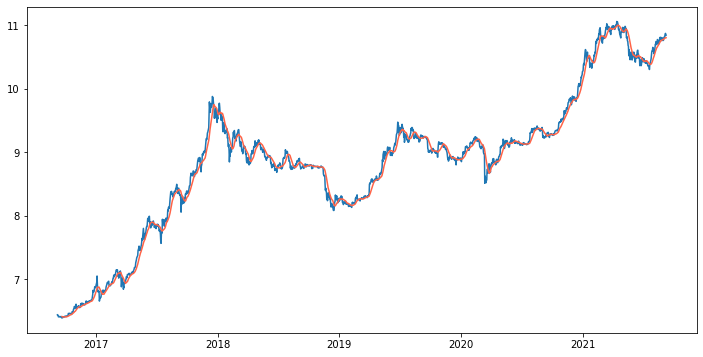

In [166]:
moving_avg_15 = ts_log.rolling(window=15).mean()  # moving average구하기
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(ts_log)
ax.plot(moving_avg_15, color='tomato')

In [167]:
ts_log_moving_avg_15 = ts_log - moving_avg_15 # 변화량 제거
ts_log_moving_avg_15.dropna(inplace=True)
ts_log_moving_avg_15.head(15)

Date
2016-09-21   -0.022469
2016-09-22   -0.009007
2016-09-23   -0.007165
2016-09-24   -0.007685
2016-09-25    0.004110
2016-09-26    0.001247
2016-09-27   -0.000633
2016-09-28    0.001509
2016-09-29    0.007877
2016-09-30    0.014054
2016-10-01    0.008470
2016-10-02    0.010253
2016-10-03    0.006989
2016-10-04    0.010304
2016-10-05    0.009388
Name: Close, dtype: float64

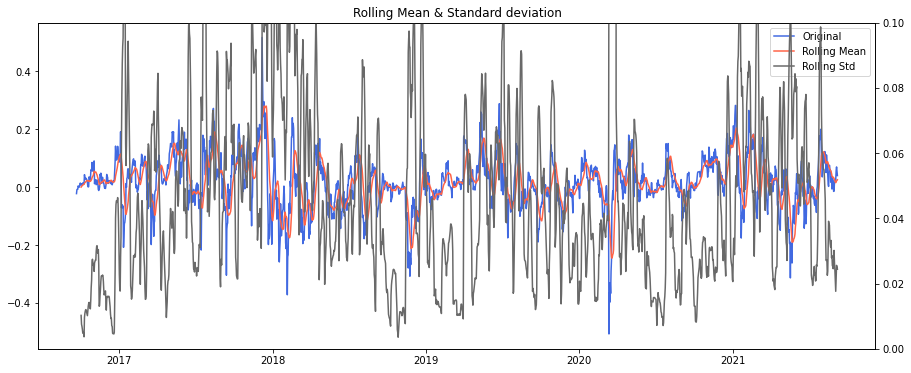

In [168]:
plot_rolling_statistics(ts_log_moving_avg_15)

In [169]:
augmented_dickey_fuller_test(ts_log_moving_avg_15)

Results of Dickey-Fuller Test: 
Test Statistic                -7.569766e+00
p-value                        2.861852e-11
#Lags Used                     2.100000e+01
Number of Observations Used    1.786000e+03
Critical value 1%             -3.434017e+00
Critical value 5%             -2.863160e+00
Critical value 10%            -2.567632e+00
dtype: float64


p-value가 0에 가까운 아주 작은 값으로 떨어진 것을 확인할 수 있습니다.

#### (b) 30일 이동평균 삭제

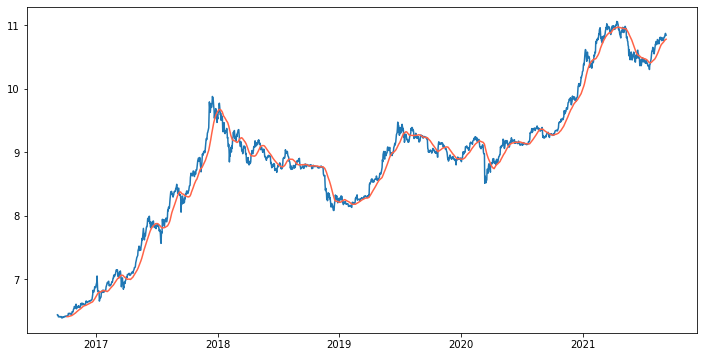

In [170]:
moving_avg_30 = ts_log.rolling(window=30).mean()  # moving average구하기
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(ts_log)
ax.plot(moving_avg_30, color='tomato')

In [171]:
ts_log_moving_avg_30 = ts_log - moving_avg_30 # 변화량 제거
ts_log_moving_avg_30.dropna(inplace=True)
ts_log_moving_avg_30.head(15)

Date
2016-10-06    0.012811
2016-10-07    0.016411
2016-10-08    0.012927
2016-10-09    0.016798
2016-10-10    0.050008
2016-10-11    0.040869
2016-10-12    0.040329
2016-10-13    0.044371
2016-10-14    0.039977
2016-10-15    0.042789
2016-10-16    0.037204
2016-10-17    0.033772
2016-10-18    0.020896
2016-10-19    0.020218
2016-10-20    0.021403
Name: Close, dtype: float64

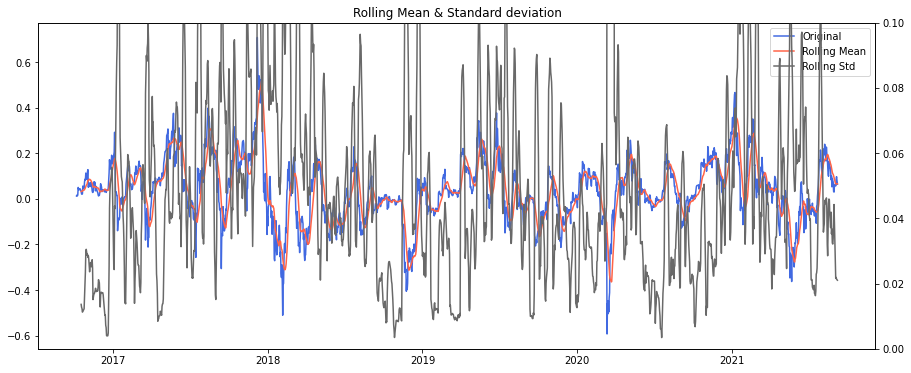

In [172]:
plot_rolling_statistics(ts_log_moving_avg_30)

In [173]:
augmented_dickey_fuller_test(ts_log_moving_avg_30)

Results of Dickey-Fuller Test: 
Test Statistic                -6.995683e+00
p-value                        7.544564e-10
#Lags Used                     1.000000e+01
Number of Observations Used    1.782000e+03
Critical value 1%             -3.434025e+00
Critical value 5%             -2.863163e+00
Critical value 10%            -2.567634e+00
dtype: float64


p-value가 0에 가깝습니다.

#### (c) 60일 이동평균 삭제

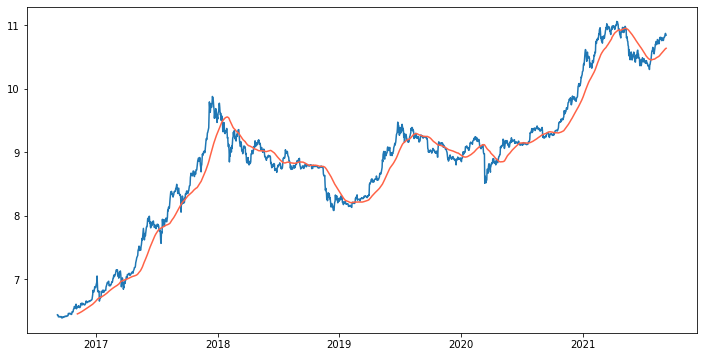

In [174]:
moving_avg_60 = ts_log.rolling(window=60).mean()  # moving average구하기
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(ts_log)
ax.plot(moving_avg_60, color='tomato')

In [175]:
ts_log_moving_avg_60 = ts_log - moving_avg_60 # 변화량 제거
ts_log_moving_avg_60.dropna(inplace=True)
ts_log_moving_avg_60.head(15)

Date
2016-11-06    0.112395
2016-11-07    0.098604
2016-11-08    0.105932
2016-11-09    0.122195
2016-11-10    0.108688
2016-11-11    0.107185
2016-11-12    0.088771
2016-11-13    0.082150
2016-11-14    0.083910
2016-11-15    0.090574
2016-11-16    0.131914
2016-11-17    0.124331
2016-11-18    0.135046
2016-11-19    0.131562
2016-11-20    0.100414
Name: Close, dtype: float64

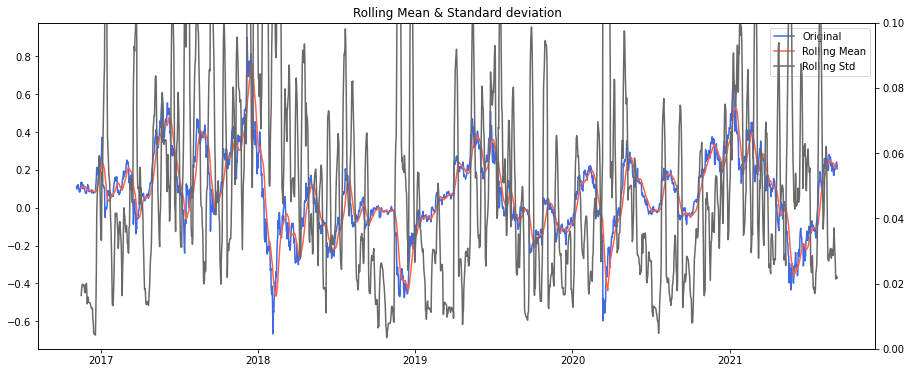

In [176]:
plot_rolling_statistics(ts_log_moving_avg_60)

In [177]:
augmented_dickey_fuller_test(ts_log_moving_avg_60)

Results of Dickey-Fuller Test: 
Test Statistic                   -4.216598
p-value                           0.000618
#Lags Used                        2.000000
Number of Observations Used    1760.000000
Critical value 1%                -3.434071
Critical value 5%                -2.863184
Critical value 10%               -2.567645
dtype: float64


p-value가 0.000618입니다

p-value가 가장 작은 15일 이동평균을 삭제한 `ts_log_moving_avg_15`를 사용하도록 하겠습니다.

### (2) 차분(Differencing) - 계절성(Seasonality) 상쇄하기
이동평균의 삭제로 잡히지 않는 시계열 데이터의 주기성들을 확인해보기 위해 계절성을 체크해보겠습니다.

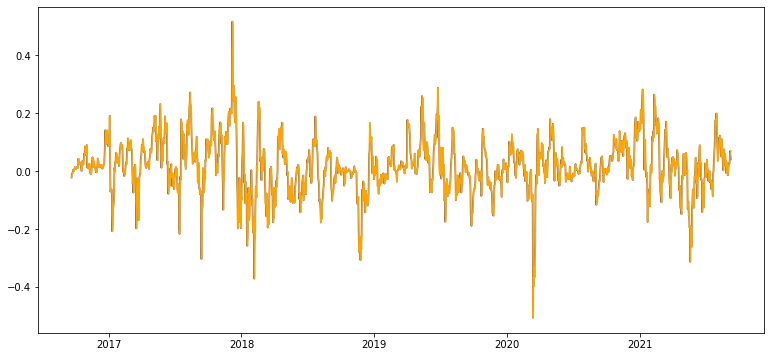

In [178]:
ts_log_moving_avg_shift = ts_log_moving_avg_15.shift()

fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(ts_log_moving_avg_15, color='royalblue')
ax.plot(ts_log_moving_avg_shift, color='orange')

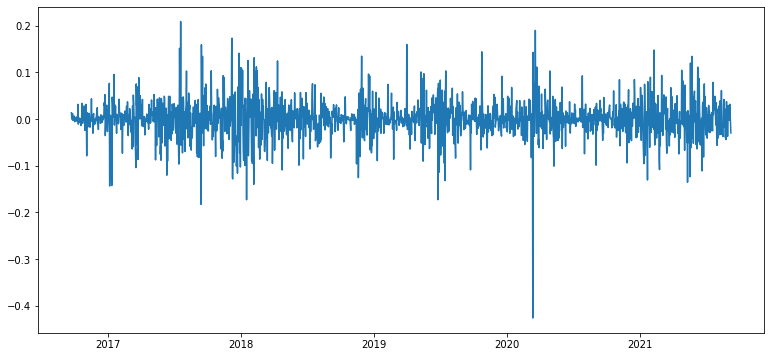

In [179]:
ts_log_moving_avg_diff = ts_log_moving_avg_15 - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)

fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(ts_log_moving_avg_diff)

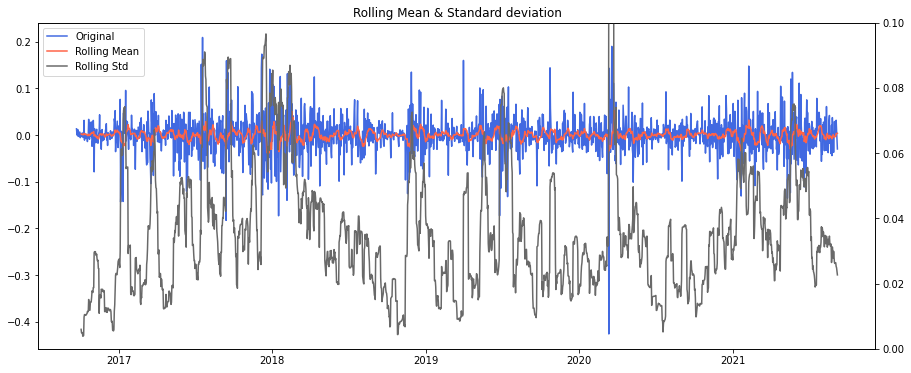

In [180]:
plot_rolling_statistics(ts_log_moving_avg_diff)

In [181]:
augmented_dickey_fuller_test(ts_log_moving_avg_diff)

Results of Dickey-Fuller Test: 
Test Statistic                -1.264453e+01
p-value                        1.411138e-23
#Lags Used                     2.200000e+01
Number of Observations Used    1.784000e+03
Critical value 1%             -3.434021e+00
Critical value 5%             -2.863161e+00
Critical value 10%            -2.567633e+00
dtype: float64


p-value가 사실상 0이라고 볼 수 있을만큼 작은 값이 됐습니다.

### (3) 시계열 분해(Time series decomposition)

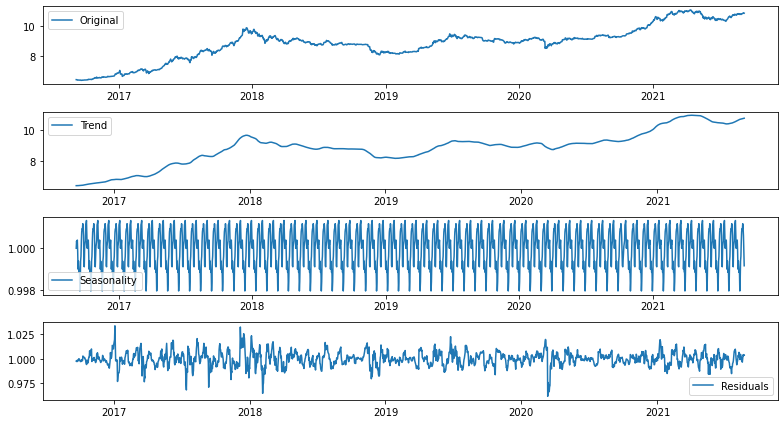

In [182]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates


decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30)

trend = decomposition.trend 
seasonal = decomposition.seasonal
residual = decomposition.resid

fig, axes = plt.subplots(figsize=(11, 6), nrows=4, ncols=1)
axs = axes.ravel()

axs[0].plot(ts_log, label='Original')
axs[0].legend(loc='best')

axs[1].plot(trend, label='Trend')
axs[1].legend(loc='best')

axs[2].plot(seasonal, label='Seasonality')
axs[2].legend(loc='best')

axs[3].plot(residual, label='Residuals')
axs[3].legend(loc='best')

fig.tight_layout()

계절성(Seasonality)를 어떻게 해석해야 할 지가 의문입니다. 주기성은 보여주고 있지만 그 간격이 일정하지는 않은 것 같습니다. 조금 더 찾아봐야겠네요.

기존 시계열에서 Trend, Seasonality를 제거한 residual의 안정성을 체크해보겠습니다.

In [183]:
residual.isna().sum()

30

In [184]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test: 
Test Statistic                -1.231906e+01
p-value                        6.816314e-23
#Lags Used                     2.000000e+01
Number of Observations Used    1.771000e+03
Critical value 1%             -3.434048e+00
Critical value 5%             -2.863173e+00
Critical value 10%            -2.567640e+00
dtype: float64


이번에도 아주 낮은 p-value값을 볼 수 있습니다.

## STEP 4: 학습, 테스트 데이터셋 생성

Train data's length: 1639
Test data's length: 183


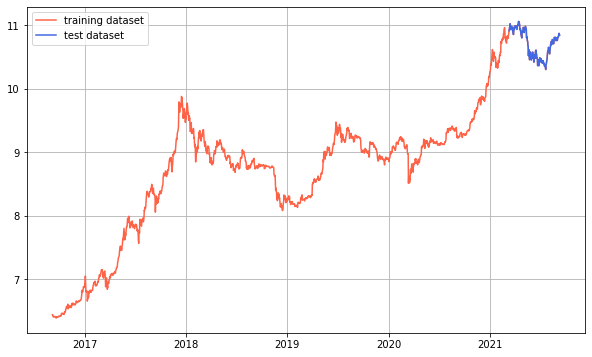

In [185]:
split_idx = int(len(ts_log) * 0.9)
train_data, test_data = ts_log[:split_idx], ts_log[split_idx:]

print(f"Train data's length: {len(train_data)}")
print(f"Test data's length: {len(test_data)}")

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(ts_log, c='tomato', label='training dataset') ## 전체 데이터셋을 이용해 그리면 자연스럽게 가능.
ax.plot(test_data, c='royalblue', label='test dataset')
ax.grid(True)
ax.legend()

## STEP 5: 적정 ARIMA 모수 찾기

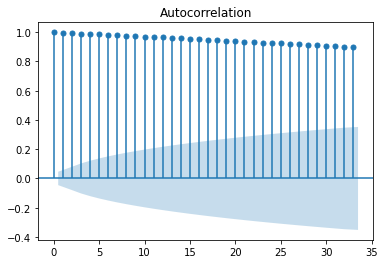

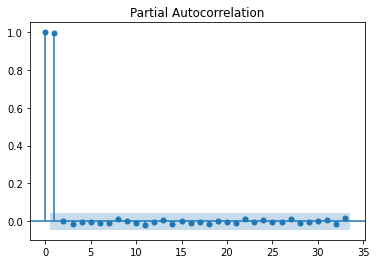

In [186]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)
plot_pacf(ts_log)

plt.show()

이번에도 그래프를 통해 **p=1이 적합함**만을 알 수 있습니다. q의 적합한 값은 위 두 그래프로 파악하기는 쉽지 않습니다.

Results of Dickey-Fuller Test: 
Test Statistic                  -29.405534
p-value                           0.000000
#Lags Used                        1.000000
Number of Observations Used    1819.000000
Critical value 1%                -3.433950
Critical value 5%                -2.863130
Critical value 10%               -2.567617
dtype: float64


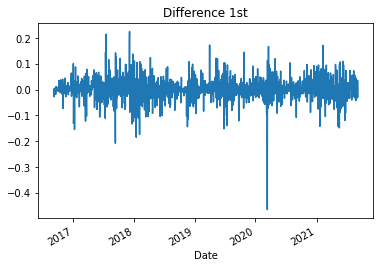

In [187]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test: 
Test Statistic                -1.783022e+01
p-value                        3.135509e-30
#Lags Used                     1.800000e+01
Number of Observations Used    1.801000e+03
Critical value 1%             -3.433986e+00
Critical value 5%             -2.863146e+00
Critical value 10%            -2.567625e+00
dtype: float64


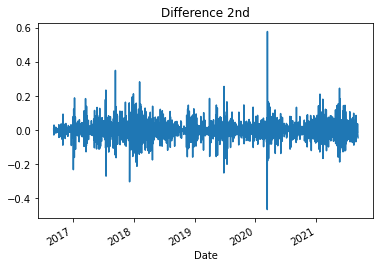

In [188]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

1차, 2차 차분 모두 아주 낮은 p-value를 보여주고 있습니다.

## STEP 6: ARIMA 모델 훈련과 테스트

이번에는 바로 AUTOARIMA를 사용하며 실험을 진행해보겠습니다. 실험 방식은 위와 비슷하게 d=1, d=2인 경우로 나눠 진행해보겠습니다.

### (1) `d = 1`

In [189]:
model_arima = auto_arima(train_data ,trace=True, error_action='ignore', 
                        start_p=0, start_q=0, d=1, max_p=5, max_q=5,
                        suppress_warnings=True, stepwise=False, seasonal=False)

model_arima.fit(train_data)

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5764.539, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5763.432, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-5763.554, Time=0.14 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-5761.559, Time=0.67 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-5759.568, Time=0.89 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=-5760.509, Time=1.87 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5763.496, Time=0.26 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5762.269, Time=0.32 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-5761.533, Time=0.54 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-5759.550, Time=0.29 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-5757.586, Time=0.79 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-5763.540, Time=0.31 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-5761.557, Time=0.22 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-5759.664, Time=1.13 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-5757.916, Time=1.12

ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True)

AUTOARIMA는 결과로 (0, 1, 0)을 가장 좋은 결과로 반환하고 있습니다.

In [190]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(train_data, order = (0, 1, 0)) ## p, d, q
fitted_m = model.fit(disp=-1)

print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1638
Model:                 ARIMA(0, 1, 0)   Log Likelihood                2884.269
Method:                           css   S.D. of innovations              0.042
Date:                Tue, 07 Sep 2021   AIC                          -5764.539
Time:                        10:48:39   BIC                          -5753.736
Sample:                             1   HQIC                         -5760.532
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      2.628      0.009       0.001       0.005


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

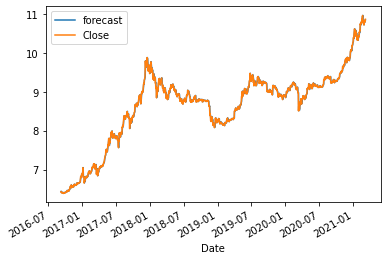

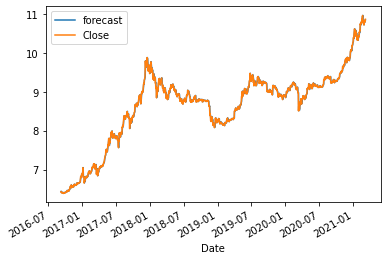

In [191]:
fitted_m.plot_predict()

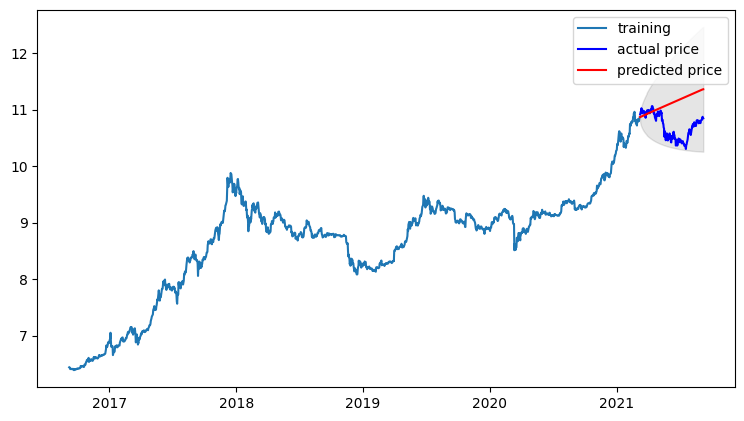

In [192]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
fig, ax = plt.subplots(figsize=(9, 5), dpi=100)
ax.plot(train_data, label='training')
ax.plot(test_data, c='b', label='actual price')
ax.plot(fc_series, c='r', label='predicted price')
ax.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
ax.legend()

In [193]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  767950799.2924756
MAE:  23193.272412292496
RMSE:  27711.925218080312
MAPE: 59.42%


MAPE가 59.42%로 상당히 큰 오차를 보여주고 있습니다.

### (2) `d = 2`

In [194]:
model_arima = auto_arima(train_data ,trace=True, error_action='ignore', 
                        start_p=0, start_q=0, d=2, max_p=5, max_q=5,
                        suppress_warnings=True, stepwise=False, seasonal=False)

model_arima.fit(train_data)

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-4586.337, Time=0.24 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.74 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.34 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=-5704.613, Time=1.49 sec
 ARIMA(0,2,4)(0,0,0)[0] intercept   : AIC=-5738.993, Time=2.76 sec
 ARIMA(0,2,5)(0,0,0)[0] intercept   : AIC=-5722.378, Time=1.99 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-5122.514, Time=0.34 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.97 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.89 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.75 sec
 ARIMA(1,2,4)(0,0,0)[0] intercept   : AIC=inf, Time=4.29 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=-5303.251, Time=0.28 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=-5746.320, Time=1.24 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.75 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.56 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=-

ARIMA(order=(2, 2, 1), scoring_args={}, suppress_warnings=True)

AUTOARIMA는 결과로 (2, 2, 1)을 가장 좋은 결과로 반환하고 있습니다.

In [195]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(train_data, order = (2, 2, 1)) ## p, d, q
fitted_m = model.fit(disp=-1)

print(fitted_m.summary())

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

                             ARIMA Model Results                              
Dep. Variable:               D2.Close   No. Observations:                 1637
Model:                 ARIMA(2, 2, 1)   Log Likelihood                2880.555
Method:                       css-mle   S.D. of innovations              0.042
Date:                Tue, 07 Sep 2021   AIC                          -5751.111
Time:                        10:49:59   BIC                          -5724.107
Sample:                             2   HQIC                         -5741.095
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           2.045e-06   7.25e-06      0.282      0.778   -1.22e-05    1.63e-05
ar.L1.D2.Close    -0.0249      0.025     -0.996      0.319      -0.074       0.024
ar.L2.D2.Close     0.0312      0.025

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


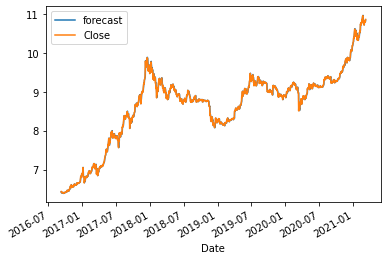

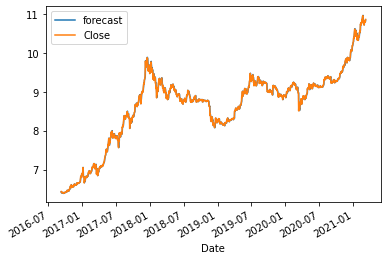

In [196]:
fitted_m.plot_predict()

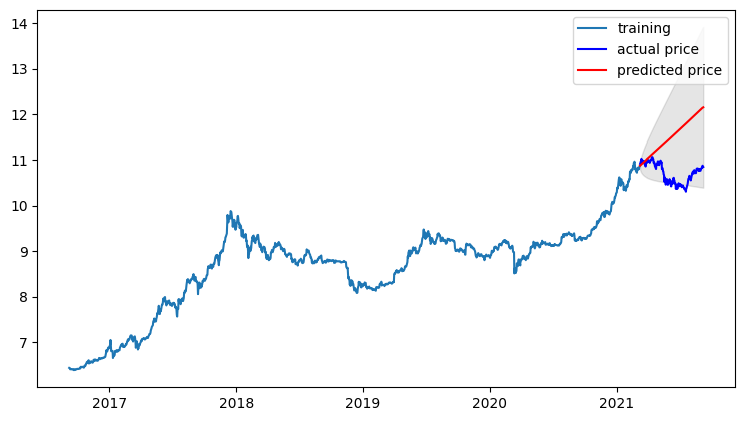

In [197]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
fig, ax = plt.subplots(figsize=(9, 5), dpi=100)
ax.plot(train_data, label='training')
ax.plot(test_data, c='b', label='actual price')
ax.plot(fc_series, c='r', label='predicted price')
ax.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
ax.legend()

In [198]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  5653723029.840019
MAE:  61030.753549069756
RMSE:  75191.24303959883
MAPE: 151.93%


MAPE가 151.93%로 상당히 큰 오차를 보이고 있습니다.

# 다른 주식 종목 예측해 보기3 - The Walt Disney Company

## STEP 1: 시계열 데이터 준비

In [233]:
import pandas_datareader as pdr

df = pdr.DataReader('DIS', 'yahoo')

In [234]:
df.head()

High        Low       Open      Close      Volume  Adj Close
Date                                                                         
2016-09-08  94.209999  92.930000  93.489998  94.089996   7438100.0  89.413391
2016-09-09  93.739998  92.389999  93.510002  92.419998  10248400.0  87.826408
2016-09-12  93.860001  91.949997  91.959999  93.639999   9367300.0  88.985779
2016-09-13  93.300003  92.449997  93.040001  92.699997   7795200.0  88.092476
2016-09-14  92.889999  92.070000  92.589996  92.260002   6386500.0  87.674347

In [235]:
ts = df['Close']
ts.head()

Date
2016-09-08    94.089996
2016-09-09    92.419998
2016-09-12    93.639999
2016-09-13    92.699997
2016-09-14    92.260002
Name: Close, dtype: float64

## STEP 2: 각종 전처리 수행

In [236]:
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

원래도 결측치가 없지만, 보간법을 한번 사용해보겠습니다.

In [237]:
ts = ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

Text(0.5, 1.0, 'Closing price of Disney')

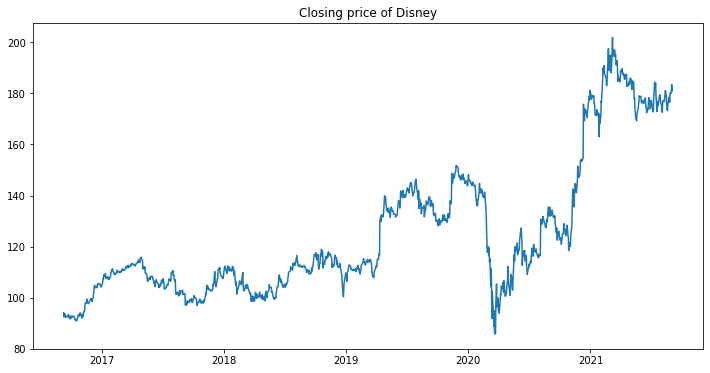

In [238]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(ts)
ax.set_title("Closing price of Disney")

로그 변환을 진행해보겠습니다.

Text(0.5, 1.0, 'Closing price(Log) of Disney')

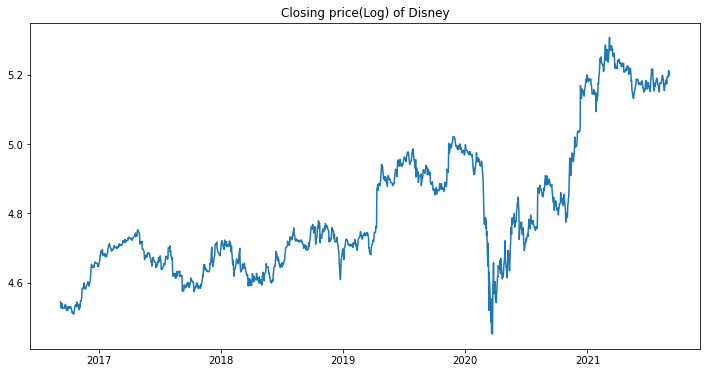

In [239]:
ts_log = np.log(ts)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(ts_log)
ax.set_title("Closing price(Log) of Disney")

## STEP 3: 시계열 안정성 분석

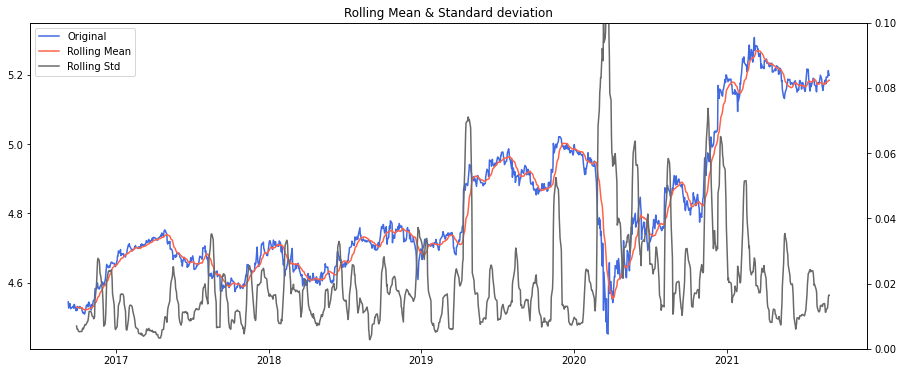

In [240]:
plot_rolling_statistics(ts_log, window=15)

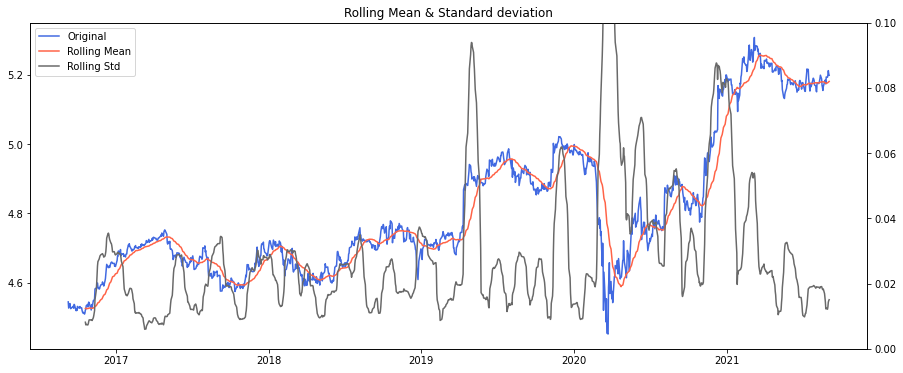

In [241]:
plot_rolling_statistics(ts_log, window=30)

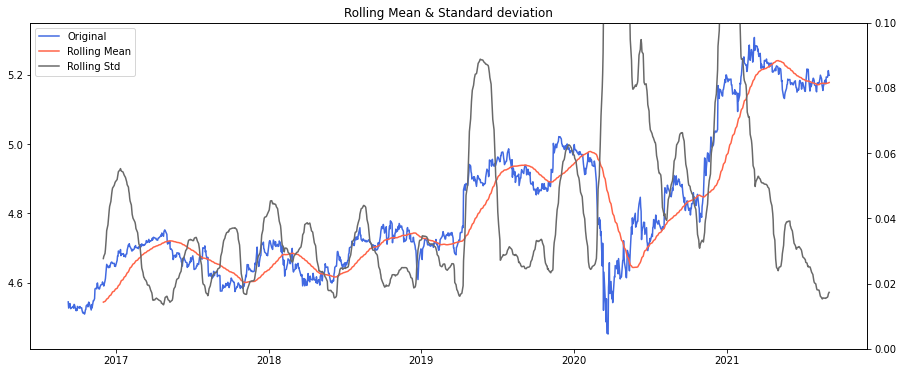

In [242]:
plot_rolling_statistics(ts_log, window=60)

각각 15, 30, 60일로 그림을 그리고 이동평균선, 이동표준편차선을 확인해보면 일정하지 않고 원래 그래프에 따라 상승하는 모습을 보입니다. 통계적으로도 확인해보기 위해  `augmented_dickey_fuller_test` 를 사용하겠습니다.

In [243]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test: 
Test Statistic                   -1.105923
p-value                           0.712704
#Lags Used                        9.000000
Number of Observations Used    1247.000000
Critical value 1%                -3.435605
Critical value 5%                -2.863861
Critical value 10%               -2.568005
dtype: float64


유의수준값이 0.7로 꽤 높습니다. 따라서 별도의 전처리를 추가적으로 진행해주겠습니다.

### (1) Moving average 제거 - 추세(Trend) 상쇄하기

위에서 확인 15, 30, 60일 이동평균을 삭제하여 추세를 상쇄시킨 시계열 데이터를 각각 구하고 시각화를 해보고 통계적으로도 변화가 있는 지 확인해보겠습니다.

#### (a) 15일 이동평균 삭제

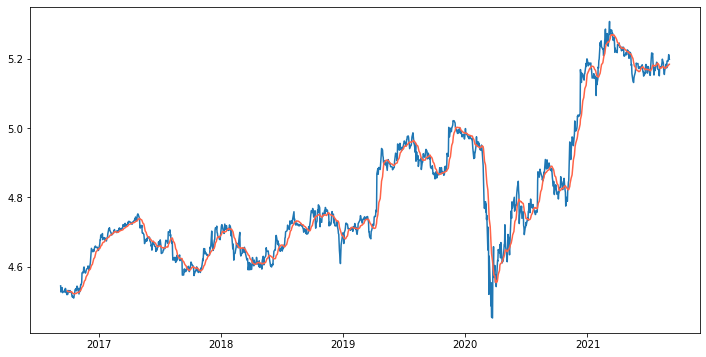

In [244]:
moving_avg_15 = ts_log.rolling(window=15).mean()  # moving average구하기
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(ts_log)
ax.plot(moving_avg_15, color='tomato')

In [245]:
ts_log_moving_avg_15 = ts_log - moving_avg_15 # 변화량 제거
ts_log_moving_avg_15.dropna(inplace=True)
ts_log_moving_avg_15.head(15)

Date
2016-09-28   -0.005529
2016-09-29   -0.008235
2016-09-30    0.002929
2016-10-03   -0.000239
2016-10-04    0.000921
2016-10-05   -0.000730
2016-10-06    0.003135
2016-10-07   -0.000484
2016-10-10   -0.000383
2016-10-11   -0.006432
2016-10-12   -0.010632
2016-10-13   -0.012154
2016-10-14   -0.008758
2016-10-17   -0.013095
2016-10-18   -0.008957
Name: Close, dtype: float64

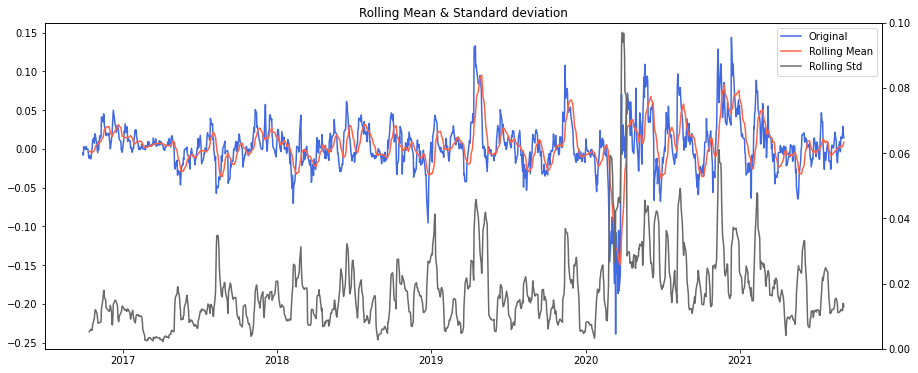

In [246]:
plot_rolling_statistics(ts_log_moving_avg_15)

In [247]:
augmented_dickey_fuller_test(ts_log_moving_avg_15)

Results of Dickey-Fuller Test: 
Test Statistic                -7.623330e+00
p-value                        2.100150e-11
#Lags Used                     8.000000e+00
Number of Observations Used    1.234000e+03
Critical value 1%             -3.435660e+00
Critical value 5%             -2.863885e+00
Critical value 10%            -2.568019e+00
dtype: float64


p-value가 0에 가까운 아주 작은 값으로 떨어진 것을 확인할 수 있습니다.

#### (b) 30일 이동평균 삭제

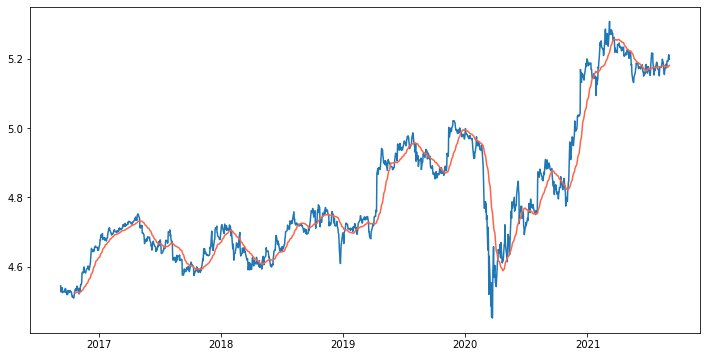

In [248]:
moving_avg_30 = ts_log.rolling(window=30).mean()  # moving average구하기
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(ts_log)
ax.plot(moving_avg_30, color='tomato')

In [249]:
ts_log_moving_avg_30 = ts_log - moving_avg_30 # 변화량 제거
ts_log_moving_avg_30.dropna(inplace=True)
ts_log_moving_avg_30.head(15)

Date
2016-10-19   -0.004461
2016-10-20   -0.002636
2016-10-21    0.007952
2016-10-24    0.011696
2016-10-25    0.005016
2016-10-26    0.012521
2016-10-27    0.017631
2016-10-28    0.015360
2016-10-31    0.002901
2016-11-01   -0.000139
2016-11-02   -0.005175
2016-11-03    0.010600
2016-11-04    0.000992
2016-11-07    0.021300
2016-11-08    0.019817
Name: Close, dtype: float64

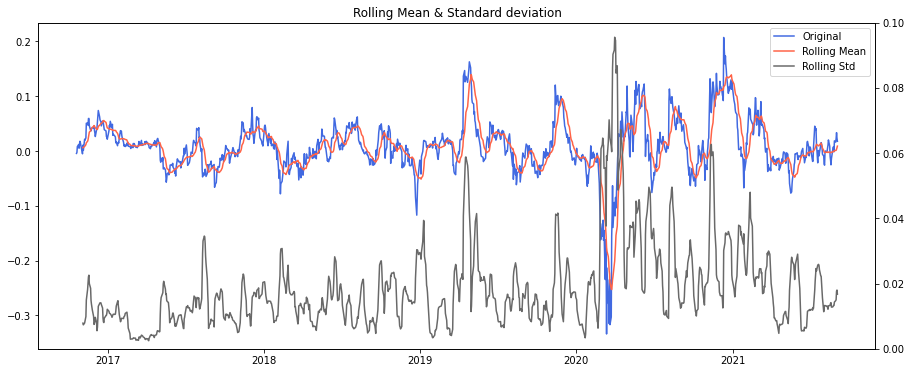

In [250]:
plot_rolling_statistics(ts_log_moving_avg_30)

In [251]:
augmented_dickey_fuller_test(ts_log_moving_avg_30)

Results of Dickey-Fuller Test: 
Test Statistic                -5.978481e+00
p-value                        1.862816e-07
#Lags Used                     1.100000e+01
Number of Observations Used    1.216000e+03
Critical value 1%             -3.435739e+00
Critical value 5%             -2.863920e+00
Critical value 10%            -2.568037e+00
dtype: float64


p-value가 0에 가깝습니다.

#### (c) 60일 이동평균 삭제

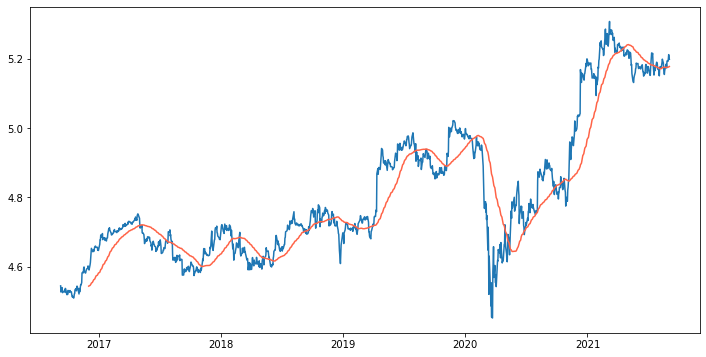

In [252]:
moving_avg_60 = ts_log.rolling(window=60).mean()  # moving average구하기
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(ts_log)
ax.plot(moving_avg_60, color='tomato')

In [253]:
ts_log_moving_avg_60 = ts_log - moving_avg_60 # 변화량 제거
ts_log_moving_avg_60.dropna(inplace=True)
ts_log_moving_avg_60.head(15)

Date
2016-12-01    0.051026
2016-12-02    0.045805
2016-12-05    0.059212
2016-12-06    0.064985
2016-12-07    0.076520
2016-12-08    0.088160
2016-12-09    0.100284
2016-12-12    0.090674
2016-12-13    0.086748
2016-12-14    0.086792
2016-12-15    0.088019
2016-12-16    0.081635
2016-12-19    0.092901
2016-12-20    0.092137
2016-12-21    0.090742
Name: Close, dtype: float64

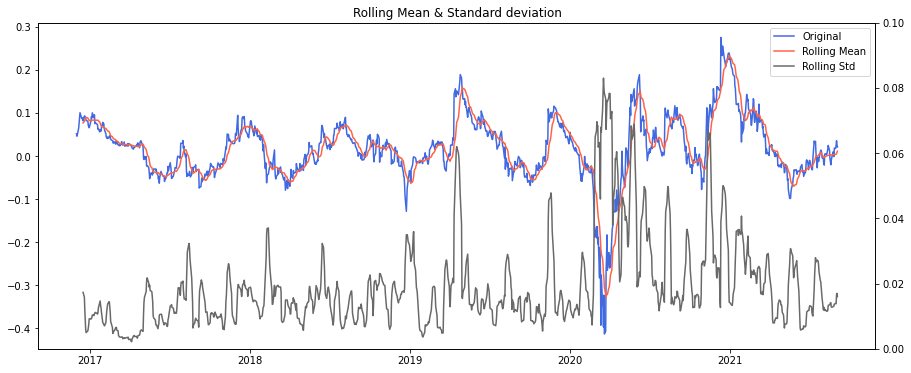

In [254]:
plot_rolling_statistics(ts_log_moving_avg_60)

In [255]:
augmented_dickey_fuller_test(ts_log_moving_avg_60)

Results of Dickey-Fuller Test: 
Test Statistic                   -4.626743
p-value                           0.000115
#Lags Used                       13.000000
Number of Observations Used    1184.000000
Critical value 1%                -3.435885
Critical value 5%                -2.863984
Critical value 10%               -2.568071
dtype: float64


p-value가 0.000115입니다

p-value가 가장 작은 15일 이동평균을 삭제한 `ts_log_moving_avg_15`를 사용하도록 하겠습니다.

### (2) 차분(Differencing) - 계절성(Seasonality) 상쇄하기
이동평균의 삭제로 잡히지 않는 시계열 데이터의 주기성들을 확인해보기 위해 계절성을 체크해보겠습니다.

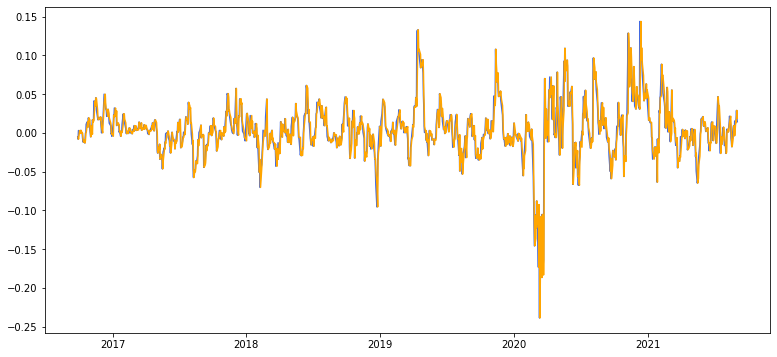

In [256]:
ts_log_moving_avg_shift = ts_log_moving_avg_15.shift()

fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(ts_log_moving_avg_15, color='royalblue')
ax.plot(ts_log_moving_avg_shift, color='orange')

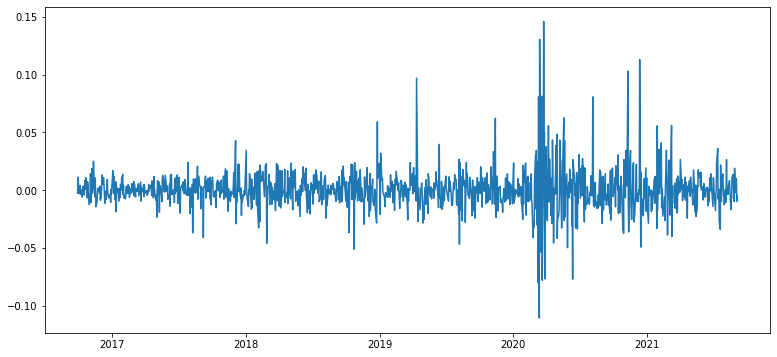

In [257]:
ts_log_moving_avg_diff = ts_log_moving_avg_15 - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)

fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(ts_log_moving_avg_diff)

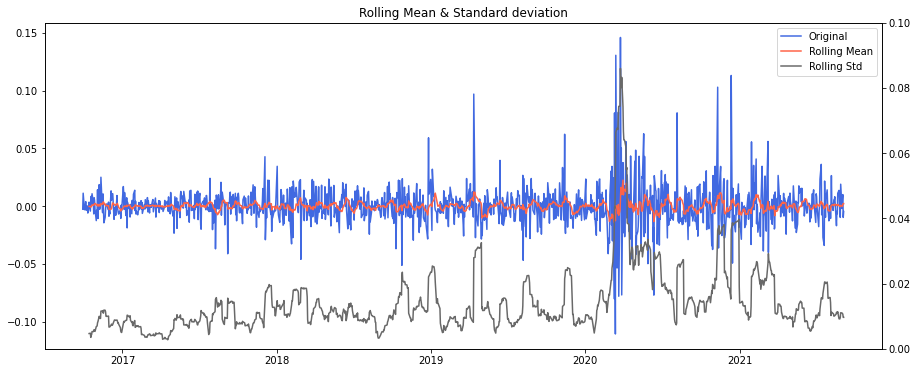

In [258]:
plot_rolling_statistics(ts_log_moving_avg_diff)

In [259]:
augmented_dickey_fuller_test(ts_log_moving_avg_diff)

Results of Dickey-Fuller Test: 
Test Statistic                -1.094750e+01
p-value                        8.969927e-20
#Lags Used                     2.100000e+01
Number of Observations Used    1.220000e+03
Critical value 1%             -3.435721e+00
Critical value 5%             -2.863912e+00
Critical value 10%            -2.568033e+00
dtype: float64


p-value가 사실상 0이라고 볼 수 있을만큼 작은 값이 됐습니다.

### (3) 시계열 분해(Time series decomposition)

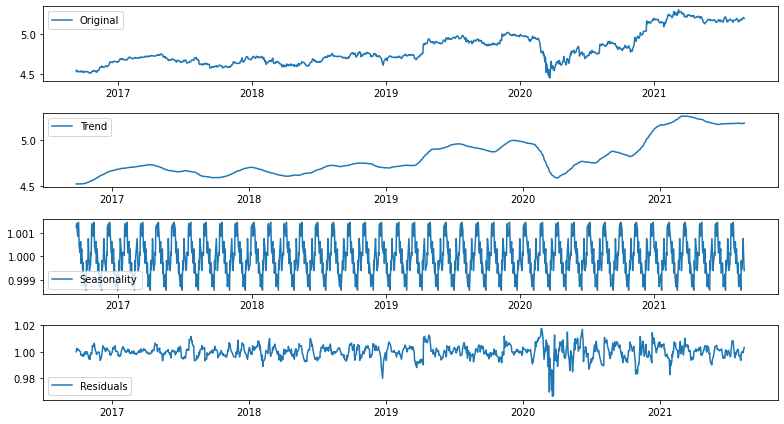

In [260]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates


decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30)

trend = decomposition.trend 
seasonal = decomposition.seasonal
residual = decomposition.resid

fig, axes = plt.subplots(figsize=(11, 6), nrows=4, ncols=1)
axs = axes.ravel()

axs[0].plot(ts_log, label='Original')
axs[0].legend(loc='best')

axs[1].plot(trend, label='Trend')
axs[1].legend(loc='best')

axs[2].plot(seasonal, label='Seasonality')
axs[2].legend(loc='best')

axs[3].plot(residual, label='Residuals')
axs[3].legend(loc='best')

fig.tight_layout()

기존 시계열에서 Trend, Seasonality를 제거한 residual의 안정성을 체크해보겠습니다.

In [261]:
residual.isna().sum()

30

In [262]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test: 
Test Statistic                -1.143822e+01
p-value                        6.271401e-21
#Lags Used                     1.100000e+01
Number of Observations Used    1.215000e+03
Critical value 1%             -3.435744e+00
Critical value 5%             -2.863922e+00
Critical value 10%            -2.568038e+00
dtype: float64


이번에도 아주 낮은 p-value값을 볼 수 있습니다.

## STEP 4: 학습, 테스트 데이터셋 생성

Train data's length: 1131
Test data's length: 126


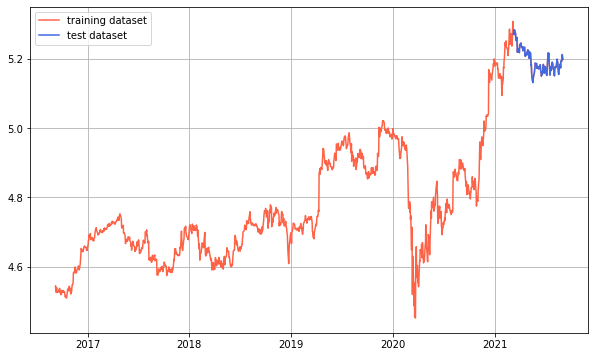

In [263]:
split_idx = int(len(ts_log) * 0.9)
train_data, test_data = ts_log[:split_idx], ts_log[split_idx:]

print(f"Train data's length: {len(train_data)}")
print(f"Test data's length: {len(test_data)}")

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(ts_log, c='tomato', label='training dataset') ## 전체 데이터셋을 이용해 그리면 자연스럽게 가능.
ax.plot(test_data, c='royalblue', label='test dataset')
ax.grid(True)
ax.legend()

## STEP 5: 적정 ARIMA 모수 찾기

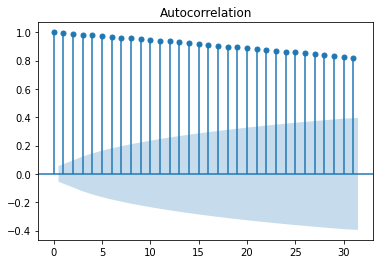

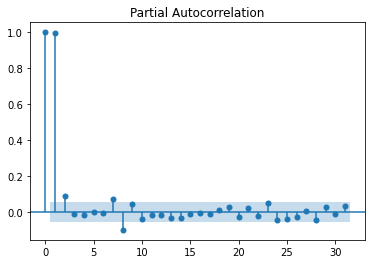

In [264]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)
plot_pacf(ts_log)

plt.show()

이번에도 그래프를 통해 **p=1이 적합함**만을 알 수 있습니다. q의 적합한 값은 위 두 그래프로 파악하기는 쉽지 않습니다.

Results of Dickey-Fuller Test: 
Test Statistic                -1.284244e+01
p-value                        5.570059e-24
#Lags Used                     7.000000e+00
Number of Observations Used    1.248000e+03
Critical value 1%             -3.435601e+00
Critical value 5%             -2.863859e+00
Critical value 10%            -2.568004e+00
dtype: float64


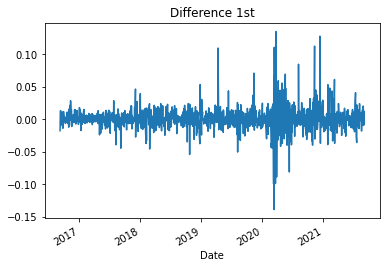

In [265]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test: 
Test Statistic                -1.255732e+01
p-value                        2.140169e-23
#Lags Used                     2.300000e+01
Number of Observations Used    1.231000e+03
Critical value 1%             -3.435673e+00
Critical value 5%             -2.863891e+00
Critical value 10%            -2.568022e+00
dtype: float64


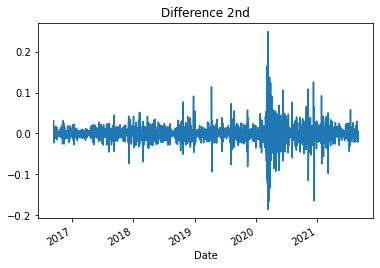

In [266]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

1차, 2차 차분 모두 아주 낮은 p-value를 보여주고 있습니다.

## STEP 6: ARIMA 모델 훈련과 테스트

이번에는 바로 AUTOARIMA를 사용하며 실험을 진행해보겠습니다. 실험 방식은 위와 비슷하게 d=1, d=2인 경우로 나눠 진행해보겠습니다.

### (1) `d = 1`

In [288]:
model_arima = auto_arima(train_data ,trace=True, error_action='ignore', 
                        start_p=0, start_q=0, d=1, max_p=5, max_q=5,
                        suppress_warnings=True, stepwise=False, seasonal=False)

model_arima.fit(train_data)

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5827.836, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5850.304, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-5849.220, Time=0.12 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-5847.615, Time=0.36 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-5845.730, Time=0.94 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=-5843.883, Time=1.22 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5851.032, Time=0.23 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5849.031, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-5847.380, Time=0.16 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-5845.641, Time=0.79 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-5855.610, Time=1.91 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-5849.032, Time=0.29 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-5847.033, Time=0.50 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-5845.779, Time=0.31 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-5843.635, Time=1.95

ARIMA(order=(1, 1, 4), scoring_args={}, suppress_warnings=True)

AUTOARIMA는 결과로 (1, 1, 4)로 해보려고 하니 ValueError가 떠 두번째로 성능이 좋은 (1, 1, 0)으로 해보겠습니다.

In [295]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(train_data, order = (1, 1, 0)) ## p, d, q
fitted_m = model.fit(disp=-1)

print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1130
Model:                 ARIMA(1, 1, 0)   Log Likelihood                2928.516
Method:                       css-mle   S.D. of innovations              0.018
Date:                Tue, 07 Sep 2021   AIC                          -5851.032
Time:                        13:10:46   BIC                          -5835.943
Sample:                             1   HQIC                         -5845.331
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0007      0.000      1.430      0.153      -0.000       0.002
ar.L1.D.Close    -0.1492      0.030     -5.048      0.000      -0.207      -0.091
                                    Root

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

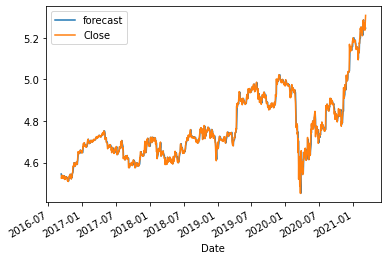

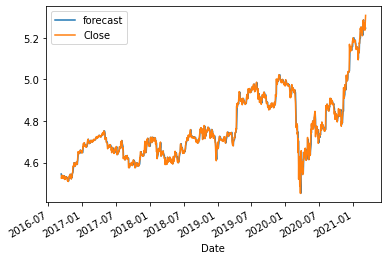

In [296]:
fitted_m.plot_predict()

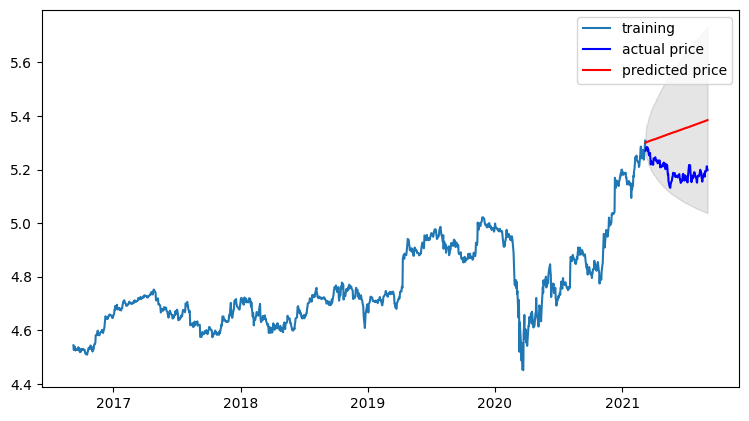

In [297]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
fig, ax = plt.subplots(figsize=(9, 5), dpi=100)
ax.plot(train_data, label='training')
ax.plot(test_data, c='b', label='actual price')
ax.plot(fc_series, c='r', label='predicted price')
ax.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
ax.legend()

In [298]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  920.5839489277346
MAE:  28.510886081246696
RMSE:  30.341126362212307
MAPE: 15.99%


MAPE로 15.99%를 보여주고 있습니다.

### (2) `d = 2`

In [299]:
model_arima = auto_arima(train_data ,trace=True, error_action='ignore', 
                        start_p=0, start_q=0, d=2, max_p=5, max_q=5,
                        suppress_warnings=True, stepwise=False, seasonal=False)

model_arima.fit(train_data)

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-4888.660, Time=0.15 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-5745.525, Time=0.24 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=-5832.805, Time=0.96 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=-5818.714, Time=1.08 sec
 ARIMA(0,2,4)(0,0,0)[0] intercept   : AIC=-5829.469, Time=2.82 sec
 ARIMA(0,2,5)(0,0,0)[0] intercept   : AIC=-5817.889, Time=3.35 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-5337.185, Time=0.11 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.36 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=-5808.192, Time=0.63 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=-5820.518, Time=1.08 sec
 ARIMA(1,2,4)(0,0,0)[0] intercept   : AIC=-5809.821, Time=0.85 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=-5507.788, Time=0.21 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.05 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.30 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.44 sec
 ARIMA(3,2,0)(0,0,0

ARIMA(order=(0, 2, 2), scoring_args={}, suppress_warnings=True)

AUTOARIMA는 결과로 (0, 2, 2)을 가장 좋은 결과로 반환하고 있습니다.

In [300]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(train_data, order = (0, 2, 2)) ## p, d, q
fitted_m = model.fit(disp=-1)

print(fitted_m.summary())

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

                             ARIMA Model Results                              
Dep. Variable:               D2.Close   No. Observations:                 1129
Model:                 ARIMA(0, 2, 2)   Log Likelihood                2921.930
Method:                       css-mle   S.D. of innovations              0.018
Date:                Tue, 07 Sep 2021   AIC                          -5835.861
Time:                        13:11:39   BIC                          -5815.744
Sample:                             2   HQIC                         -5828.260
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1.454e-06   1.41e-06      1.028      0.304   -1.32e-06    4.23e-06
ma.L1.D2.Close    -1.1446      0.029    -39.534      0.000      -1.201      -1.088
ma.L2.D2.Close     0.1446      0.029

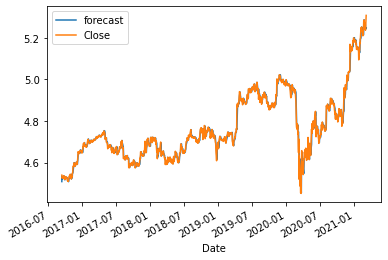

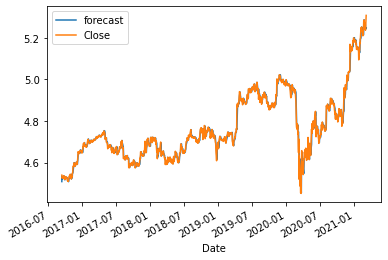

In [301]:
fitted_m.plot_predict()

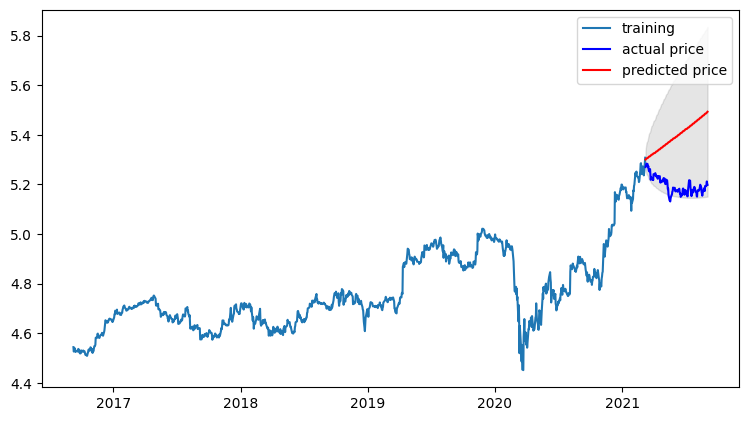

In [302]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
fig, ax = plt.subplots(figsize=(9, 5), dpi=100)
ax.plot(train_data, label='training')
ax.plot(test_data, c='b', label='actual price')
ax.plot(fc_series, c='r', label='predicted price')
ax.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
ax.legend()

In [303]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1893.8938566270886
MAE:  40.02309102385979
RMSE:  43.518890801893015
MAPE: 22.45%


# 다른 주식 종목 예측해 보기4 - iShares Core S&P 500 ETF

## STEP 1: 시계열 데이터 준비

In [323]:
import pandas_datareader as pdr

df = pdr.DataReader('IVV', 'yahoo')

In [324]:
df.head()

High         Low        Open       Close     Volume  \
Date                                                                    
2016-09-08  220.220001  219.429993  219.889999  219.809998  3038000.0   
2016-09-09  218.279999  214.479996  218.270004  214.539993  7335000.0   
2016-09-12  218.059998  213.539993  213.589996  217.630005  5111600.0   
2016-09-13  216.369995  213.750000  216.050003  214.470001  6515400.0   
2016-09-14  215.929993  213.710007  214.529999  214.350006  4224600.0   

             Adj Close  
Date                    
2016-09-08  199.520187  
2016-09-09  194.736694  
2016-09-12  197.541428  
2016-09-13  194.673141  
2016-09-14  194.564209

In [325]:
ts = df['Close']
ts.head()

Date
2016-09-08    219.809998
2016-09-09    214.539993
2016-09-12    217.630005
2016-09-13    214.470001
2016-09-14    214.350006
Name: Close, dtype: float64

## STEP 2: 각종 전처리 수행

In [326]:
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

원래도 결측치가 없지만, 보간법을 한번 사용해보겠습니다.

In [327]:
ts = ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

Text(0.5, 1.0, 'Closing price of IVV')

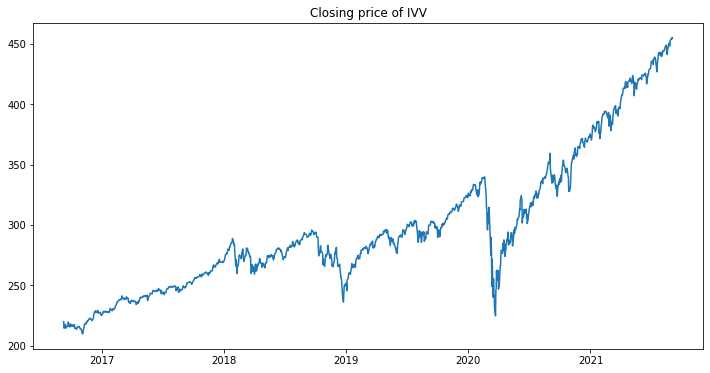

In [328]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(ts)
ax.set_title("Closing price of IVV")

로그 변환을 진행해보겠습니다.

Text(0.5, 1.0, 'Closing price(Log) of IVV')

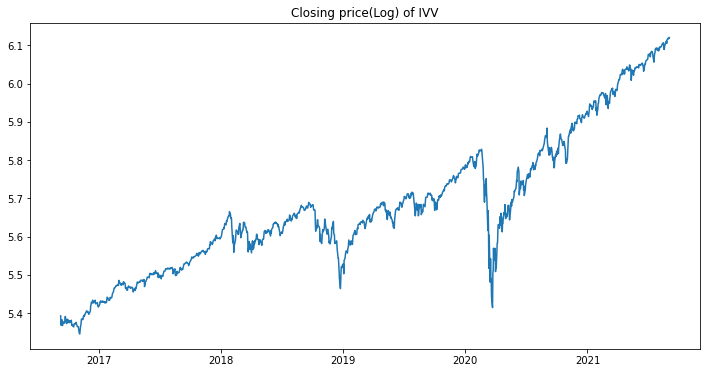

In [329]:
ts_log = np.log(ts)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(ts_log)
ax.set_title("Closing price(Log) of IVV")

## STEP 3: 시계열 안정성 분석

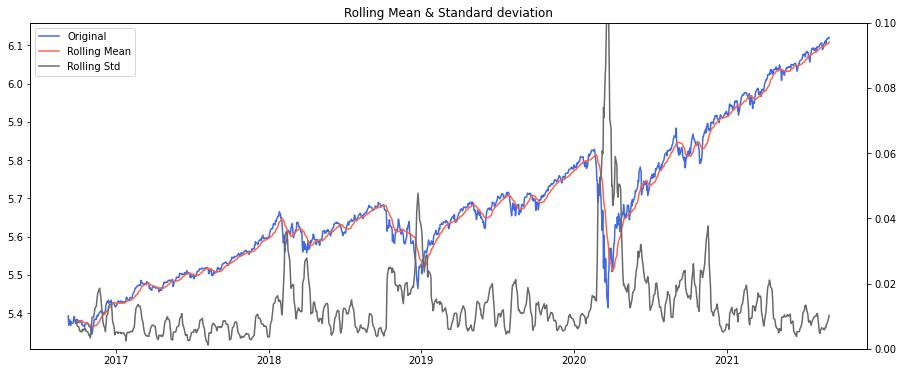

In [330]:
plot_rolling_statistics(ts_log, window=15)

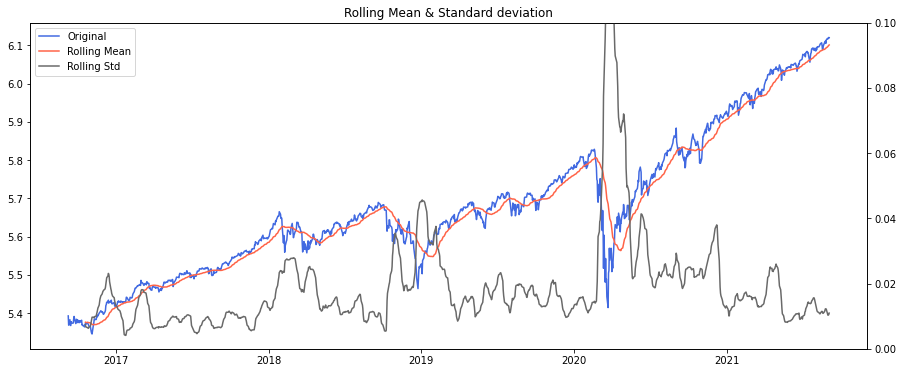

In [331]:
plot_rolling_statistics(ts_log, window=30)

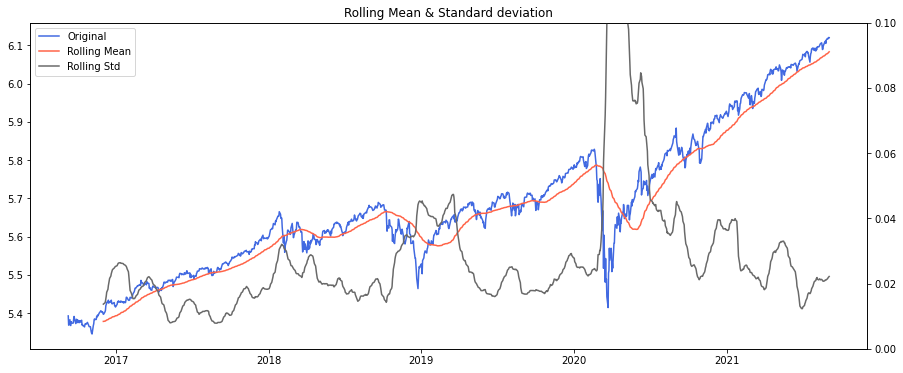

In [332]:
plot_rolling_statistics(ts_log, window=60)

각각 15, 30, 60일로 그림을 그리고 이동평균선, 이동표준편차선을 확인해보면 일정하지 않고 원래 그래프에 따라 상승하는 모습을 보입니다. 통계적으로도 확인해보기 위해  `augmented_dickey_fuller_test` 를 사용하겠습니다.

In [333]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test: 
Test Statistic                   -0.448780
p-value                           0.901630
#Lags Used                        9.000000
Number of Observations Used    1247.000000
Critical value 1%                -3.435605
Critical value 5%                -2.863861
Critical value 10%               -2.568005
dtype: float64


유의수준값이 0.9로 꽤 높습니다. 따라서 별도의 전처리를 추가적으로 진행해주겠습니다.

### (1) Moving average 제거 - 추세(Trend) 상쇄하기

위에서 확인 15, 30, 60일 이동평균을 삭제하여 추세를 상쇄시킨 시계열 데이터를 각각 구하고 시각화를 해보고 통계적으로도 변화가 있는 지 확인해보겠습니다.

#### (a) 15일 이동평균 삭제

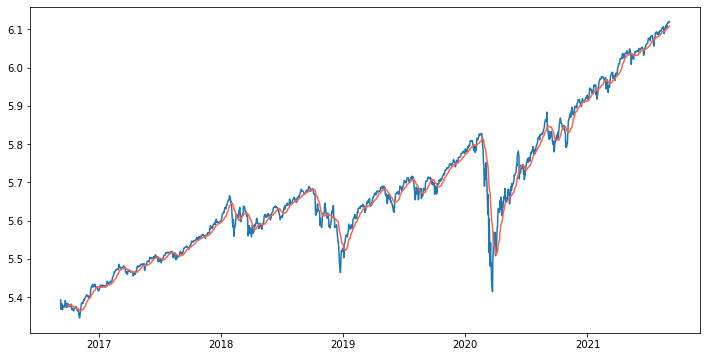

In [362]:
moving_avg_15 = ts_log.rolling(window=15).mean()  # moving average구하기
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(ts_log)
ax.plot(moving_avg_15, color='tomato')

In [363]:
ts_log_moving_avg_15 = ts_log - moving_avg_15 # 변화량 제거
ts_log_moving_avg_15.dropna(inplace=True)
ts_log_moving_avg_15.head(15)

Date
2016-09-28    0.005541
2016-09-29   -0.002310
2016-09-30    0.004232
2016-10-03    0.001375
2016-10-04   -0.003470
2016-10-05    0.000134
2016-10-06    0.000924
2016-10-07   -0.003194
2016-10-10    0.001338
2016-10-11   -0.010732
2016-10-12   -0.008480
2016-10-13   -0.009948
2016-10-14   -0.008603
2016-10-17   -0.011341
2016-10-18   -0.004605
Name: Close, dtype: float64

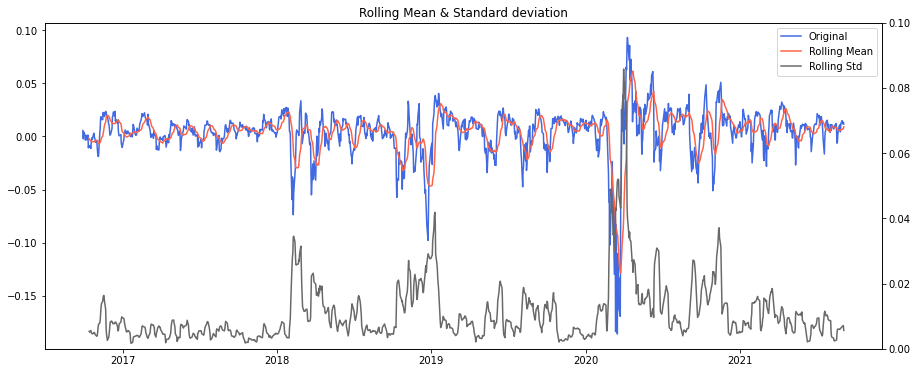

In [364]:
plot_rolling_statistics(ts_log_moving_avg_15)

In [365]:
augmented_dickey_fuller_test(ts_log_moving_avg_15)

Results of Dickey-Fuller Test: 
Test Statistic                -9.289336e+00
p-value                        1.191462e-15
#Lags Used                     9.000000e+00
Number of Observations Used    1.233000e+03
Critical value 1%             -3.435665e+00
Critical value 5%             -2.863887e+00
Critical value 10%            -2.568020e+00
dtype: float64


p-value가 0에 가까운 아주 작은 값으로 떨어진 것을 확인할 수 있습니다.

#### (b) 30일 이동평균 삭제

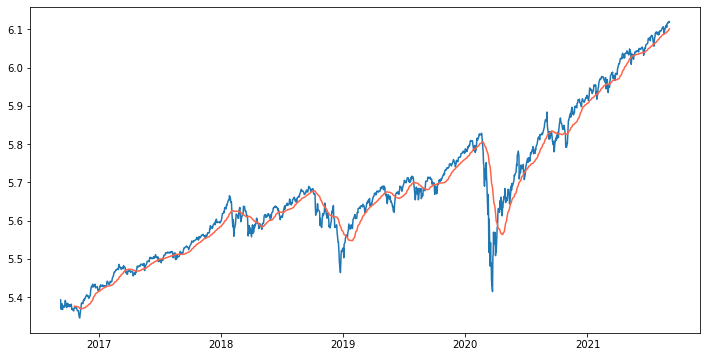

In [366]:
moving_avg_30 = ts_log.rolling(window=30).mean()  # moving average구하기
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(ts_log)
ax.plot(moving_avg_30, color='tomato')

In [367]:
ts_log_moving_avg_30 = ts_log - moving_avg_30 # 변화량 제거
ts_log_moving_avg_30.dropna(inplace=True)
ts_log_moving_avg_30.head(15)

Date
2016-10-19   -0.003620
2016-10-20   -0.004611
2016-10-21   -0.004242
2016-10-24    0.000397
2016-10-25   -0.002948
2016-10-26   -0.005136
2016-10-27   -0.007553
2016-10-28   -0.010206
2016-10-31   -0.010170
2016-11-01   -0.016477
2016-11-02   -0.021636
2016-11-03   -0.024345
2016-11-04   -0.024661
2016-11-07   -0.002550
2016-11-08    0.002282
Name: Close, dtype: float64

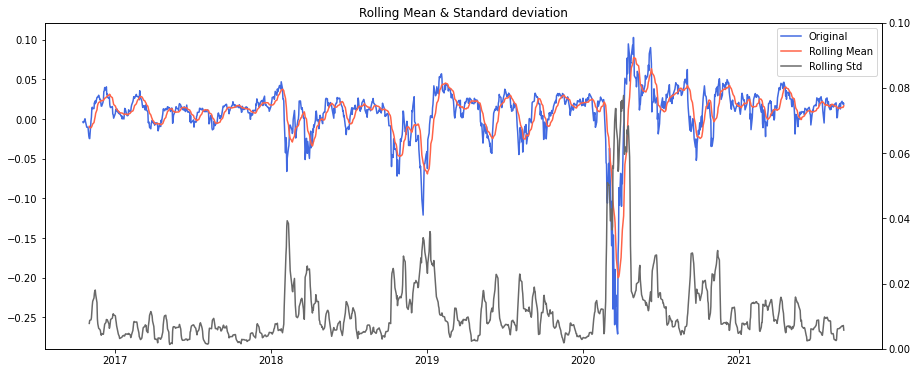

In [368]:
plot_rolling_statistics(ts_log_moving_avg_30)

In [369]:
augmented_dickey_fuller_test(ts_log_moving_avg_30)

Results of Dickey-Fuller Test: 
Test Statistic                -7.361677e+00
p-value                        9.464494e-11
#Lags Used                     9.000000e+00
Number of Observations Used    1.218000e+03
Critical value 1%             -3.435730e+00
Critical value 5%             -2.863916e+00
Critical value 10%            -2.568035e+00
dtype: float64


p-value가 0에 가깝습니다.

#### (c) 60일 이동평균 삭제

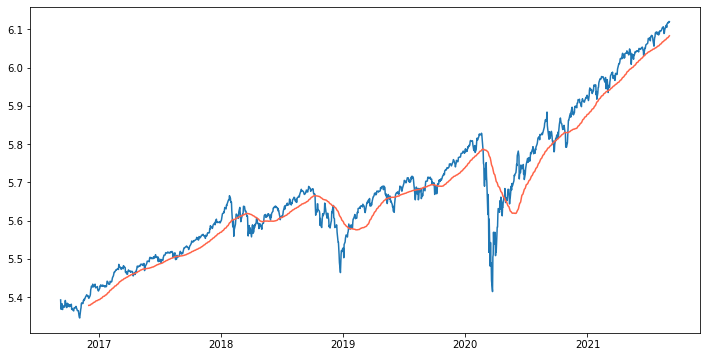

In [370]:
moving_avg_60 = ts_log.rolling(window=60).mean()  # moving average구하기
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(ts_log)
ax.plot(moving_avg_60, color='tomato')

In [371]:
ts_log_moving_avg_60 = ts_log - moving_avg_60 # 변화량 제거
ts_log_moving_avg_60.dropna(inplace=True)
ts_log_moving_avg_60.head(15)

Date
2016-12-01    0.018530
2016-12-02    0.019262
2016-12-05    0.024456
2016-12-06    0.027644
2016-12-07    0.039614
2016-12-08    0.041089
2016-12-09    0.046579
2016-12-12    0.044451
2016-12-13    0.049934
2016-12-14    0.041482
2016-12-15    0.044079
2016-12-16    0.041930
2016-12-19    0.043040
2016-12-20    0.045957
2016-12-21    0.036977
Name: Close, dtype: float64

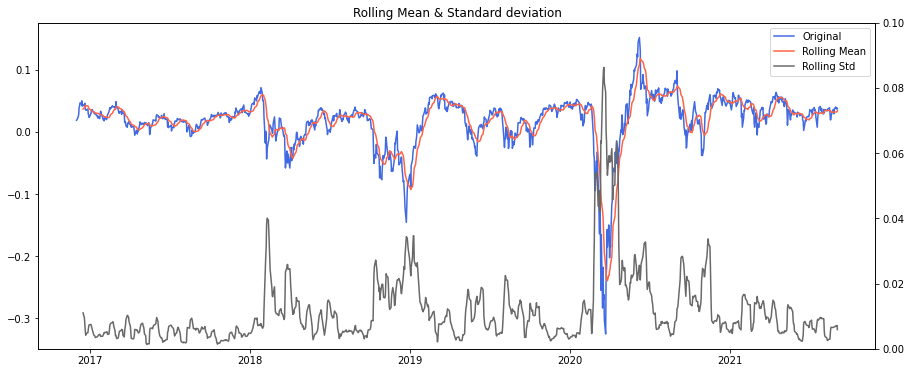

In [372]:
plot_rolling_statistics(ts_log_moving_avg_60)

In [373]:
augmented_dickey_fuller_test(ts_log_moving_avg_60)

Results of Dickey-Fuller Test: 
Test Statistic                   -5.231227
p-value                           0.000008
#Lags Used                        9.000000
Number of Observations Used    1188.000000
Critical value 1%                -3.435866
Critical value 5%                -2.863976
Critical value 10%               -2.568067
dtype: float64


p-value가 0.000008입니다

p-value가 가장 작은 15일 이동평균을 삭제한 `ts_log_moving_avg_15`를 사용하도록 하겠습니다.

### (2) 차분(Differencing) - 계절성(Seasonality) 상쇄하기
이동평균의 삭제로 잡히지 않는 시계열 데이터의 주기성들을 확인해보기 위해 계절성을 체크해보겠습니다.

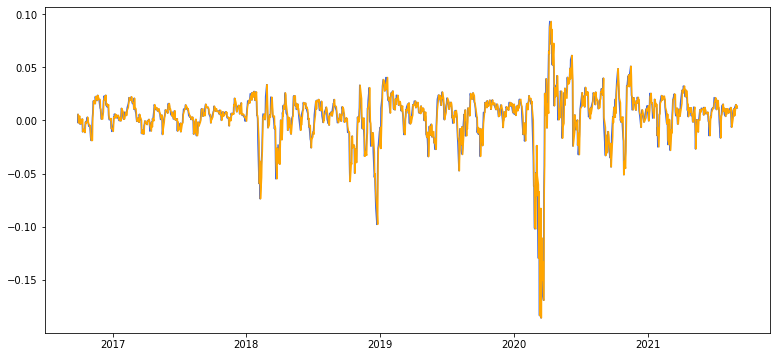

In [374]:
ts_log_moving_avg_shift = ts_log_moving_avg_15.shift()

fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(ts_log_moving_avg_15, color='royalblue')
ax.plot(ts_log_moving_avg_shift, color='orange')

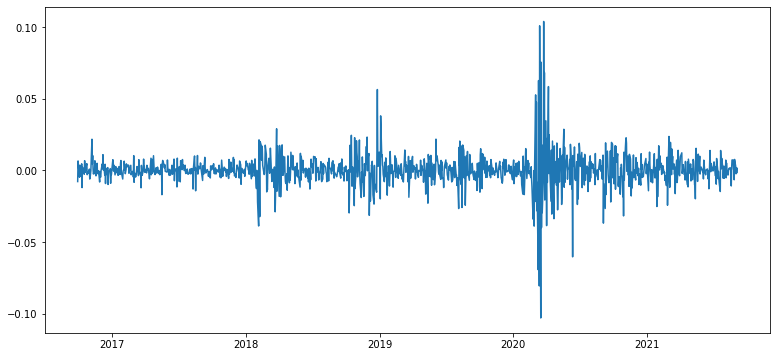

In [375]:
ts_log_moving_avg_diff = ts_log_moving_avg_15 - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)

fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(ts_log_moving_avg_diff)

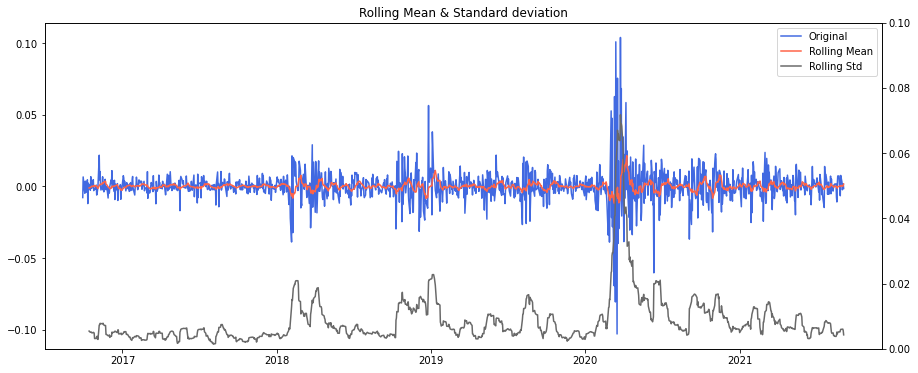

In [376]:
plot_rolling_statistics(ts_log_moving_avg_diff)

In [377]:
augmented_dickey_fuller_test(ts_log_moving_avg_diff)

Results of Dickey-Fuller Test: 
Test Statistic                -1.080706e+01
p-value                        1.951109e-19
#Lags Used                     2.300000e+01
Number of Observations Used    1.218000e+03
Critical value 1%             -3.435730e+00
Critical value 5%             -2.863916e+00
Critical value 10%            -2.568035e+00
dtype: float64


p-value가 사실상 0이라고 볼 수 있을만큼 작은 값이 됐습니다.

### (3) 시계열 분해(Time series decomposition)

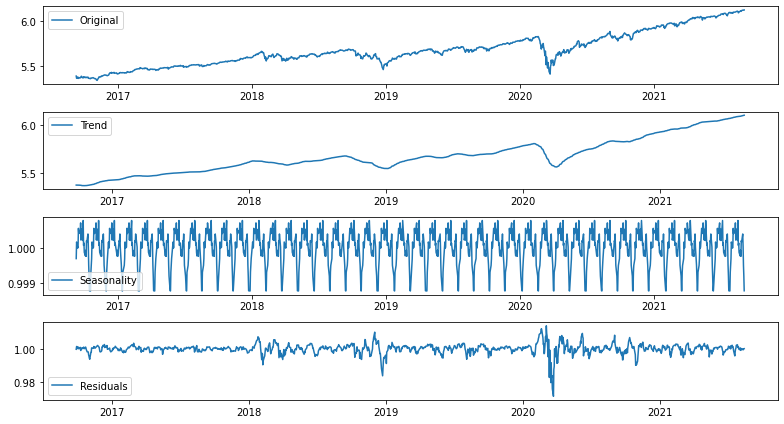

In [378]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates


decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30)

trend = decomposition.trend 
seasonal = decomposition.seasonal
residual = decomposition.resid

fig, axes = plt.subplots(figsize=(11, 6), nrows=4, ncols=1)
axs = axes.ravel()

axs[0].plot(ts_log, label='Original')
axs[0].legend(loc='best')

axs[1].plot(trend, label='Trend')
axs[1].legend(loc='best')

axs[2].plot(seasonal, label='Seasonality')
axs[2].legend(loc='best')

axs[3].plot(residual, label='Residuals')
axs[3].legend(loc='best')

fig.tight_layout()

기존 시계열에서 Trend, Seasonality를 제거한 residual의 안정성을 체크해보겠습니다.

In [379]:
residual.isna().sum()

30

In [380]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test: 
Test Statistic                -1.049086e+01
p-value                        1.148046e-18
#Lags Used                     2.100000e+01
Number of Observations Used    1.205000e+03
Critical value 1%             -3.435788e+00
Critical value 5%             -2.863942e+00
Critical value 10%            -2.568049e+00
dtype: float64


이번에도 아주 낮은 p-value값을 볼 수 있습니다.

## STEP 4: 학습, 테스트 데이터셋 생성

Train data's length: 1131
Test data's length: 126


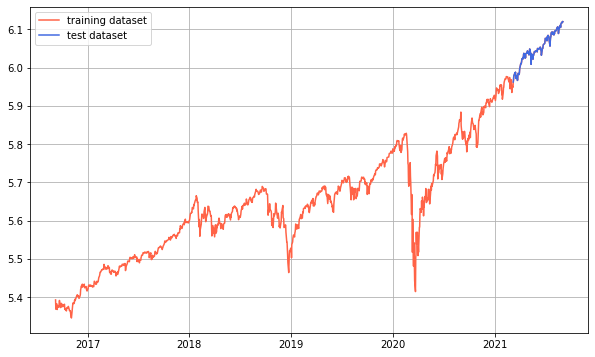

In [381]:
split_idx = int(len(ts_log) * 0.9)
train_data, test_data = ts_log[:split_idx], ts_log[split_idx:]

print(f"Train data's length: {len(train_data)}")
print(f"Test data's length: {len(test_data)}")

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(ts_log, c='tomato', label='training dataset') ## 전체 데이터셋을 이용해 그리면 자연스럽게 가능.
ax.plot(test_data, c='royalblue', label='test dataset')
ax.grid(True)
ax.legend()

## STEP 5: 적정 ARIMA 모수 찾기

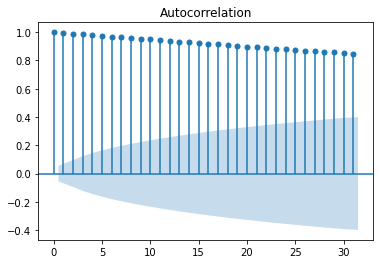

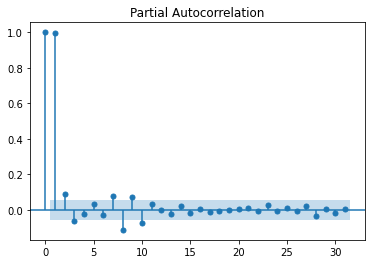

In [382]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)
plot_pacf(ts_log)

plt.show()

이번에도 그래프를 통해 **p=1이 적합함**만을 알 수 있습니다. q의 적합한 값은 위 두 그래프로 파악하기는 쉽지 않습니다.

Results of Dickey-Fuller Test: 
Test Statistic                -1.060594e+01
p-value                        6.002613e-19
#Lags Used                     8.000000e+00
Number of Observations Used    1.247000e+03
Critical value 1%             -3.435605e+00
Critical value 5%             -2.863861e+00
Critical value 10%            -2.568005e+00
dtype: float64


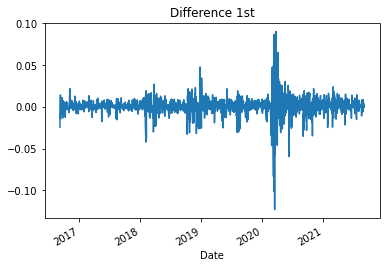

In [383]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test: 
Test Statistic                -1.520138e+01
p-value                        5.823105e-28
#Lags Used                     1.500000e+01
Number of Observations Used    1.239000e+03
Critical value 1%             -3.435639e+00
Critical value 5%             -2.863876e+00
Critical value 10%            -2.568013e+00
dtype: float64


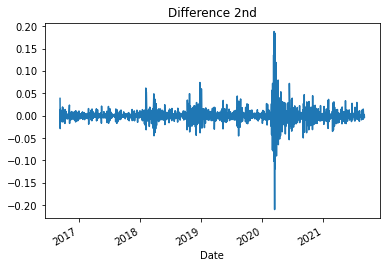

In [384]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

1차, 2차 차분 모두 아주 낮은 p-value를 보여주고 있습니다.

## STEP 6: ARIMA 모델 훈련과 테스트

이번에는 바로 AUTOARIMA를 사용하며 실험을 진행해보겠습니다. 실험 방식은 위와 비슷하게 d=1, d=2인 경우로 나눠 진행해보겠습니다.

### (1) `d = 1`

In [385]:
model_arima = auto_arima(train_data ,trace=True, error_action='ignore', 
                        start_p=0, start_q=0, d=1, max_p=5, max_q=5,
                        suppress_warnings=True, stepwise=False, seasonal=False)

model_arima.fit(train_data)

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6676.689, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6731.142, Time=0.26 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-6771.563, Time=0.39 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-6770.657, Time=0.62 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-6771.002, Time=2.41 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=-6768.390, Time=0.90 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6748.787, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-6755.663, Time=0.33 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-6765.758, Time=0.30 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-6768.331, Time=1.23 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-6769.334, Time=1.76 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-6763.900, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-6758.230, Time=0.68 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-6766.707, Time=0.18 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-6763.961, Time=1.03

ARIMA(order=(5, 1, 0), scoring_args={}, suppress_warnings=True)

AUTOARIMA는 결과로 (5, 1, 0)을 반환했습니다.

In [386]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(train_data, order = (5, 1, 0)) ## p, d, q
fitted_m = model.fit(disp=-1)

print(fitted_m.summary())

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1130
Model:                 ARIMA(5, 1, 0)   Log Likelihood                3396.153
Method:                       css-mle   S.D. of innovations              0.012
Date:                Tue, 07 Sep 2021   AIC                          -6778.306
Time:                        13:44:30   BIC                          -6743.097
Sample:                             1   HQIC                         -6765.004
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0005      0.000      1.485      0.137      -0.000       0.001
ar.L1.D.Close    -0.2184      0.030     -7.348      0.000      -0.277      -0.160
ar.L2.D.Close     0.1508      0.030     

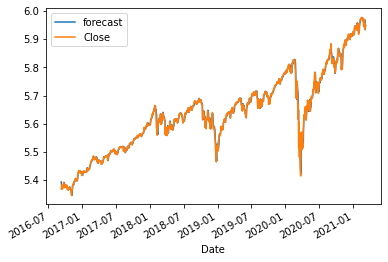

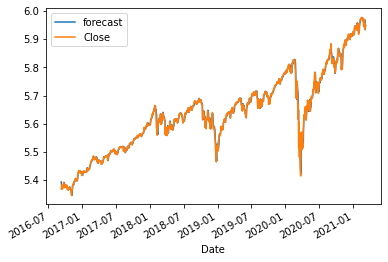

In [387]:
fitted_m.plot_predict()

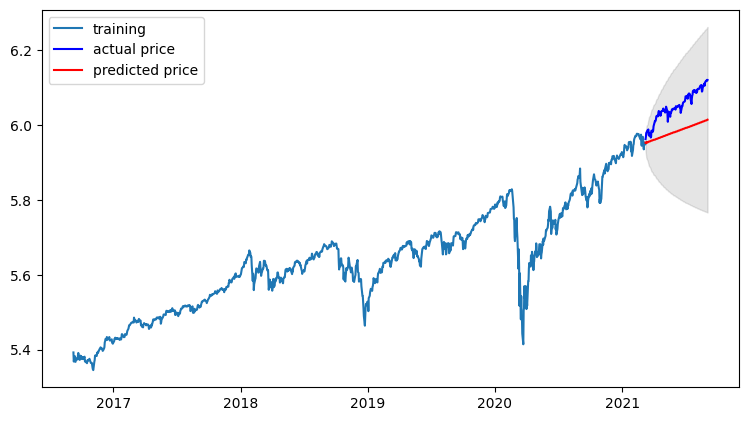

In [388]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
fig, ax = plt.subplots(figsize=(9, 5), dpi=100)
ax.plot(train_data, label='training')
ax.plot(test_data, c='b', label='actual price')
ax.plot(fc_series, c='r', label='predicted price')
ax.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
ax.legend()

In [389]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  865.5164617683712
MAE:  27.533783648012705
RMSE:  29.419661142990265
MAPE: 6.40%


MAPE로 6.40%를 보여주고 있습니다.

### (2) `d = 2`

In [390]:
model_arima = auto_arima(train_data ,trace=True, error_action='ignore', 
                        start_p=0, start_q=0, d=2, max_p=5, max_q=5,
                        suppress_warnings=True, stepwise=False, seasonal=False)

model_arima.fit(train_data)

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-5635.471, Time=0.07 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-6646.408, Time=0.62 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.27 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=-6705.606, Time=0.58 sec
 ARIMA(0,2,4)(0,0,0)[0] intercept   : AIC=-6717.945, Time=1.88 sec
 ARIMA(0,2,5)(0,0,0)[0] intercept   : AIC=-6695.714, Time=1.20 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-6309.677, Time=0.47 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.15 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=-6608.841, Time=0.31 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.13 sec
 ARIMA(1,2,4)(0,0,0)[0] intercept   : AIC=-6780.904, Time=2.23 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=-6482.487, Time=0.27 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=-6697.524, Time=0.90 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.27 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=-6815.349, Time=1.49 sec
 ARIMA(3,2,0)(0,0,0

ARIMA(order=(2, 2, 3), scoring_args={}, suppress_warnings=True)

AUTOARIMA는 결과로 (2, 2, 3)을 가장 좋은 결과로 반환하고 있습니다.

In [391]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(train_data, order = (2, 2, 3)) ## p, d, q
fitted_m = model.fit(disp=-1)

print(fitted_m.summary())

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

                             ARIMA Model Results                              
Dep. Variable:               D2.Close   No. Observations:                 1129
Model:                 ARIMA(2, 2, 3)   Log Likelihood                3424.069
Method:                       css-mle   S.D. of innovations              0.012
Date:                Tue, 07 Sep 2021   AIC                          -6834.139
Time:                        13:45:38   BIC                          -6798.935
Sample:                             2   HQIC                         -6820.838
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           4.458e-07   2.82e-06      0.158      0.874   -5.08e-06    5.97e-06
ar.L1.D2.Close    -1.7492      0.025    -69.217      0.000      -1.799      -1.700
ar.L2.D2.Close    -0.8867      0.027

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:1521: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))


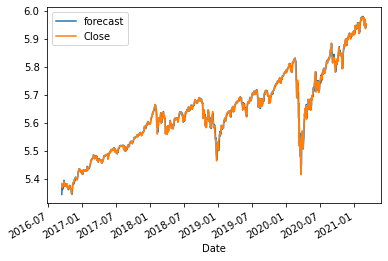

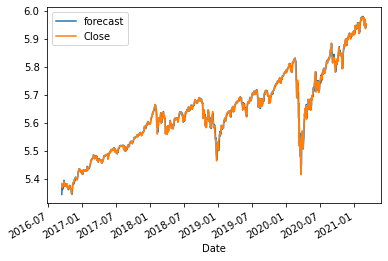

In [392]:
fitted_m.plot_predict()

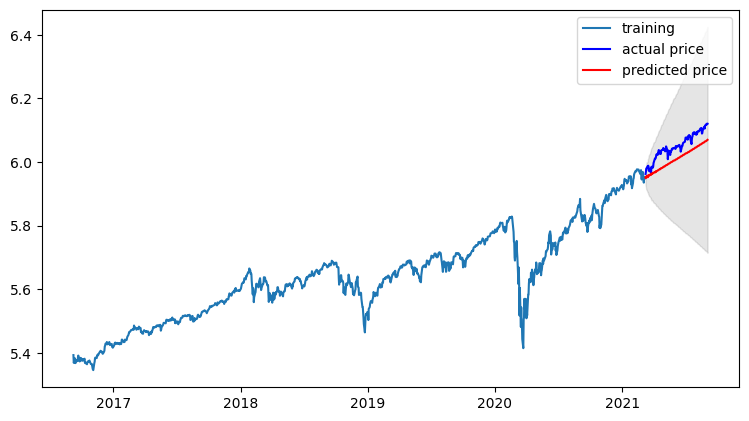

In [393]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
fig, ax = plt.subplots(figsize=(9, 5), dpi=100)
ax.plot(train_data, label='training')
ax.plot(test_data, c='b', label='actual price')
ax.plot(fc_series, c='r', label='predicted price')
ax.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
ax.legend()

In [394]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  306.7786630171878
MAE:  16.721145186098596
RMSE:  17.515098144663302
MAPE: 3.91%


성능이 아주 좋습니다. 확실히 개별종목보다는 지수추종 종목을 잘 예상하고 있습니다.

# 다른 주식 종목 예측해 보기5 - Apple

## STEP 1: 시계열 데이터 준비

In [395]:
import pandas_datareader as pdr

df = pdr.DataReader('AAPL', 'yahoo')

In [396]:
df.head()

High        Low       Open      Close       Volume  Adj Close
Date                                                                          
2016-09-08  26.817499  26.309999  26.812500  26.379999  212008000.0  24.740232
2016-09-09  26.430000  25.782499  26.160000  25.782499  186228000.0  24.179869
2016-09-12  26.430000  25.632500  25.662500  26.360001  181171200.0  24.721476
2016-09-13  27.197500  26.809999  26.877501  26.987499  248704800.0  25.309967
2016-09-14  28.257500  27.150000  27.182501  27.942499  443554800.0  26.205605

In [397]:
ts = df['Close']
ts.head()

Date
2016-09-08    26.379999
2016-09-09    25.782499
2016-09-12    26.360001
2016-09-13    26.987499
2016-09-14    27.942499
Name: Close, dtype: float64

## STEP 2: 각종 전처리 수행

In [398]:
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

원래도 결측치가 없지만, 보간법을 한번 사용해보겠습니다.

In [399]:
ts = ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

Text(0.5, 1.0, 'Closing price of Apple')

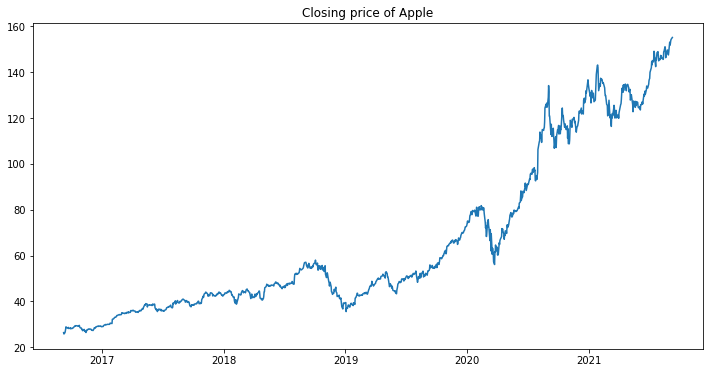

In [400]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(ts)
ax.set_title("Closing price of Apple")

로그 변환을 진행해보겠습니다.

Text(0.5, 1.0, 'Closing price(Log) of Apple')

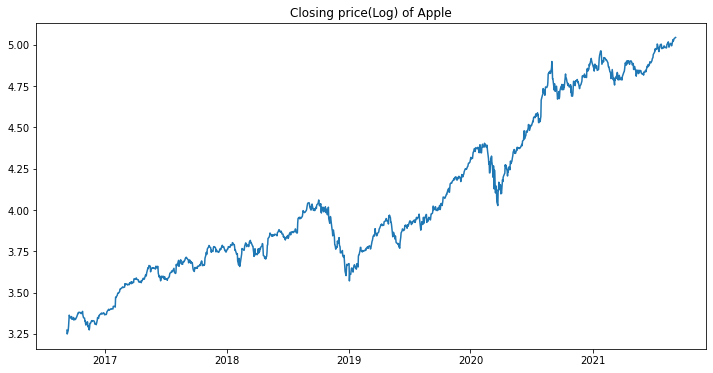

In [401]:
ts_log = np.log(ts)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(ts_log)
ax.set_title("Closing price(Log) of Apple")

## STEP 3: 시계열 안정성 분석

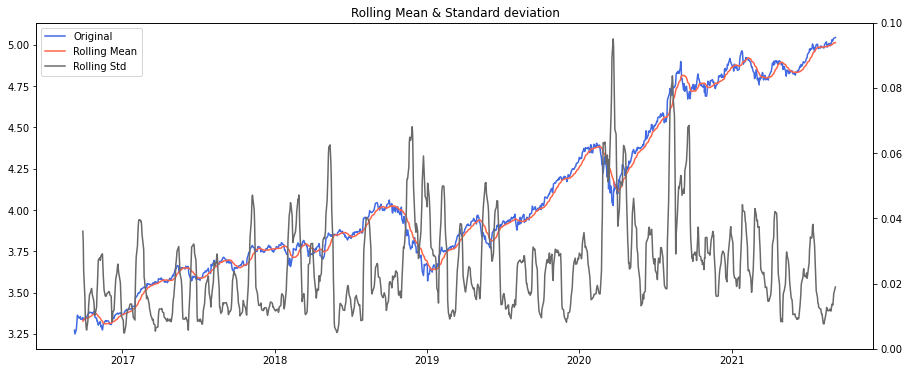

In [402]:
plot_rolling_statistics(ts_log, window=15)

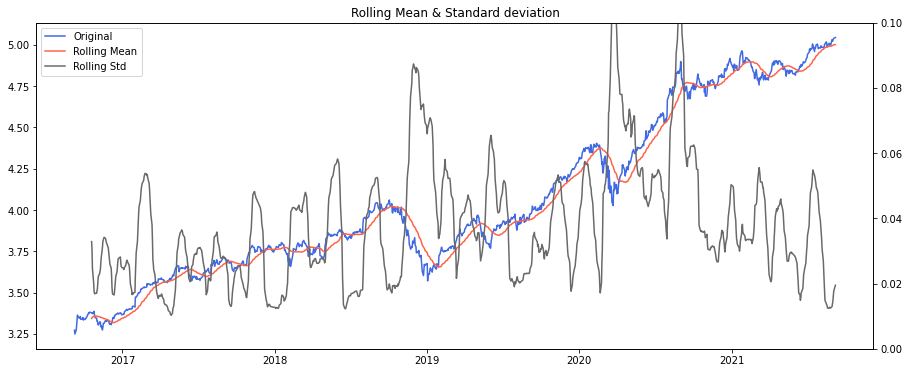

In [403]:
plot_rolling_statistics(ts_log, window=30)

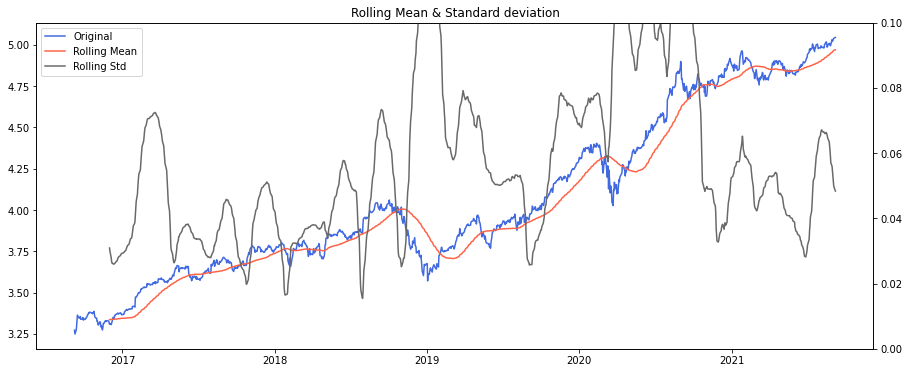

In [404]:
plot_rolling_statistics(ts_log, window=60)

각각 15, 30, 60일로 그림을 그리고 이동평균선, 이동표준편차선을 확인해보면 일정하지 않고 원래 그래프에 따라 상승하는 모습을 보입니다. 통계적으로도 확인해보기 위해  `augmented_dickey_fuller_test` 를 사용하겠습니다.

In [405]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test: 
Test Statistic                   -0.005237
p-value                           0.958097
#Lags Used                        9.000000
Number of Observations Used    1248.000000
Critical value 1%                -3.435601
Critical value 5%                -2.863859
Critical value 10%               -2.568004
dtype: float64


유의수준값이 0.9로 꽤 높습니다. 따라서 별도의 전처리를 추가적으로 진행해주겠습니다.

### (1) Moving average 제거 - 추세(Trend) 상쇄하기

위에서 확인 15, 30, 60일 이동평균을 삭제하여 추세를 상쇄시킨 시계열 데이터를 각각 구하고 시각화를 해보고 통계적으로도 변화가 있는 지 확인해보겠습니다.

#### (a) 15일 이동평균 삭제

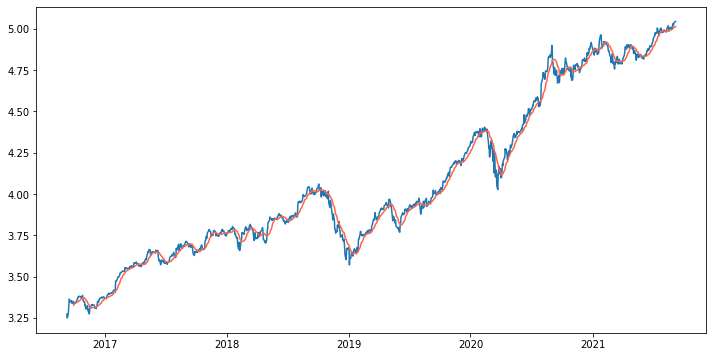

In [406]:
moving_avg_15 = ts_log.rolling(window=15).mean()  # moving average구하기
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(ts_log)
ax.plot(moving_avg_15, color='tomato')

In [407]:
ts_log_moving_avg_15 = ts_log - moving_avg_15 # 변화량 제거
ts_log_moving_avg_15.dropna(inplace=True)
ts_log_moving_avg_15.head(15)

Date
2016-09-28    0.022484
2016-09-29    0.002749
2016-09-30    0.004352
2016-10-03   -0.004680
2016-10-04   -0.003471
2016-10-05   -0.003788
2016-10-06    0.004591
2016-10-07    0.006583
2016-10-10    0.022446
2016-10-11    0.023014
2016-10-12    0.029728
2016-10-13    0.025296
2016-10-14    0.027989
2016-10-17    0.024606
2016-10-18    0.021392
Name: Close, dtype: float64

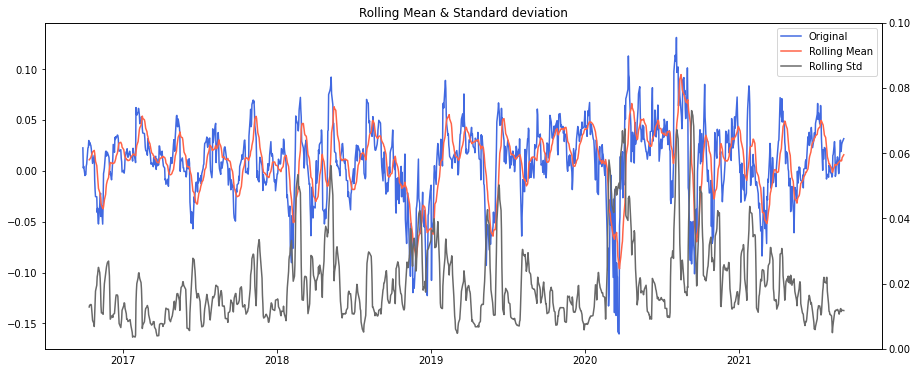

In [408]:
plot_rolling_statistics(ts_log_moving_avg_15)

In [409]:
augmented_dickey_fuller_test(ts_log_moving_avg_15)

Results of Dickey-Fuller Test: 
Test Statistic                -6.934236e+00
p-value                        1.064746e-09
#Lags Used                     1.900000e+01
Number of Observations Used    1.224000e+03
Critical value 1%             -3.435704e+00
Critical value 5%             -2.863904e+00
Critical value 10%            -2.568029e+00
dtype: float64


p-value가 0에 가까운 아주 작은 값으로 떨어진 것을 확인할 수 있습니다.

#### (b) 30일 이동평균 삭제

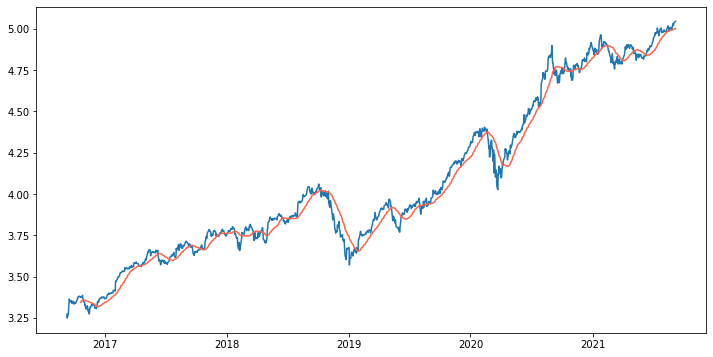

In [410]:
moving_avg_30 = ts_log.rolling(window=30).mean()  # moving average구하기
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(ts_log)
ax.plot(moving_avg_30, color='tomato')

In [411]:
ts_log_moving_avg_30 = ts_log - moving_avg_30 # 변화량 제거
ts_log_moving_avg_30.dropna(inplace=True)
ts_log_moving_avg_30.head(15)

Date
2016-10-19    0.033251
2016-10-20    0.029279
2016-10-21    0.021250
2016-10-24    0.026562
2016-10-25    0.028611
2016-10-26    0.004740
2016-10-27   -0.004594
2016-10-28   -0.010905
2016-10-31   -0.012477
2016-11-01   -0.030081
2016-11-02   -0.028604
2016-11-03   -0.043079
2016-11-04   -0.050969
2016-11-07   -0.035910
2016-11-08   -0.029436
Name: Close, dtype: float64

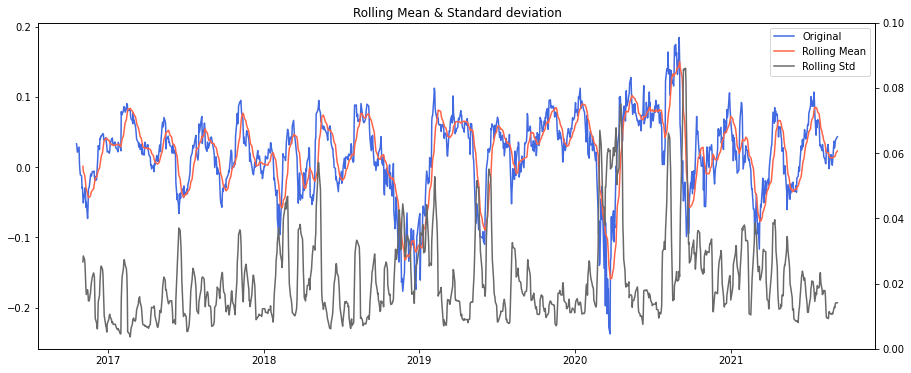

In [412]:
plot_rolling_statistics(ts_log_moving_avg_30)

In [413]:
augmented_dickey_fuller_test(ts_log_moving_avg_30)

Results of Dickey-Fuller Test: 
Test Statistic                -6.816350e+00
p-value                        2.054491e-09
#Lags Used                     1.900000e+01
Number of Observations Used    1.209000e+03
Critical value 1%             -3.435770e+00
Critical value 5%             -2.863934e+00
Critical value 10%            -2.568044e+00
dtype: float64


p-value가 0에 가깝습니다.

#### (c) 60일 이동평균 삭제

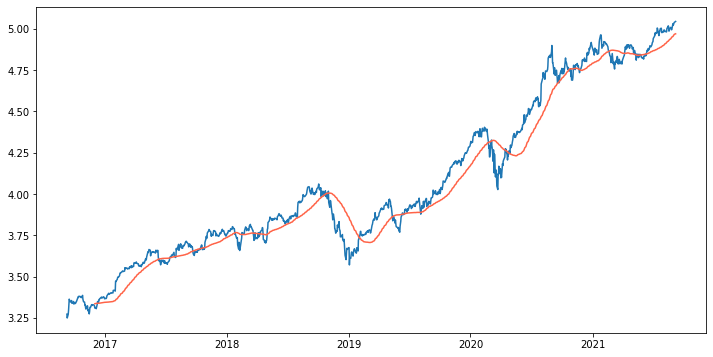

In [414]:
moving_avg_60 = ts_log.rolling(window=60).mean()  # moving average구하기
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(ts_log)
ax.plot(moving_avg_60, color='tomato')

In [415]:
ts_log_moving_avg_60 = ts_log - moving_avg_60 # 변화량 제거
ts_log_moving_avg_60.dropna(inplace=True)
ts_log_moving_avg_60.head(15)

Date
2016-12-01   -0.026662
2016-12-02   -0.023602
2016-12-05   -0.031756
2016-12-06   -0.024784
2016-12-07   -0.015479
2016-12-08   -0.005761
2016-12-09    0.010664
2016-12-12    0.005180
2016-12-13    0.021489
2016-12-14    0.021253
2016-12-15    0.026377
2016-12-16    0.027477
2016-12-19    0.032666
2016-12-20    0.034730
2016-12-21    0.035095
Name: Close, dtype: float64

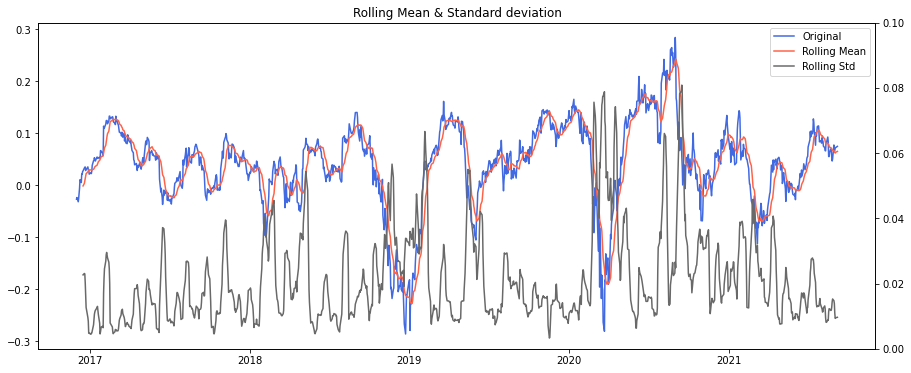

In [416]:
plot_rolling_statistics(ts_log_moving_avg_60)

In [417]:
augmented_dickey_fuller_test(ts_log_moving_avg_60)

Results of Dickey-Fuller Test: 
Test Statistic                   -5.255912
p-value                           0.000007
#Lags Used                       19.000000
Number of Observations Used    1179.000000
Critical value 1%                -3.435909
Critical value 5%                -2.863995
Critical value 10%               -2.568077
dtype: float64


p-value가 0.000008입니다

p-value가 가장 작은 15일 이동평균을 삭제한 `ts_log_moving_avg_15`를 사용하도록 하겠습니다.

### (2) 차분(Differencing) - 계절성(Seasonality) 상쇄하기
이동평균의 삭제로 잡히지 않는 시계열 데이터의 주기성들을 확인해보기 위해 계절성을 체크해보겠습니다.

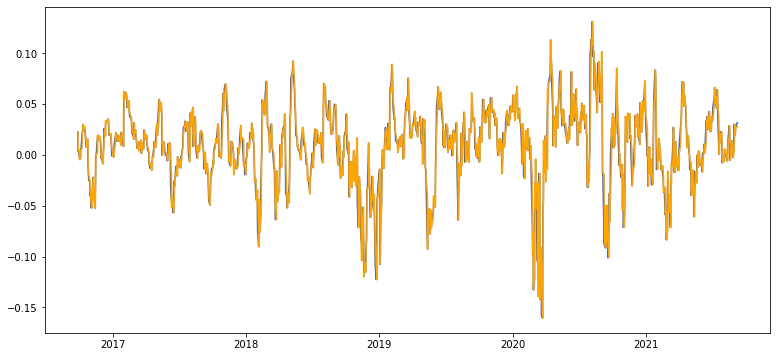

In [418]:
ts_log_moving_avg_shift = ts_log_moving_avg_15.shift()

fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(ts_log_moving_avg_15, color='royalblue')
ax.plot(ts_log_moving_avg_shift, color='orange')

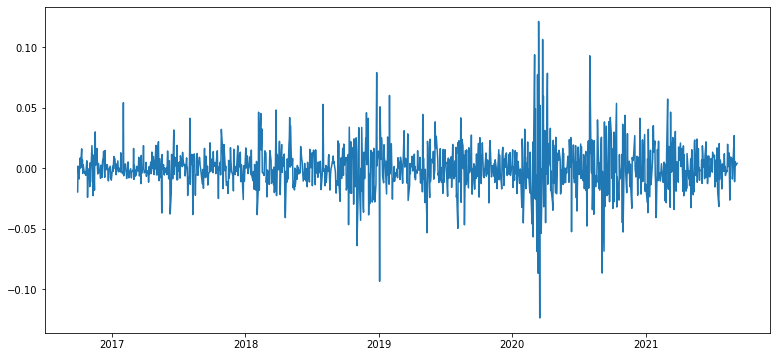

In [419]:
ts_log_moving_avg_diff = ts_log_moving_avg_15 - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)

fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(ts_log_moving_avg_diff)

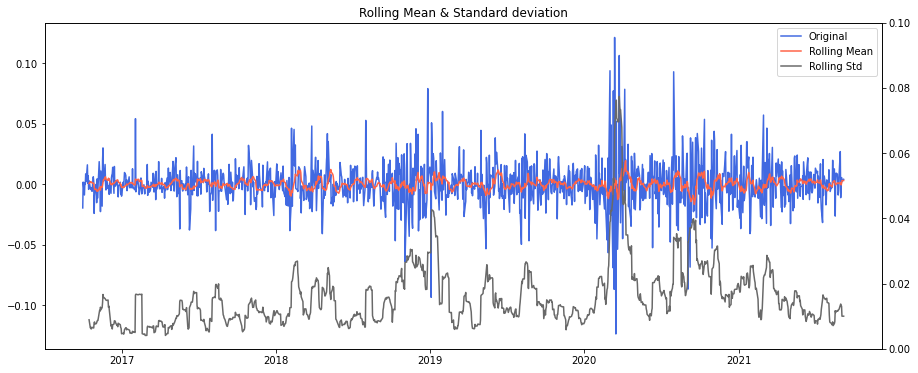

In [420]:
plot_rolling_statistics(ts_log_moving_avg_diff)

In [421]:
augmented_dickey_fuller_test(ts_log_moving_avg_diff)

Results of Dickey-Fuller Test: 
Test Statistic                -1.306756e+01
p-value                        1.987841e-24
#Lags Used                     1.400000e+01
Number of Observations Used    1.228000e+03
Critical value 1%             -3.435686e+00
Critical value 5%             -2.863896e+00
Critical value 10%            -2.568025e+00
dtype: float64


p-value가 사실상 0이라고 볼 수 있을만큼 작은 값이 됐습니다.

### (3) 시계열 분해(Time series decomposition)

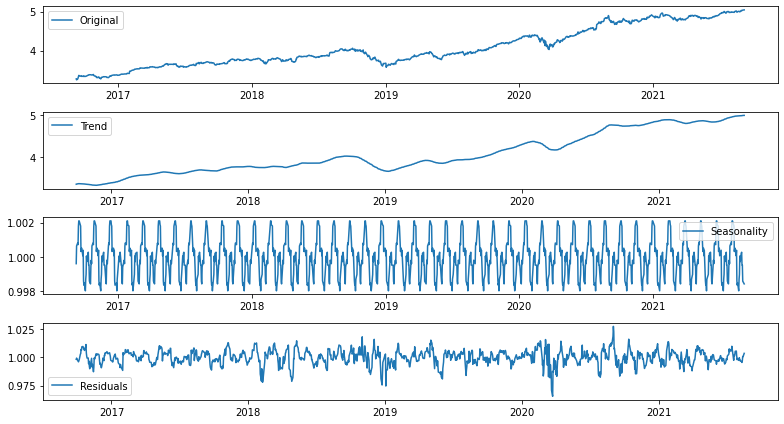

In [422]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates


decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30)

trend = decomposition.trend 
seasonal = decomposition.seasonal
residual = decomposition.resid

fig, axes = plt.subplots(figsize=(11, 6), nrows=4, ncols=1)
axs = axes.ravel()

axs[0].plot(ts_log, label='Original')
axs[0].legend(loc='best')

axs[1].plot(trend, label='Trend')
axs[1].legend(loc='best')

axs[2].plot(seasonal, label='Seasonality')
axs[2].legend(loc='best')

axs[3].plot(residual, label='Residuals')
axs[3].legend(loc='best')

fig.tight_layout()

기존 시계열에서 Trend, Seasonality를 제거한 residual의 안정성을 체크해보겠습니다.

In [423]:
residual.isna().sum()

30

In [424]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test: 
Test Statistic                -9.506931e+00
p-value                        3.327965e-16
#Lags Used                     2.100000e+01
Number of Observations Used    1.206000e+03
Critical value 1%             -3.435784e+00
Critical value 5%             -2.863940e+00
Critical value 10%            -2.568048e+00
dtype: float64


이번에도 아주 낮은 p-value값을 볼 수 있습니다.

## STEP 4: 학습, 테스트 데이터셋 생성

Train data's length: 1132
Test data's length: 126


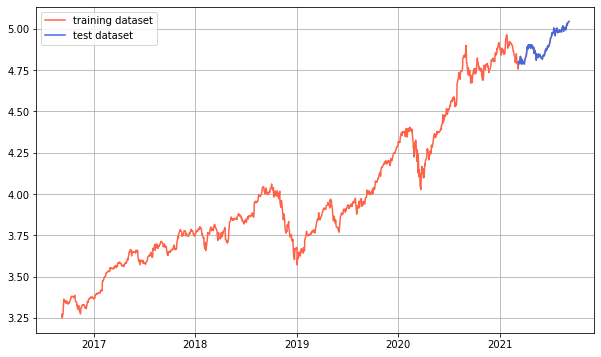

In [425]:
split_idx = int(len(ts_log) * 0.9)
train_data, test_data = ts_log[:split_idx], ts_log[split_idx:]

print(f"Train data's length: {len(train_data)}")
print(f"Test data's length: {len(test_data)}")

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(ts_log, c='tomato', label='training dataset') ## 전체 데이터셋을 이용해 그리면 자연스럽게 가능.
ax.plot(test_data, c='royalblue', label='test dataset')
ax.grid(True)
ax.legend()

## STEP 5: 적정 ARIMA 모수 찾기

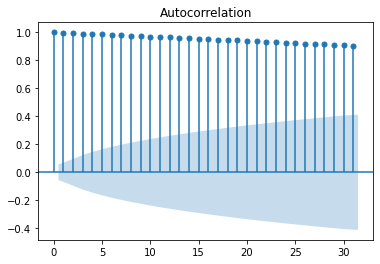

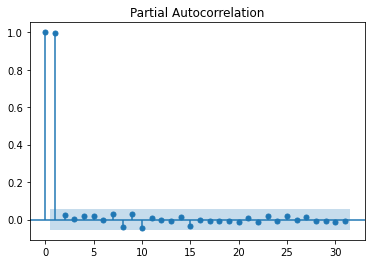

In [426]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)
plot_pacf(ts_log)

plt.show()

이번에도 그래프를 통해 **p=1이 적합함**만을 알 수 있습니다. q의 적합한 값은 위 두 그래프로 파악하기는 쉽지 않습니다.

Results of Dickey-Fuller Test: 
Test Statistic                -1.099011e+01
p-value                        7.095021e-20
#Lags Used                     8.000000e+00
Number of Observations Used    1.248000e+03
Critical value 1%             -3.435601e+00
Critical value 5%             -2.863859e+00
Critical value 10%            -2.568004e+00
dtype: float64


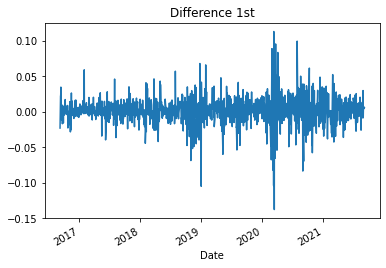

In [427]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test: 
Test Statistic                -1.556517e+01
p-value                        2.019126e-28
#Lags Used                     1.700000e+01
Number of Observations Used    1.238000e+03
Critical value 1%             -3.435643e+00
Critical value 5%             -2.863877e+00
Critical value 10%            -2.568014e+00
dtype: float64


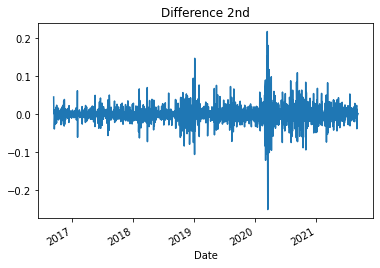

In [428]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

1차, 2차 차분 모두 아주 낮은 p-value를 보여주고 있습니다.

## STEP 6: ARIMA 모델 훈련과 테스트

이번에는 바로 AUTOARIMA를 사용하며 실험을 진행해보겠습니다. 실험 방식은 위와 비슷하게 d=1, d=2인 경우로 나눠 진행해보겠습니다.

### (1) `d = 1`

In [429]:
model_arima = auto_arima(train_data ,trace=True, error_action='ignore', 
                        start_p=0, start_q=0, d=1, max_p=5, max_q=5,
                        suppress_warnings=True, stepwise=False, seasonal=False)

model_arima.fit(train_data)

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5681.178, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5697.597, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-5696.881, Time=0.44 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-5695.033, Time=0.58 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-5693.078, Time=0.99 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=-5691.541, Time=1.55 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5698.591, Time=0.21 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5696.974, Time=0.27 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-5694.850, Time=0.21 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-5693.040, Time=0.77 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-5691.050, Time=1.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-5696.991, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-5694.988, Time=0.28 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-5692.962, Time=0.55 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-5691.033, Time=0.87

ARIMA(order=(1, 1, 0), scoring_args={}, suppress_warnings=True)

AUTOARIMA는 결과로 (1, 1, 0)을 반환했습니다.

In [430]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(train_data, order = (1, 1, 0)) ## p, d, q
fitted_m = model.fit(disp=-1)

print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1131
Model:                 ARIMA(1, 1, 0)   Log Likelihood                2852.296
Method:                       css-mle   S.D. of innovations              0.019
Date:                Tue, 07 Sep 2021   AIC                          -5698.591
Time:                        13:52:20   BIC                          -5683.499
Sample:                             1   HQIC                         -5692.889
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0013      0.001      2.634      0.008       0.000       0.002
ar.L1.D.Close    -0.1307      0.030     -4.425      0.000      -0.189      -0.073
                                    Root

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

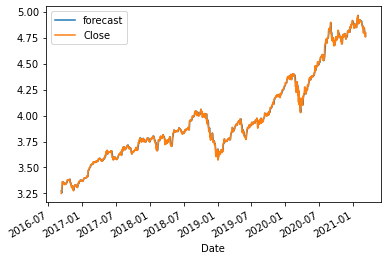

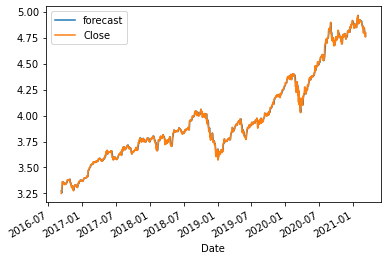

In [431]:
fitted_m.plot_predict()

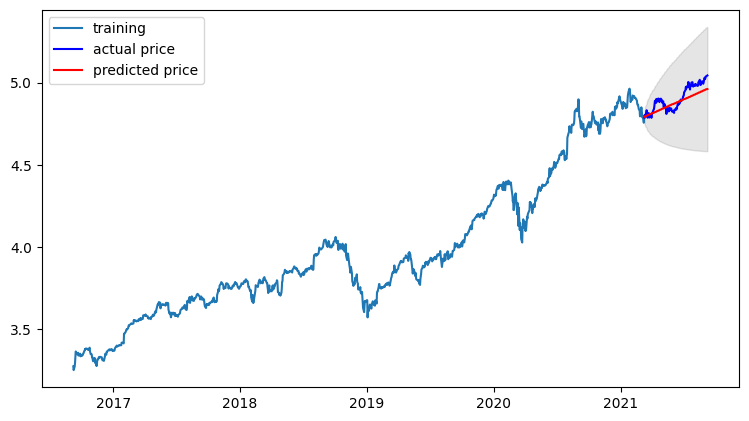

In [432]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
fig, ax = plt.subplots(figsize=(9, 5), dpi=100)
ax.plot(train_data, label='training')
ax.plot(test_data, c='b', label='actual price')
ax.plot(fc_series, c='r', label='predicted price')
ax.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
ax.legend()

In [433]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  44.09079230084011
MAE:  5.632733505414592
RMSE:  6.640089781082791
MAPE: 4.04%


MAPE로 4.04%를 보여주고 있습니다.

### (2) `d = 2`

In [434]:
model_arima = auto_arima(train_data ,trace=True, error_action='ignore', 
                        start_p=0, start_q=0, d=2, max_p=5, max_q=5,
                        suppress_warnings=True, stepwise=False, seasonal=False)

model_arima.fit(train_data)

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-4755.978, Time=0.10 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-5582.322, Time=0.33 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=-5603.637, Time=0.29 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=-5661.762, Time=1.23 sec
 ARIMA(0,2,4)(0,0,0)[0] intercept   : AIC=inf, Time=1.27 sec
 ARIMA(0,2,5)(0,0,0)[0] intercept   : AIC=-5640.500, Time=1.81 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-5202.228, Time=0.13 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.77 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=-5559.879, Time=0.37 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.00 sec
 ARIMA(1,2,4)(0,0,0)[0] intercept   : AIC=-5668.627, Time=1.98 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=-5347.980, Time=0.12 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=-5626.398, Time=0.73 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.97 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.32 sec
 ARIMA(3,2,0)(0,0,0)[0] i

ARIMA(order=(1, 2, 4), scoring_args={}, suppress_warnings=True)

AUTOARIMA는 결과로 (1, 2, 4)을 가장 좋은 결과로 반환하고 있습니다.

In [435]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(train_data, order = (1, 2, 4)) ## p, d, q
fitted_m = model.fit(disp=-1)

print(fitted_m.summary())

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

                             ARIMA Model Results                              
Dep. Variable:               D2.Close   No. Observations:                 1130
Model:                 ARIMA(1, 2, 4)   Log Likelihood                2850.750
Method:                       css-mle   S.D. of innovations              0.019
Date:                Tue, 07 Sep 2021   AIC                          -5687.500
Time:                        13:53:20   BIC                          -5652.290
Sample:                             2   HQIC                         -5674.197
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           4.064e-08   4.44e-06      0.009      0.993   -8.66e-06    8.74e-06
ar.L1.D2.Close    -0.8929      0.036    -24.804      0.000      -0.963      -0.822
ma.L1.D2.Close    -0.2114      0.047

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


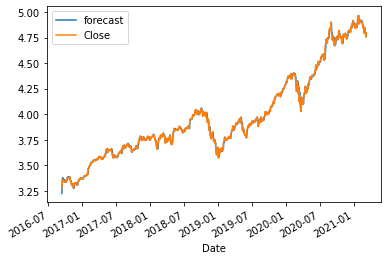

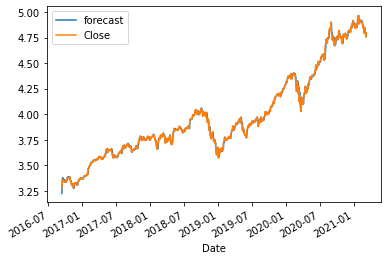

In [436]:
fitted_m.plot_predict()

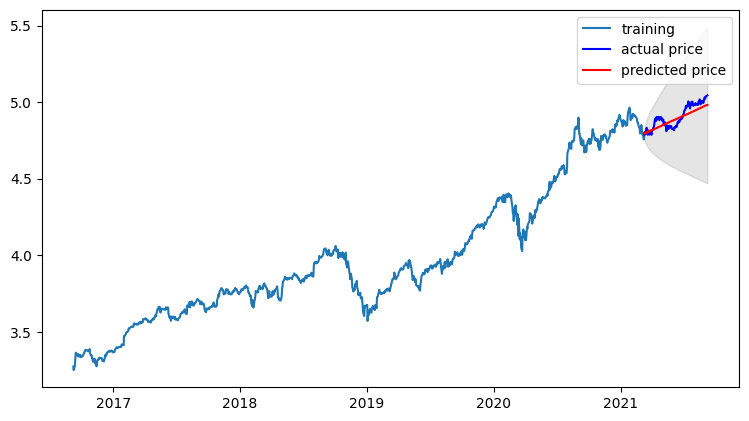

In [437]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
fig, ax = plt.subplots(figsize=(9, 5), dpi=100)
ax.plot(train_data, label='training')
ax.plot(test_data, c='b', label='actual price')
ax.plot(fc_series, c='r', label='predicted price')
ax.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
ax.legend()

In [438]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  31.786269249173746
MAE:  4.963305899766242
RMSE:  5.6379312916329285
MAPE: 3.61%


애플의 경우에는 5%미만의 오차로 잘 예측을 하고 있습니다.

## 소감

ARIMA 모델을 사용해 볼 수 있어서 좋았습니다. 데이터분석을 할 때 시계열을 분석해야 할 때 마다 단순히 그래프를 그리고 주기성을 스스로 찾아서 생각을 해 본 경험 밖에 없었는데, 조금 더 깊이 있는 시계열 분석을 앞으로는 해볼 수 있을 것 같습니다.

ARIMA로 체크한 AIC와 MAPE의 상관관계가 어떻게 되는 지 조금 더 공부를 해봐야겠습니다. AIC가 작게 나와 좋은 값이 나올 것이라고 생각을 해도 MAPE가 151.93%가 나오는 경우도 있었습니다. 

거의 대부분의 문제가 그렇지만 어떤 metric을 사용하고, 어떻게 해석해야하는 지가 정말 중요한 것을 다시 한번 느꼈습니다.